In [1]:
# import package
# installed via pip
from emtracks.particle import * # main solver object
from emtracks.conversions import one_gev_c2_to_kg # conversion for q factor (transverse momentum estimate)
from emtracks.tools import *#InitConds # initial conditions namedtuple
from emtracks.mapinterp import get_df_interp_func  # factory function for creating Mu2e DS interpolation function
from emtracks.Bdist import get_B_df_distorted
from emtracks.interpolations import *
import matplotlib.animation as animation
import numpy as np
from scipy.constants import c, elementary_charge
import pandas as pd
import pickle as pkl
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [24,16] # bigger figures
from matplotlib import style
style.use('fivethirtyeight')
import os

from joblib import Parallel, delayed
import multiprocessing
from tqdm.notebook import tqdm

testdir = "/home/darren/Desktop/plots/"
datadir = "/home/shared_data/"
plotdir = datadir+"plots/randomphi/maomaps7-14"
plotdir2 = datadir+"plots/randomphi/maomaps7-15"
mapdir = datadir+"Bmaps/"
date = "/7-9/"
newdir = datadir+'testmao2/'

maomapdir = '/home/shared_data/Bmaps/Mau10/combined/'

ERROR! Please set $EMTRACKS_DDIR and $EMTRACKS_PDIR. Setting defaults (current directory)


In [50]:
def readpkl(zstart, zend, numpoints):
    files = sorted(os.listdir(newdir))
    zsteps = np.linspace(zstart, zend, numpoints)
    data = []
    deleted = []

    for file in files:
        x = file.split('_')
        field = x[0]
        e_solvernom = trajectory_solver.from_pickle(newdir+file)
        phi = e_solvernom.init_conds.phi0
        theta = e_solvernom.init_conds.theta0
        for z in zsteps:
            if z > e_solvernom.dataframe.z.max() or z < e_solvernom.dataframe.z.min():
                data.append(9*[np.nan])
                deleted.append([e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
            elif z > 7.5:
                info = interp_cole(e_solvernom.dataframe, z)
                x = info[1]
                y = info[2]
                r = tuple([(x**2 + y**2)**(1/2)])
                r2 = tuple([((x-0.054094482)**(2) + (y-0.03873037)**(2))**(1/2)])
            
                df6 = e_solvernom.dataframe
                df5 = df6[(df6['z'] > 7.5) & (df6['z'] < 12.5)]
                xl = df5['x'].values
                yl = df5['y'].values
                zlist = df5['z'].values
                e = np.where(zlist < z)
                _, _, r3, _ = reco_circle(xl, yl)
                rreco = tuple([r3[e[0][-1]]])
                tuple1 = (z, field, theta, phi)

                data.append(tuple1 + info + r + r2 + rreco)
            else:
                info = interp_cole(e_solvernom.dataframe, z)
                x = info[1]
                y = info[2]
                r = tuple([(x**2 + y**2)**(1/2)])
                r2 = tuple([((x-0.054094482)**(2) + (y-0.03873037)**(2))**(1/2)])
            
                tuple1 = (z, field, theta, phi)

                data.append(tuple1 + info + r + r2 + tuple([np.nan]))
                
    return data, deleted

In [3]:
def readpklold(zstart, zend, numpoints):
    files = sorted(os.listdir(newdir))
    zsteps = np.linspace(zstart, zend, numpoints)
    data = []
    deleted = []

    for file in files:
        x = file.split('_')
        field = x[0]
        e_solvernom = trajectory_solver.from_pickle(newdir+file)
        phi = e_solvernom.init_conds.phi0
        theta = e_solvernom.init_conds.theta0
        for z in zsteps:
            if z > e_solvernom.dataframe.z.max() or z < e_solvernom.dataframe.z.min():
                data.append(8*[np.nan])
                deleted.append([e_solvernom.init_conds.theta0, e_solvernom.init_conds.phi0])
            else:
                info = interp_cole(e_solvernom.dataframe, z)
                x = info[1]
                y = info[2]
                r = tuple([(x**2 + y**2)**(1/2)])
                r2 = tuple([((x-0.054094482)**(2) + (y-0.03873037)**(2))**(1/2)])
                tuple1 = (z, field, theta, phi)
                
                nan = tuple([np.nan])

                data.append(tuple1 + info + r + r2)
                
    return data, deleted

In [4]:
x, deleted = readpklold(6, 13, 8)

In [5]:
x2, deleted2 = readpkl(6, 13, 8)

In [38]:
df = pd.DataFrame(x, columns = ['z', 'field', 'theta', 'phi', 't', 'x', 'y', 'r_(0,0)', 'r_(x0,y0)'])

In [7]:
df2 = pd.DataFrame(x2, columns = ['z', 'field', 'theta', 'phi', 't', 'x', 'y', 'r_(0,0)', 'r_(x0,y0)', 'rreco'])

In [8]:
df

z field  theta  phi             t         x         y   r_(0,0)  \
0        6.0  0.00    0.0  0.0  3.702312e-11  0.054095  0.038729  0.066530   
1        7.0  0.00    0.0  0.0  3.372867e-09  0.062298  0.040072  0.074073   
2        8.0  0.00    0.0  0.0  6.708633e-09  0.063537  0.044550  0.077600   
3        9.0  0.00    0.0  0.0  1.004438e-08  0.067587  0.046690  0.082146   
4       10.0  0.00    0.0  0.0  1.338011e-08  0.063760  0.046154  0.078712   
...      ...   ...    ...  ...           ...       ...       ...       ...   
239995   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239996   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239997   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239998   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239999   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   

        r_(x0, y0)  
0         0.000002  
1         0.008313  
2         0.011092  
3         0.015665  
4         0.012187  
...            ...  
239995         NaN  
239996         NaN  
239997         NaN  
239998         NaN  
239999         NaN  

[240000 rows x 9 columns]

In [9]:
df2

z field  theta  phi             t         x         y   r_(0,0)  \
0        6.0  0.00    0.0  0.0  3.702312e-11  0.054095  0.038729  0.066530   
1        7.0  0.00    0.0  0.0  3.372867e-09  0.062298  0.040072  0.074073   
2        8.0  0.00    0.0  0.0  6.708633e-09  0.063537  0.044550  0.077600   
3        9.0  0.00    0.0  0.0  1.004438e-08  0.067587  0.046690  0.082146   
4       10.0  0.00    0.0  0.0  1.338011e-08  0.063760  0.046154  0.078712   
...      ...   ...    ...  ...           ...       ...       ...       ...   
239995   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239996   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239997   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239998   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   
239999   NaN   NaN    NaN  NaN           NaN       NaN       NaN       NaN   

        r_(x0,y0)     rreco  
0        0.000002       NaN  
1        0.008313       NaN  
2        0.011092  0.002865  
3        0.015665  0.001777  
4        0.012187  0.002120  
...           ...       ...  
239995        NaN       NaN  
239996        NaN       NaN  
239997        NaN       NaN  
239998        NaN       NaN  
239999        NaN       NaN  

[240000 rows x 10 columns]

In [10]:
dfnew = df.dropna()
dfnew

z field     theta       phi             t         x         y  \
0        6.0  0.00  0.000000  0.000000  3.702312e-11  0.054095  0.038729   
1        7.0  0.00  0.000000  0.000000  3.372867e-09  0.062298  0.040072   
2        8.0  0.00  0.000000  0.000000  6.708633e-09  0.063537  0.044550   
3        9.0  0.00  0.000000  0.000000  1.004438e-08  0.067587  0.046690   
4       10.0  0.00  0.000000  0.000000  1.338011e-08  0.063760  0.046154   
...      ...   ...       ...       ...           ...       ...       ...   
233995   9.0   nom  2.179881  6.283185  7.019242e-08  0.061440  0.504347   
233996  10.0   nom  2.179881  6.283185  7.478121e-08  0.270110  0.132188   
233997  11.0   nom  2.179881  6.283185  7.935644e-08 -0.156282  0.227842   
233998  12.0   nom  2.179881  6.283185  8.390741e-08  0.221115  0.464740   
233999  13.0   nom  2.179881  6.283185  8.844234e-08  0.088149  0.033596   

         r_(0,0)  r_(x0, y0)  
0       0.066530    0.000002  
1       0.074073    0.008313  
2       0.077600    0.011092  
3       0.082146    0.015665  
4       0.078712    0.012187  
...          ...         ...  
233995  0.508076    0.465675  
233996  0.300721    0.235365  
233997  0.276290    0.282881  
233998  0.514660    0.457580  
233999  0.094334    0.034439  

[156984 rows x 9 columns]

In [11]:
dfnew2 = df2.dropna()
dfnew2

z field     theta       phi             t         x         y  \
2        8.0  0.00  0.000000  0.000000  6.708633e-09  0.063537  0.044550   
3        9.0  0.00  0.000000  0.000000  1.004438e-08  0.067587  0.046690   
4       10.0  0.00  0.000000  0.000000  1.338011e-08  0.063760  0.046154   
5       11.0  0.00  0.000000  0.000000  1.671586e-08  0.068231  0.046009   
6       12.0  0.00  0.000000  0.000000  2.005159e-08  0.064811  0.047682   
...      ...   ...       ...       ...           ...       ...       ...   
233995   9.0   nom  2.179881  6.283185  7.019242e-08  0.061440  0.504347   
233996  10.0   nom  2.179881  6.283185  7.478121e-08  0.270110  0.132188   
233997  11.0   nom  2.179881  6.283185  7.935644e-08 -0.156282  0.227842   
233998  12.0   nom  2.179881  6.283185  8.390741e-08  0.221115  0.464740   
233999  13.0   nom  2.179881  6.283185  8.844234e-08  0.088149  0.033596   

         r_(0,0)  r_(x0,y0)     rreco  
2       0.077600   0.011092  0.002865  
3       0.082146   0.015665  0.001777  
4       0.078712   0.012187  0.002120  
5       0.082295   0.015901  0.002354  
6       0.080461   0.013963  0.001838  
...          ...        ...       ...  
233995  0.508076   0.465675  0.235005  
233996  0.300721   0.235365  0.234705  
233997  0.276290   0.282881  0.240241  
233998  0.514660   0.457580  0.240293  
233999  0.094334   0.034439  0.244631  

[117738 rows x 10 columns]

In [12]:
dfnew['theta'].unique()        

array([0.        , 0.06411414, 0.12822827, 0.19234241, 0.25645654,
       0.32057068, 0.38468481, 0.44879895, 0.51291309, 0.57702722,
       0.64114136, 0.70525549, 0.76936963, 0.83348377, 0.8975979 ,
       0.96171204, 1.02582617, 1.08994031, 1.15405444, 1.21816858,
       1.28228272, 1.34639685, 1.41051099, 1.47462512, 1.53873926,
       1.60285339, 1.66696753, 1.73108167, 1.7951958 , 1.85930994,
       1.92342407, 1.98753821, 2.05165235, 2.11576648, 2.17988062])

In [13]:
dfnew2['theta'].unique()

array([0.        , 0.06411414, 0.12822827, 0.19234241, 0.25645654,
       0.32057068, 0.38468481, 0.44879895, 0.51291309, 0.57702722,
       0.64114136, 0.70525549, 0.76936963, 0.83348377, 0.8975979 ,
       0.96171204, 1.02582617, 1.08994031, 1.15405444, 1.21816858,
       1.28228272, 1.34639685, 1.41051099, 1.47462512, 1.53873926,
       1.60285339, 1.66696753, 1.73108167, 1.7951958 , 1.85930994,
       1.92342407, 1.98753821, 2.05165235, 2.11576648, 2.17988062])

In [14]:
def difarrays(df):
    ms = []
    data = []
    missing = []
    for z in df['z'].unique():
        for field in df['field'].unique()[:11]:
            xdifs = []
            ydifs = []
            rdifs = []
            for theta in df['theta'].unique():
                dfnew1 = df[(df['z']==z) & np.isclose(df['theta'], theta, 1e-1) & ((df['field']=='nom'))]
                dfnew2 = df[(df['z']==z) & np.isclose(df['theta'], theta, 1e-1) & ((df['field']==field))]                        
                if len(np.array(dfnew1['phi'])) != len(np.array(dfnew2['phi'])):
                    missing.append([z, field, theta])
                elif(np.isclose(v, 0) for v in (np.array(dfnew1['phi']) - np.array(dfnew2['phi']))):
                    xdif = np.array(dfnew2['x']) - np.array(dfnew1['x'])
                    ydif = np.array(dfnew2['y']) - np.array(dfnew1['y'])
                    
                
                    for a in range(0, len(xdif), 1):
                        data.append([xdif[a], ydif[a], z, field, theta])
                    for a in xdif:
                        xdifs.append(a)
                    for b in ydif:
                        ydifs.append(b)
                        
                else:
                    print('mistake')
            ms.append([field, z, np.mean(xdifs), np.mean(ydifs), np.std(xdifs), np.std(ydifs)])
                
    datadf = pd.DataFrame(data, columns = ['xdif', 'ydif', 'z', 'field', 'theta'])
    msdf = pd.DataFrame(ms, columns = ['field', 'z', 'xmean', 'ymean', 'xstd', 'ystd'])
                
    return msdf, datadf, missing 

In [15]:
def difarrays2(df):
    ms = []
    data = []
    missing = []
    for z in df['z'].unique():
        for field in df['field'].unique()[:11]:
            xdifs = []
            ydifs = []
            rdifs = []
            for theta in df['theta'].unique():
                dfnew1 = df[(df['z']==z) & np.isclose(df['theta'], theta, 1e-1) & ((df['field']=='nom'))]
                dfnew2 = df[(df['z']==z) & np.isclose(df['theta'], theta, 1e-1) & ((df['field']==field))]                        
                if len(np.array(dfnew1['phi'])) != len(np.array(dfnew2['phi'])):
                    missing.append([z, field, theta])
                elif(np.isclose(v, 0) for v in (np.array(dfnew1['phi']) - np.array(dfnew2['phi']))):
                    xdif = np.array(dfnew2['x']) - np.array(dfnew1['x'])
                    ydif = np.array(dfnew2['y']) - np.array(dfnew1['y'])
                    rdif = np.array(dfnew2['rreco']) - np.array(dfnew1['rreco'])
                    
                
                    for a in range(0, len(xdif), 1):
                        data.append([xdif[a], ydif[a], rdif[a], z, field, theta])
                    for a in xdif:
                        xdifs.append(a)
                    for b in ydif:
                        ydifs.append(b)
                    for c in rdif:
                        rdifs.append(c)
                        
                else:
                    print('mistake')
            ms.append([field, z, np.mean(xdifs), np.mean(ydifs), np.std(xdifs), np.std(ydifs), np.mean(rdifs), np.std(rdifs)])
                
    datadf = pd.DataFrame(data, columns = ['xdif', 'ydif', 'rdif', 'z', 'field', 'theta'])
    msdf = pd.DataFrame(ms, columns = ['field', 'z', 'xmean', 'ymean', 'xstd', 'ystd', 'rmean', 'rstd'])
                
    return msdf, datadf, missing 

In [16]:
msdf, datadf, missing = difarrays(dfnew)

In [40]:
len(missing)

432

In [17]:
msdf2, datadf2, missing2 = difarrays2(dfnew2)

In [41]:
len(missing2)

324

In [26]:
def makeplots(df, z):
    fields = df['field'].unique()
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,2), (0,0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2,2), (0,1), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2,2), (1,0), rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((2,2), (1,1), rowspan=1, colspan=1)

    df2 = df[df['z']==z]
    for field in fields:
        dfnew = df2[df2['field']==field]
        
        xmean = list(dfnew['xmean'])
        ymean = list(dfnew['ymean'])
        xstd = list(dfnew['xstd'])
        ystd = list(dfnew['ystd'])
        ax1.scatter(field, xmean, c='r', marker='s')
        ax1.set_title(f'(Dis X - Nom X) Mean Value at Different Fields', fontsize = 20, loc = 'right')
        ax1.set_xlabel(f'Field Map Label')
        ax1.set_ylabel(f'(Dis X - Nom X) Mean Value (meters)')
        
        ax2.scatter(field, ymean, c='r', marker='s')
        ax2.set_title(f'(Dis Y - Nom Y) Mean Value at Different Fields', fontsize = 20, loc = 'right')
        ax2.set_xlabel(f'Field Map Label')
        ax2.set_ylabel(f'(Dis Y - Nom Y) Mean Value (meters)')
        
        ax3.scatter(field, xstd, c='r', marker='s')
        ax3.set_title(f'(Dis X - Nom X) Std Value at Different Fields', fontsize = 20, loc = 'right')
        ax3.set_xlabel(f'Field Map Label')
        ax3.set_ylabel(f'(Dis X - Nom X) Std Value (meters)')
        
        ax4.scatter(field, ystd, c='r', marker='s')
        ax4.set_title(f'(Dis Y - Nom Y) Std Value at Different Fields', fontsize = 20, loc = 'right')
        ax4.set_xlabel(f'Field Map Label')
        ax4.set_ylabel(f'(Dis Y - Nom Y) Std Value (meters)')
    fig.suptitle(f'Mean, Std X, Y Displacements (Dis X, Y - Nom X, Y) at Z = {z}', fontsize = 30)
    fig.savefig(plotdir+f'/Mean,Std_Scatter_Z={z}.png')

        

In [27]:
def makeplots2(df, z):
    fields = df['field'].unique()
    fig = plt.figure()
    ax1 = plt.subplot2grid((2,1), (0,0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2,1), (1,0), rowspan=1, colspan=1)

    df2 = df[df['z']==z]
    for field in fields:
        dfnew = df2[df2['field']==field]
        
        rmean = list(dfnew['rmean'])
        rstd = list(dfnew['rstd'])
        
        ax1.scatter(field, rmean, c='r', marker='s')
        ax1.set_title(f'Mean Value at Different Fields', fontsize = 20, loc = 'right')
        ax1.set_xlabel(f'Field Map Label')
        ax1.set_ylabel(f'Mean Value (meters)')
        
        ax2.scatter(field, rstd, c='r', marker='s')
        ax2.set_title(f'Std Value at Different Fields', fontsize = 20, loc = 'right')
        ax2.set_xlabel(f'Field Map Label')
        ax2.set_ylabel(f'Std Value (meters)')
        
    fig.suptitle(f'Mean, Std R Displacement (Dis R - Nom R) at Z = {z}', fontsize = 30)
    fig.savefig(plotdir2+f'/Mean,Std_Scatter_R={z}.png')


In [28]:
zvals = datadf['z'].unique()
fieldvals = datadf['field'].unique()

zvals2 = datadf2['z'].unique()
fieldvals2 = datadf2['field'].unique()

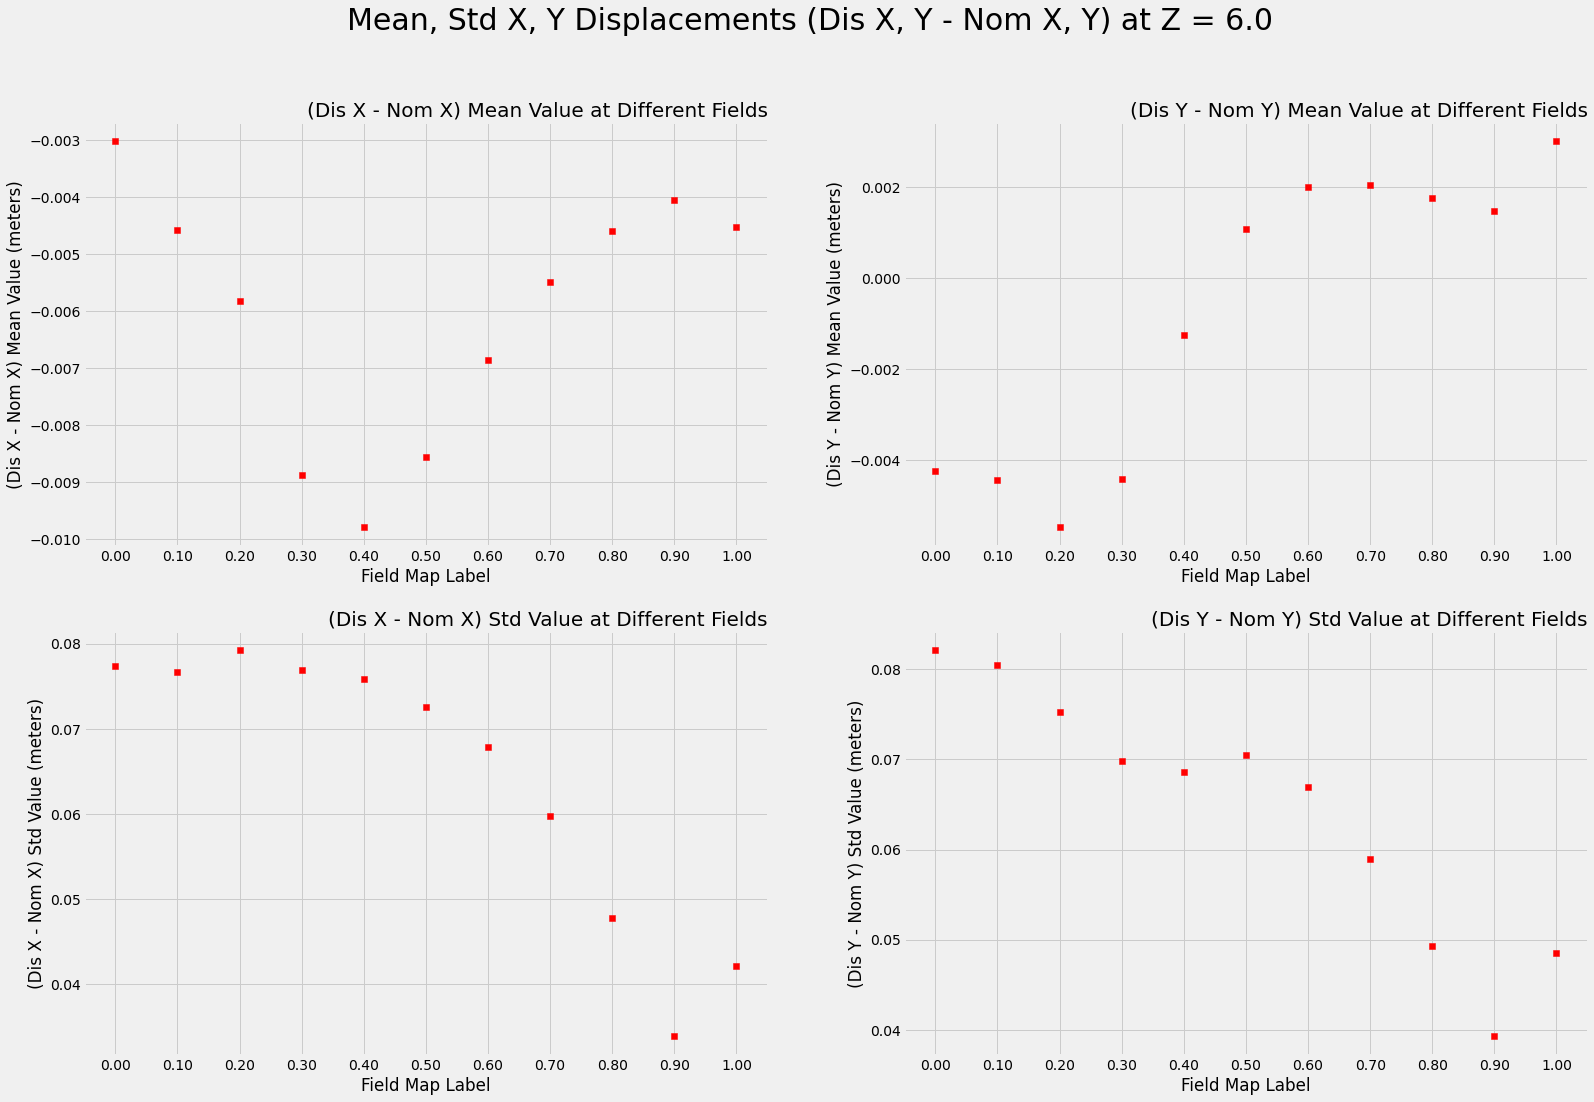

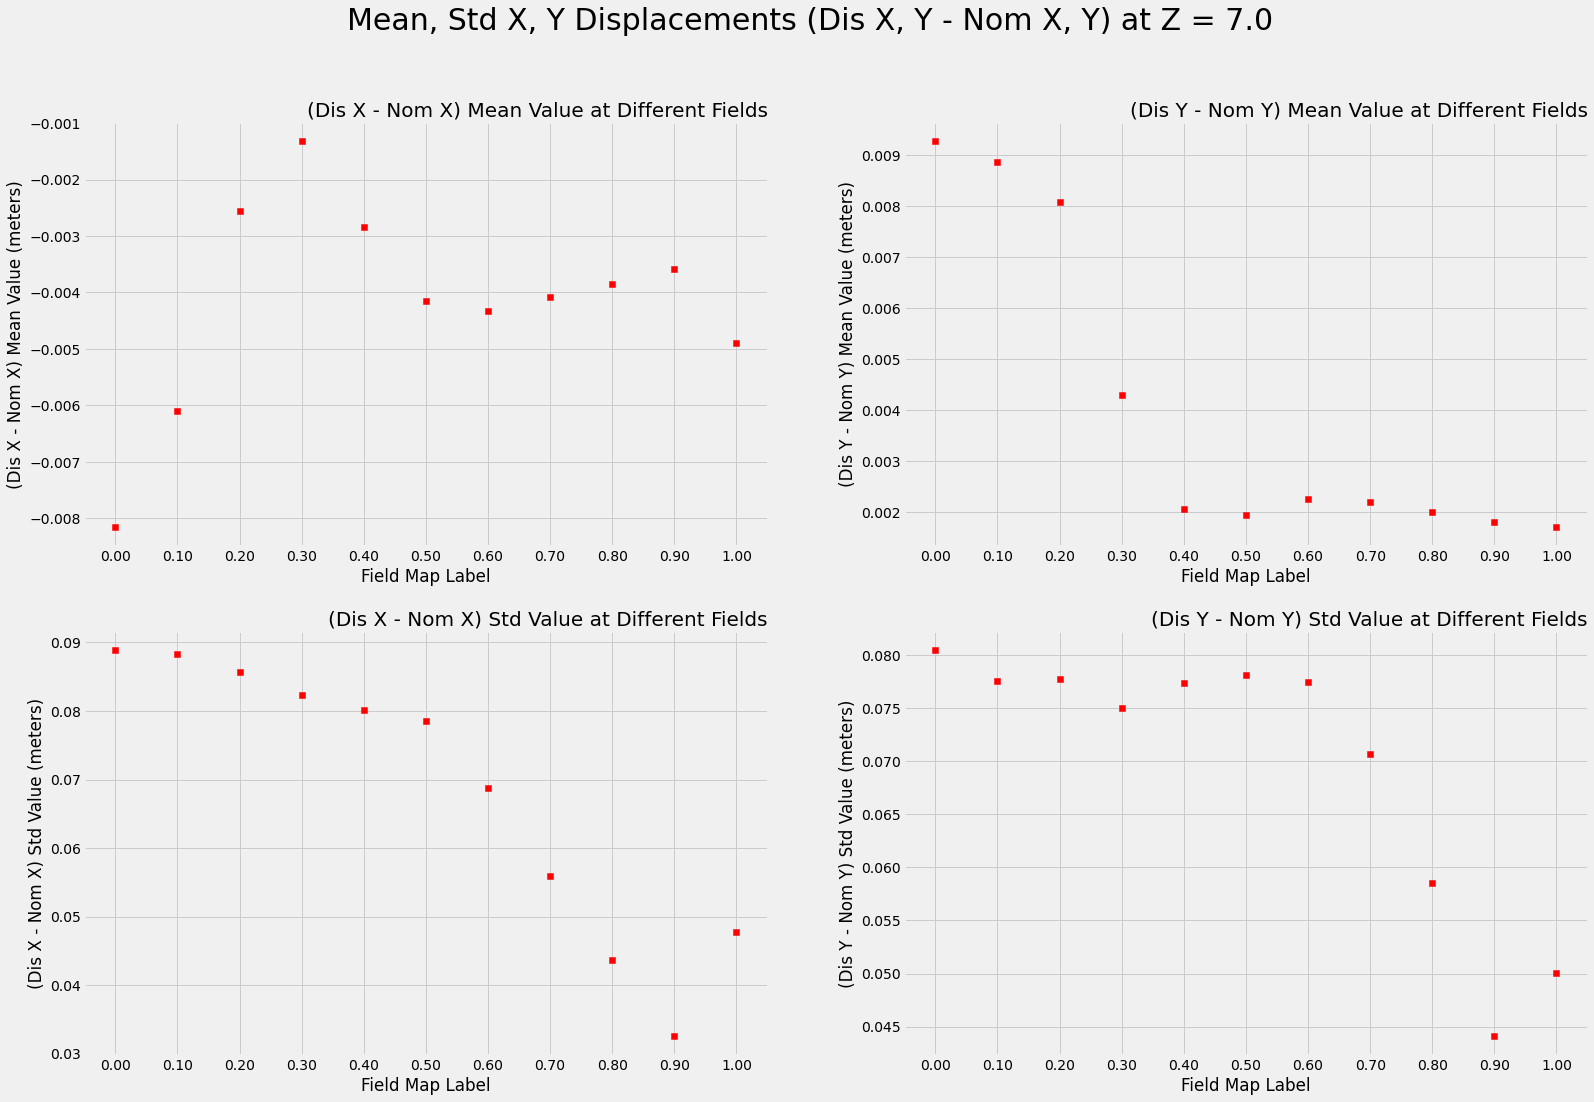

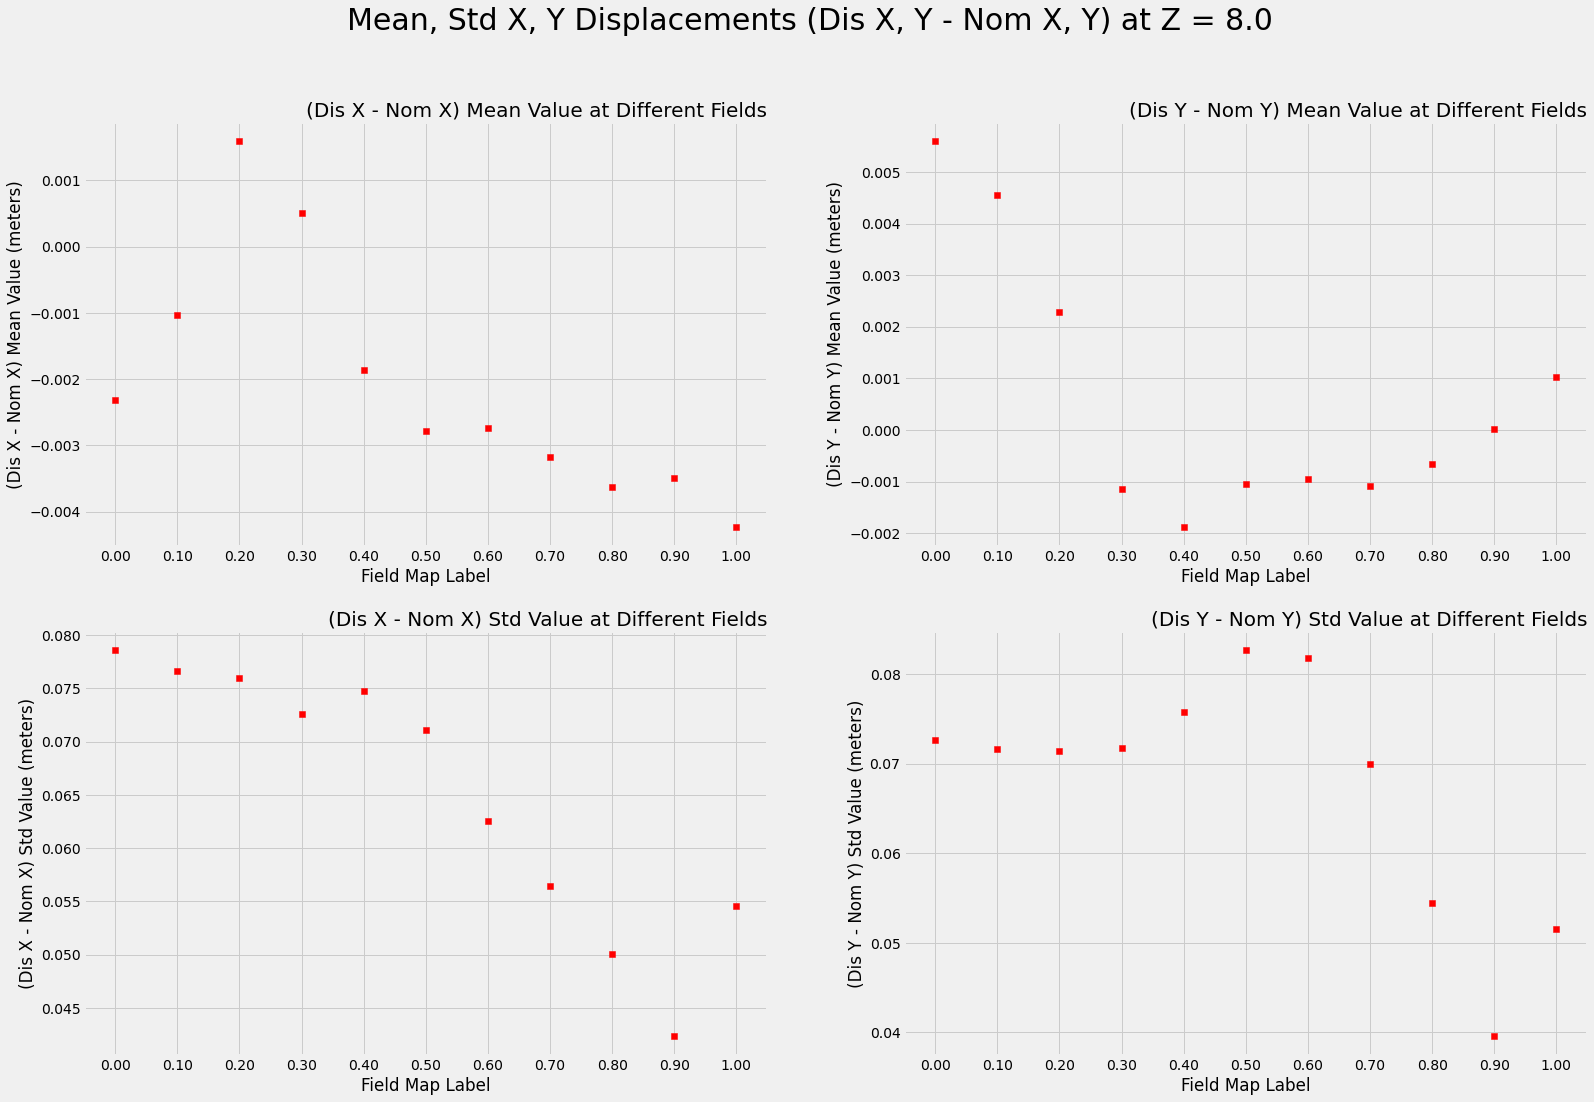

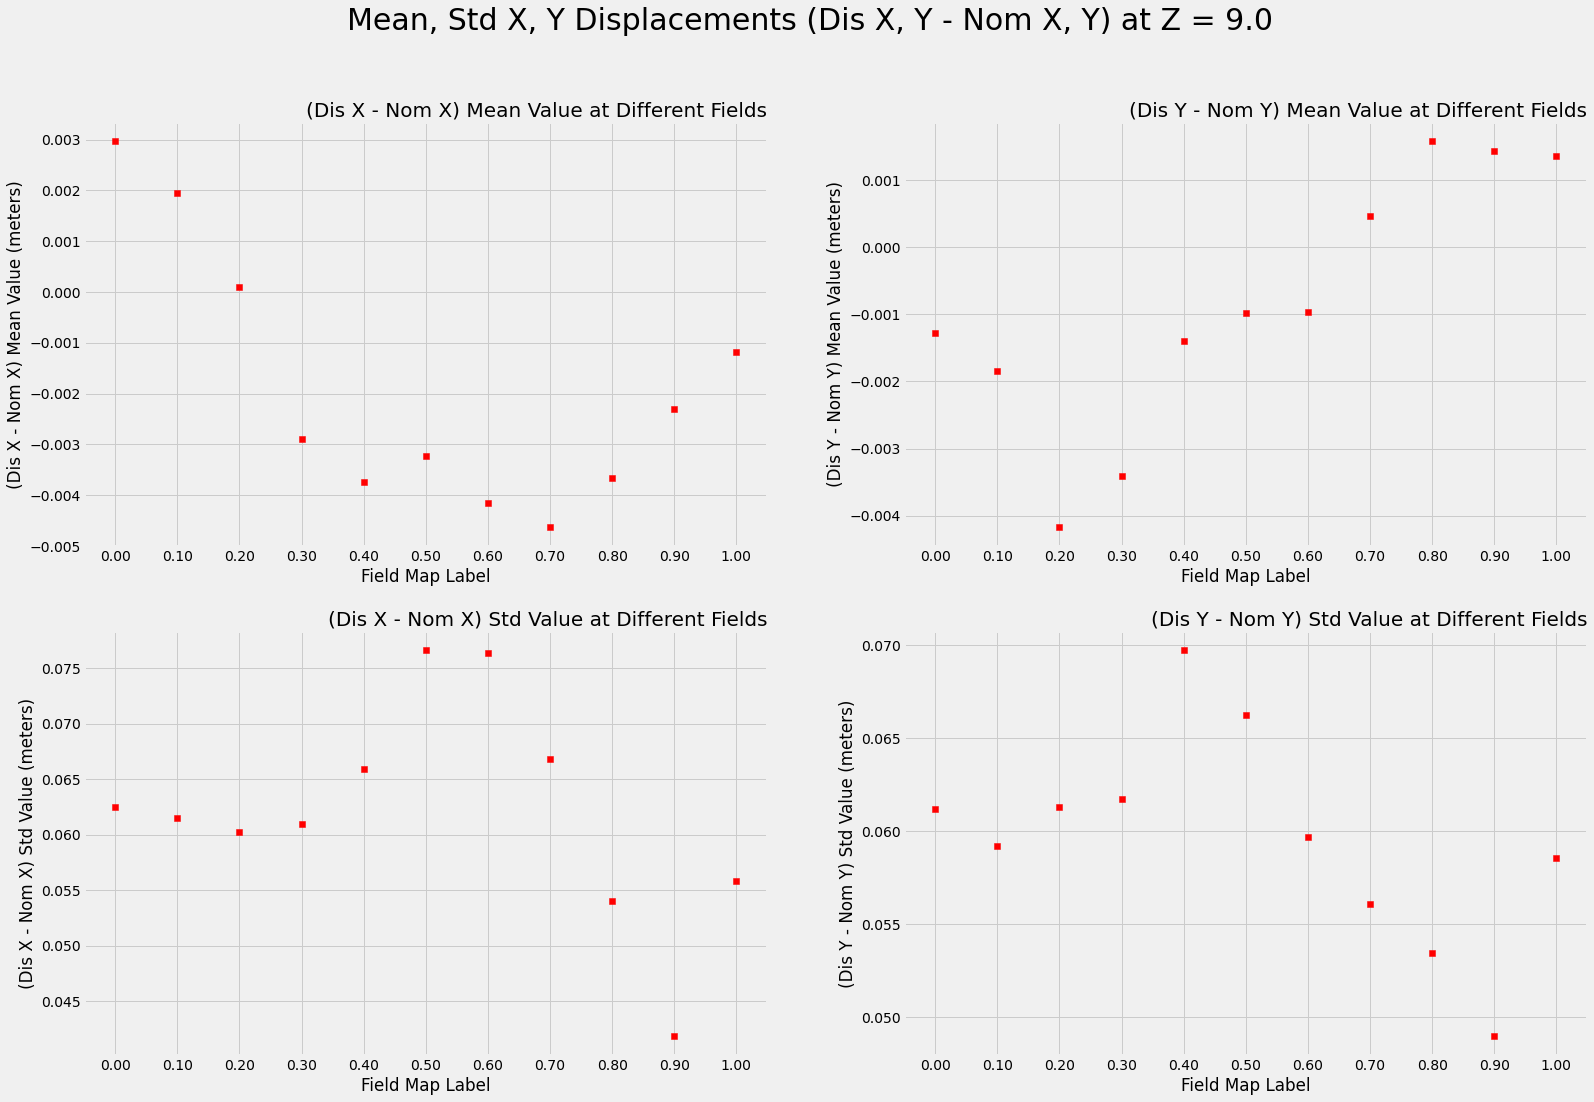

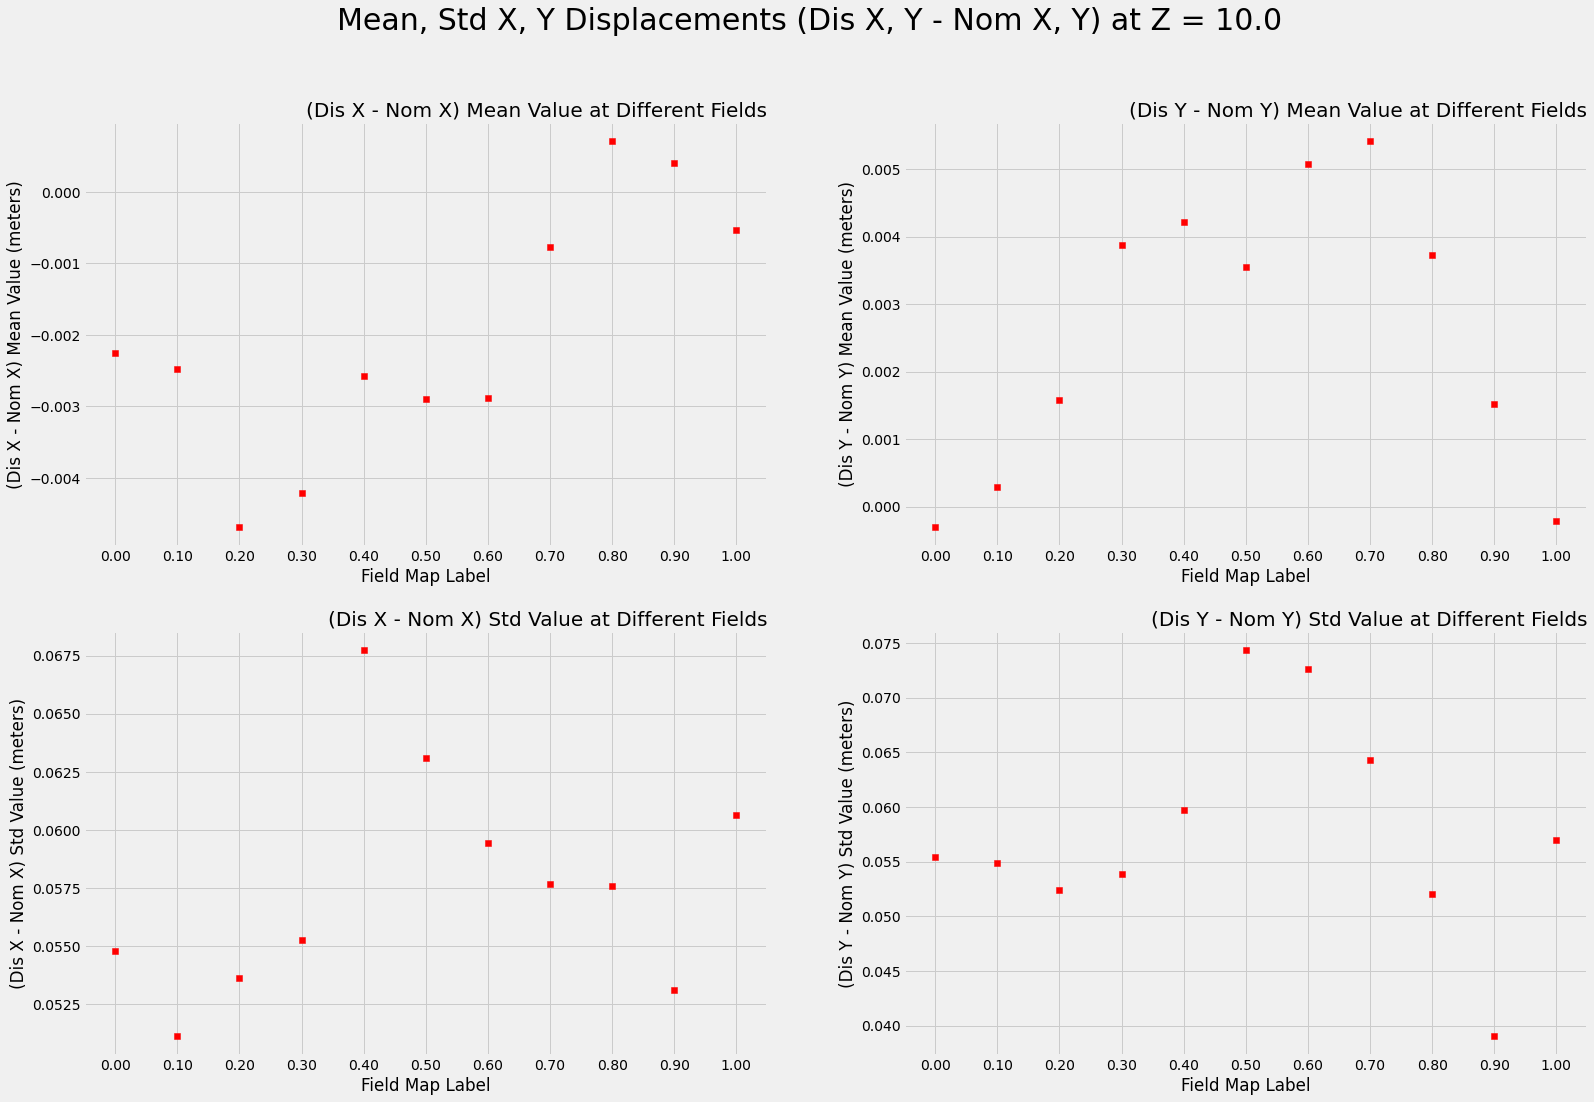

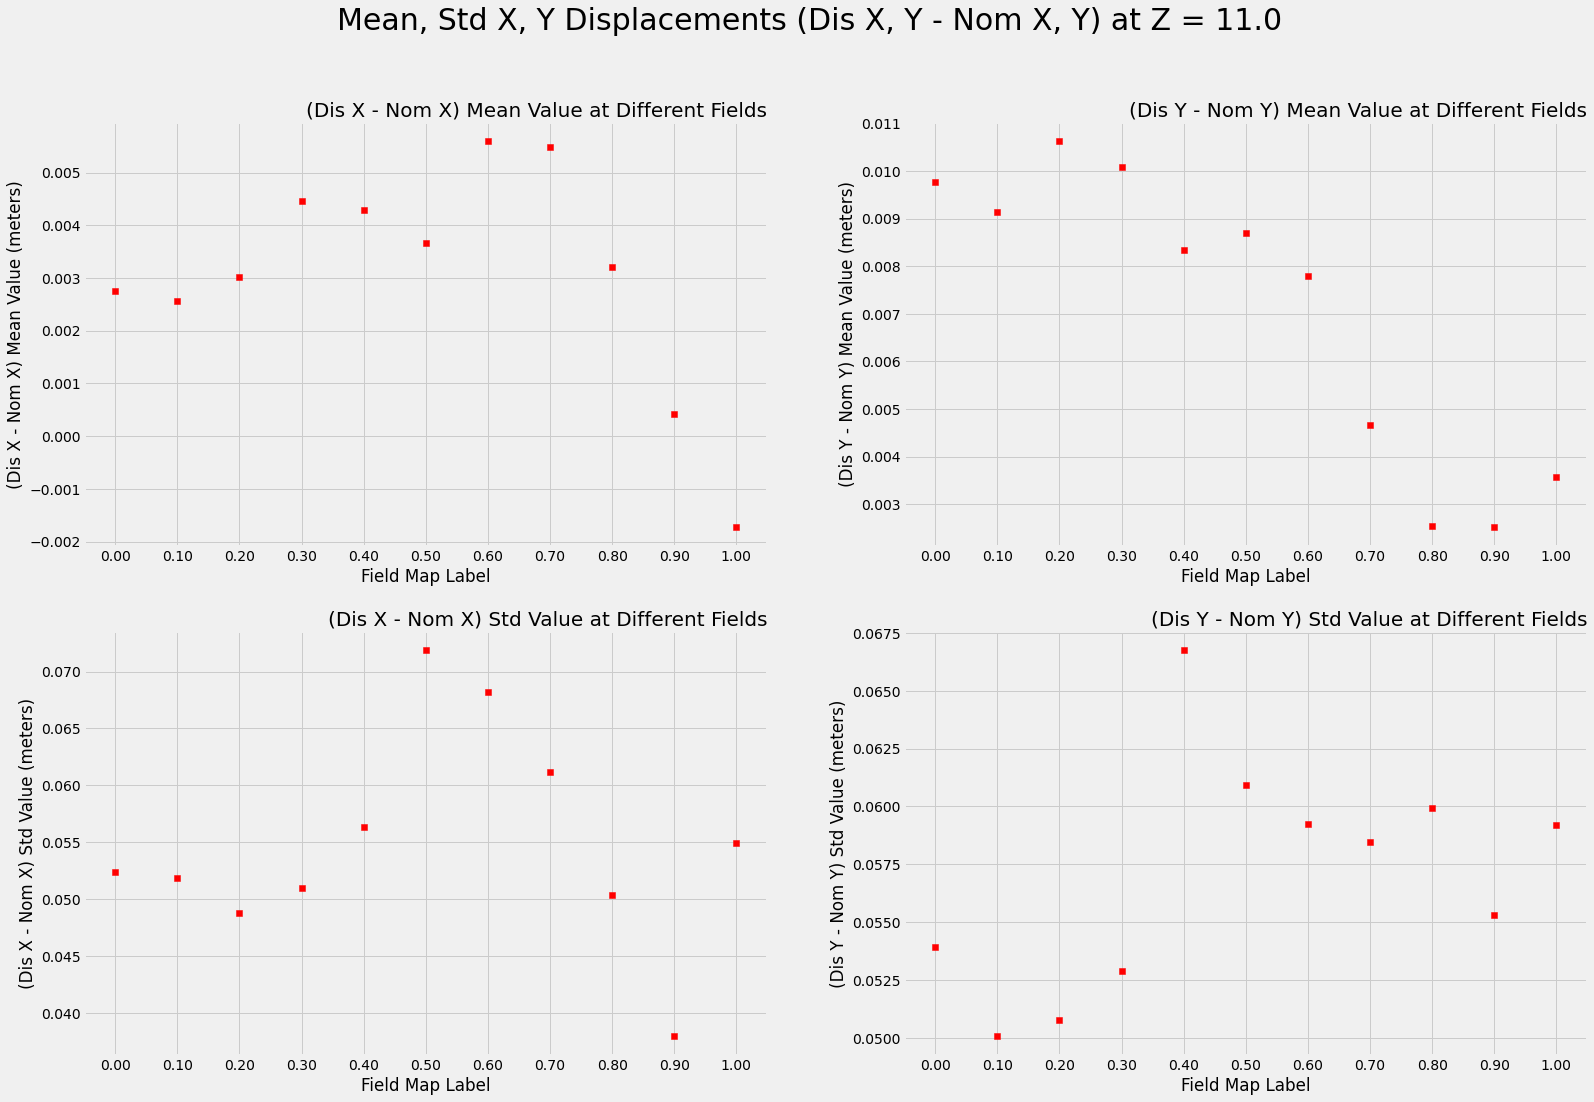

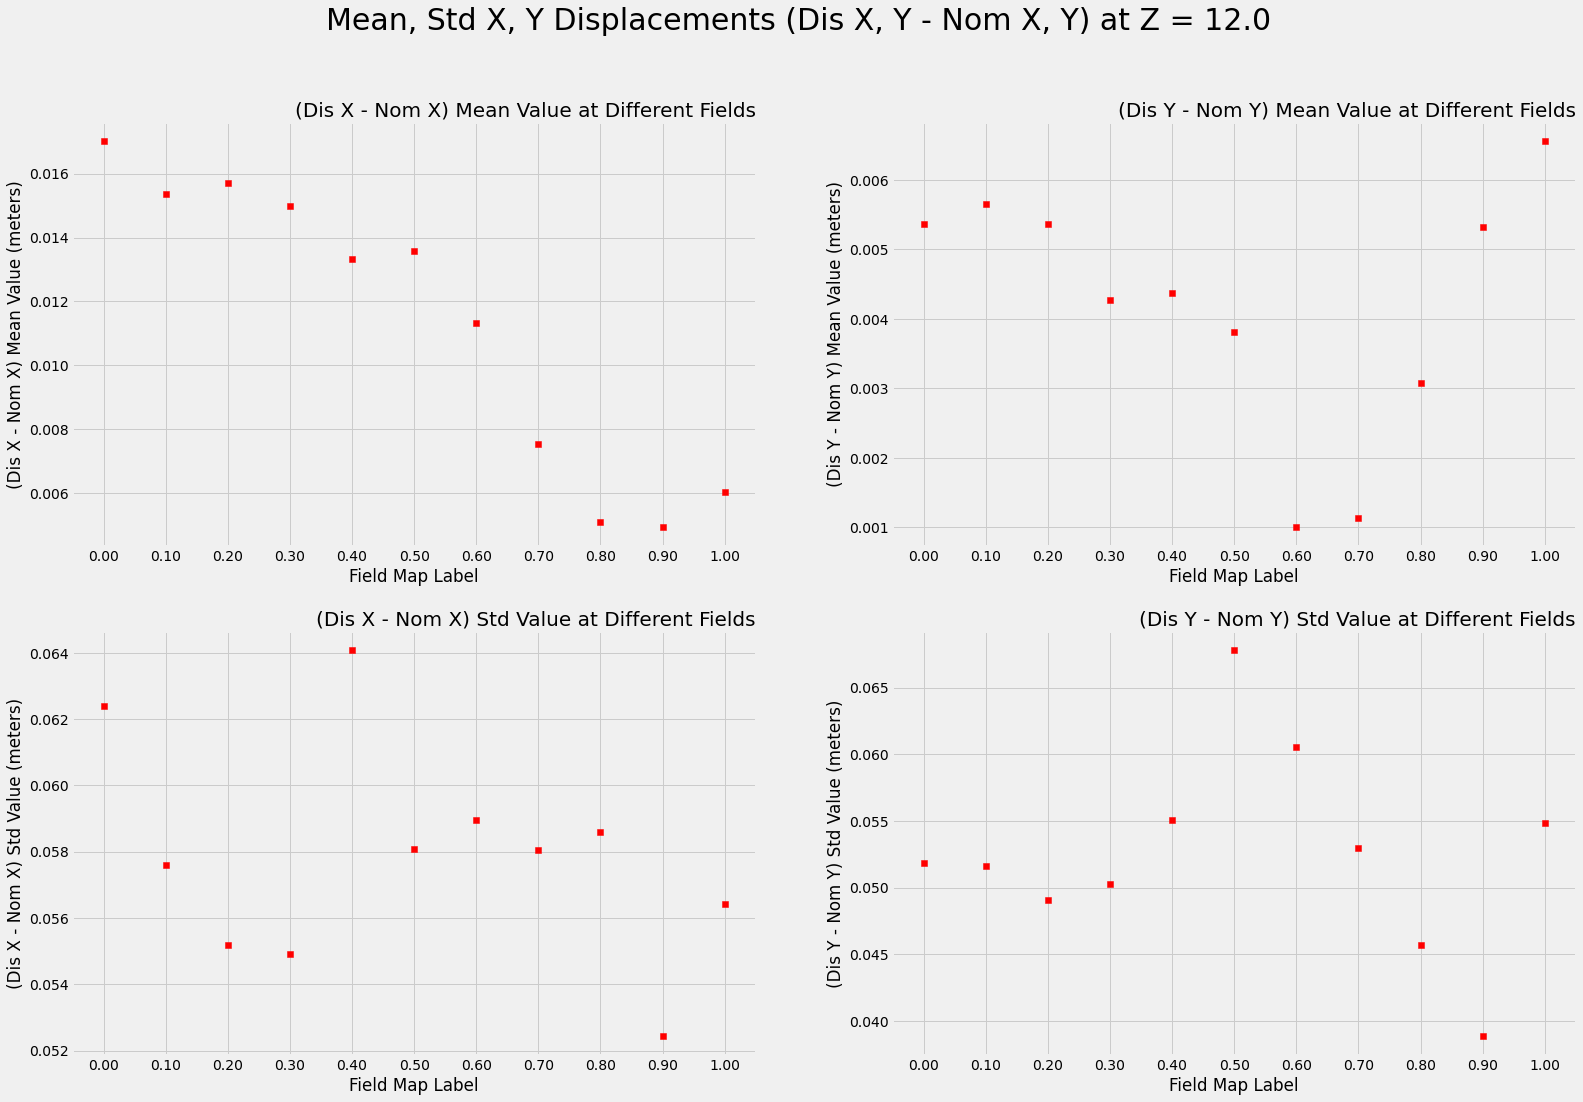

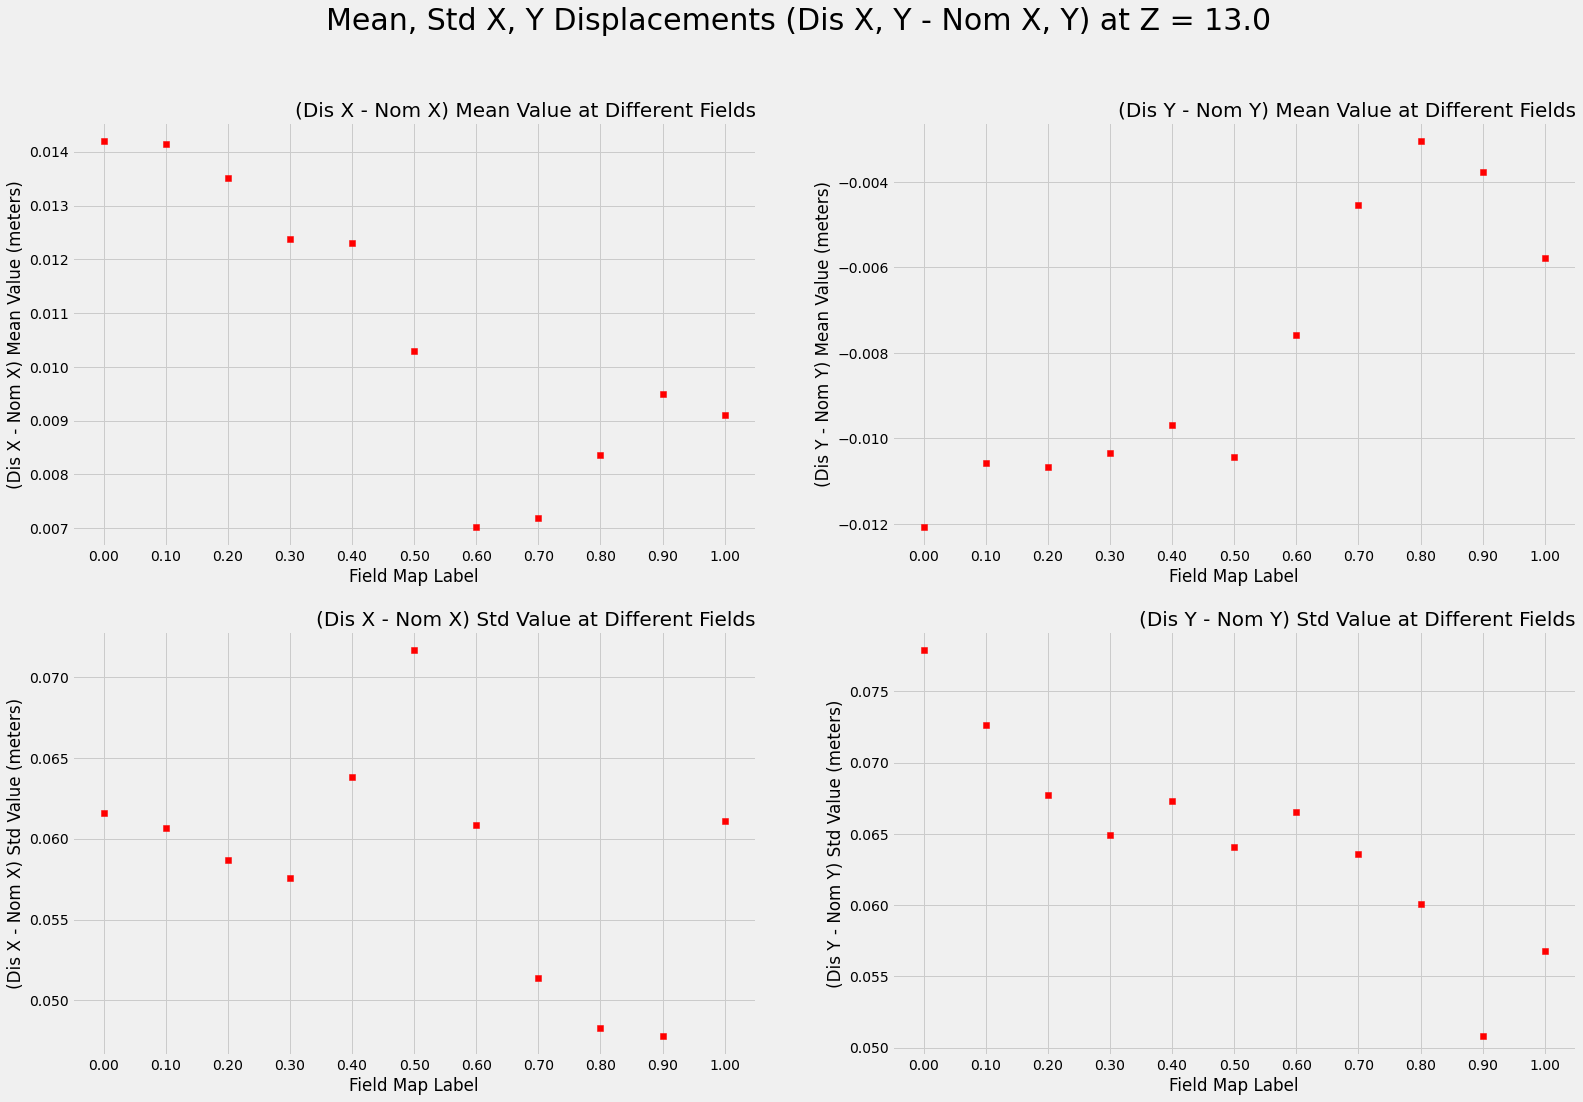

In [51]:
for z in zvals:
    makeplots(msdf, z)

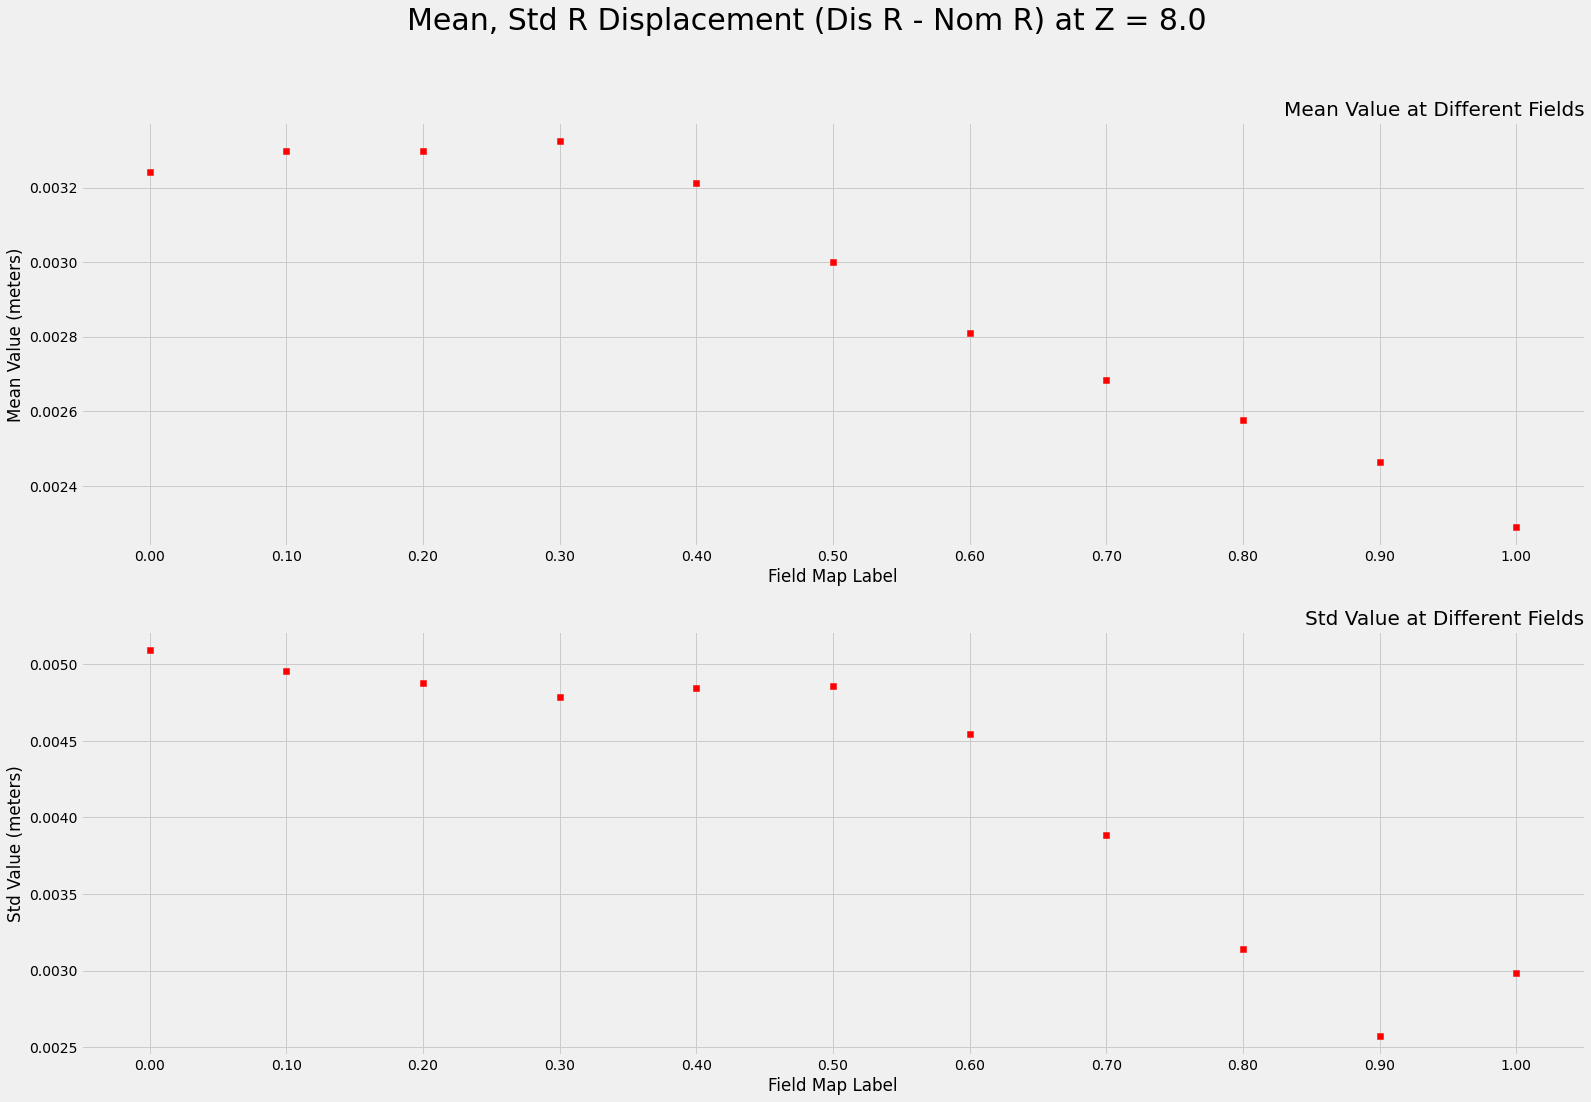

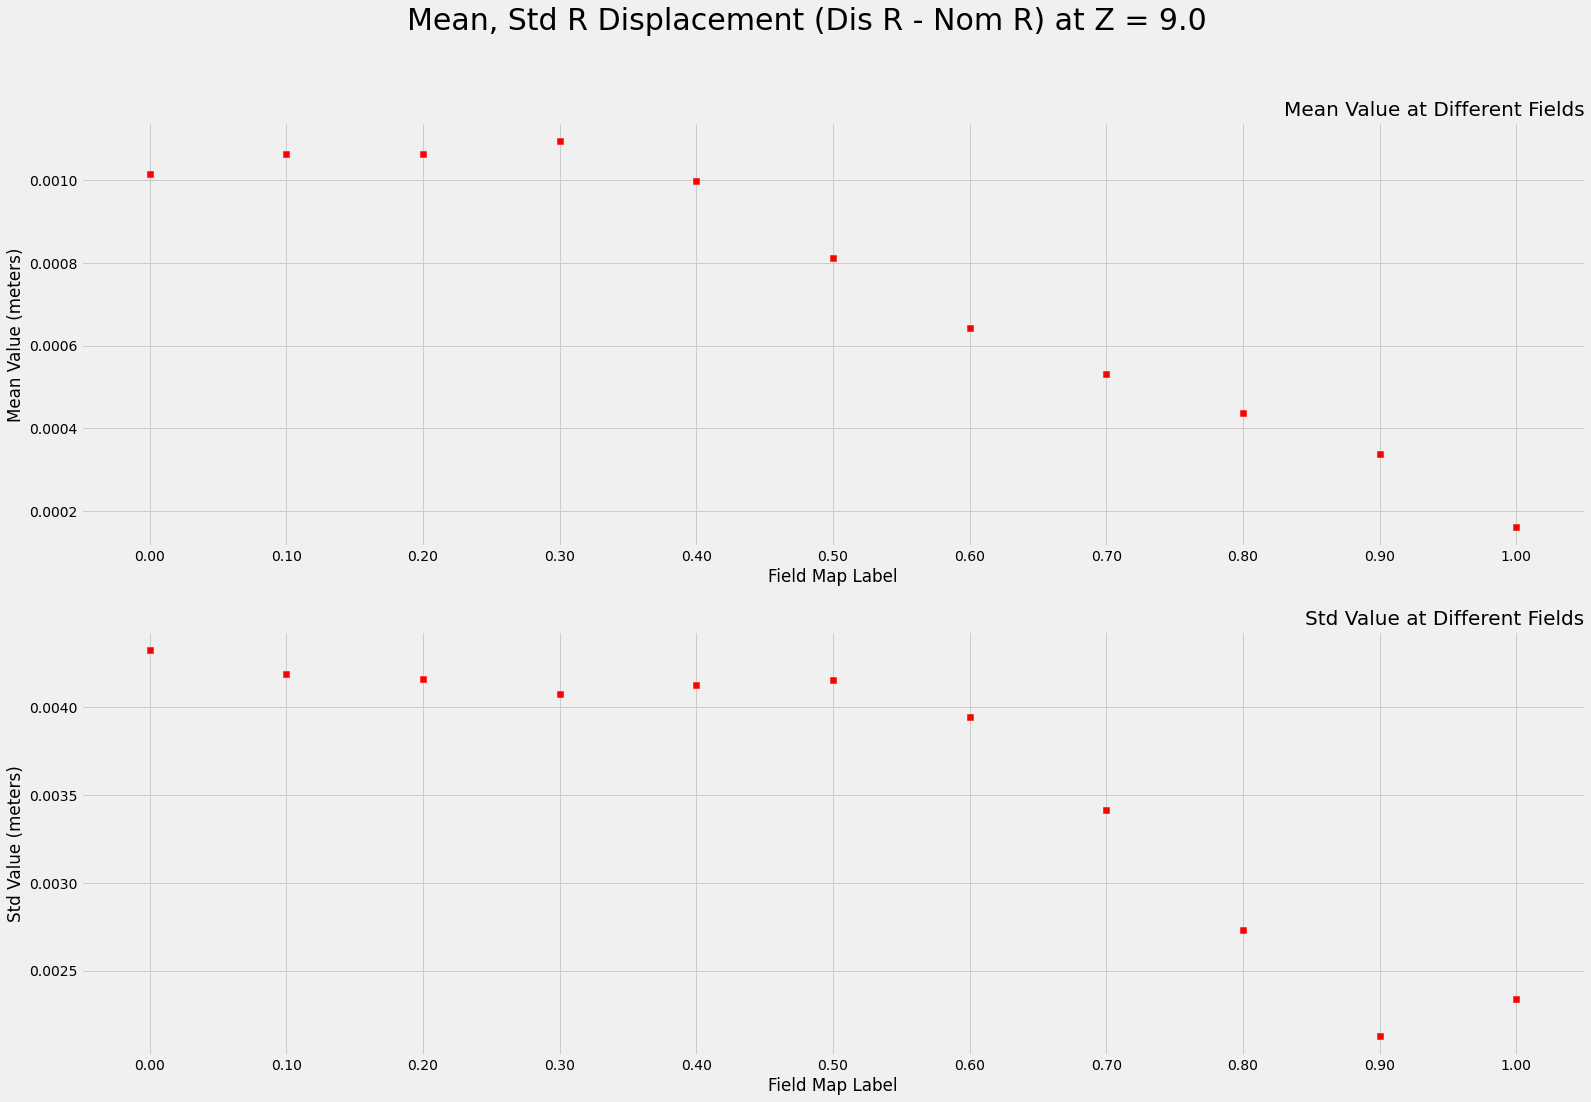

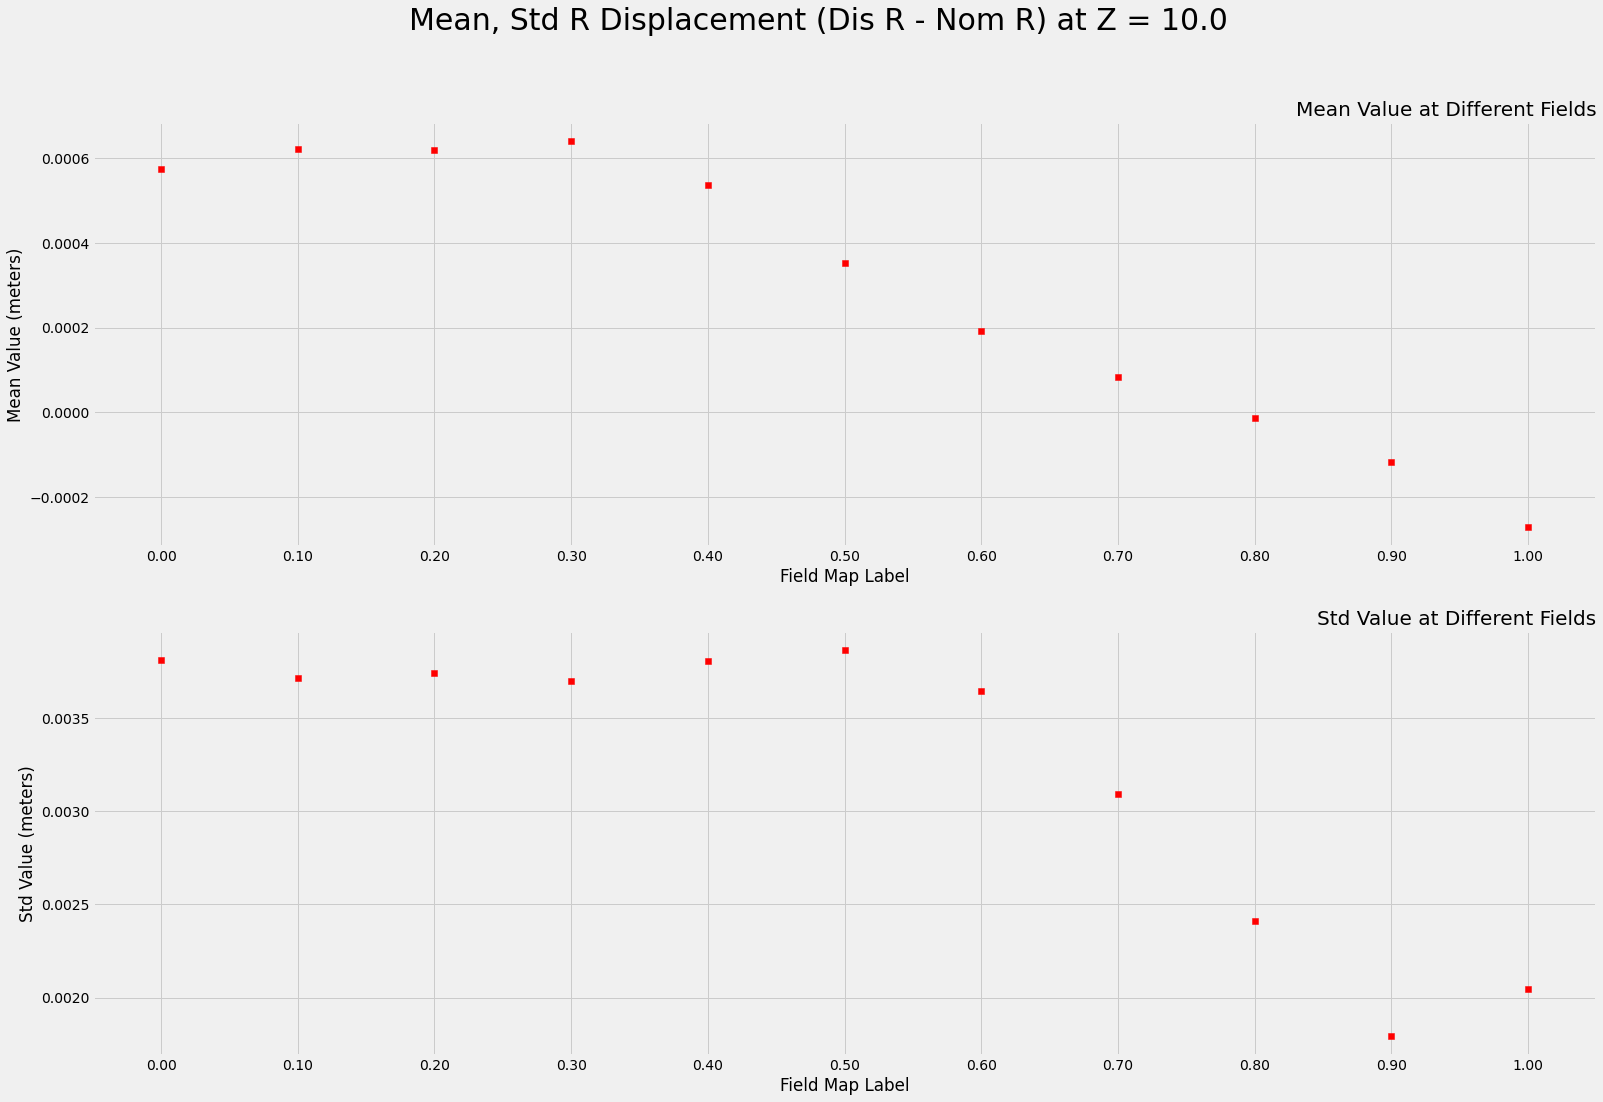

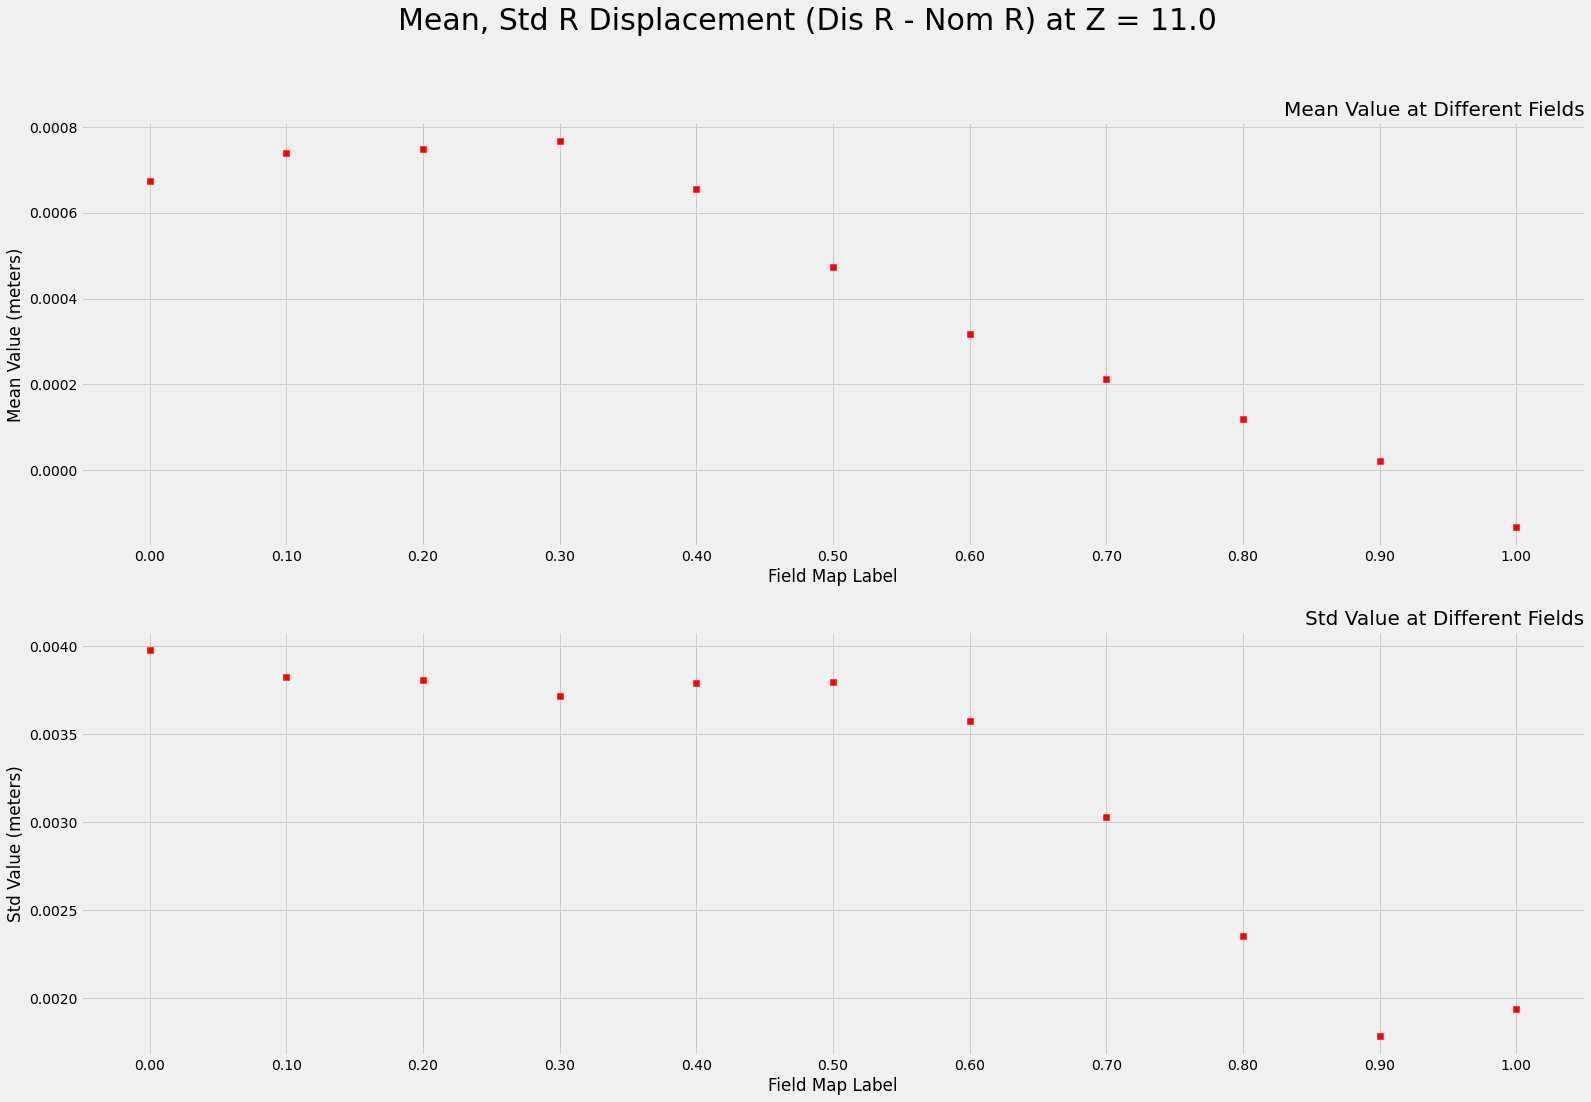

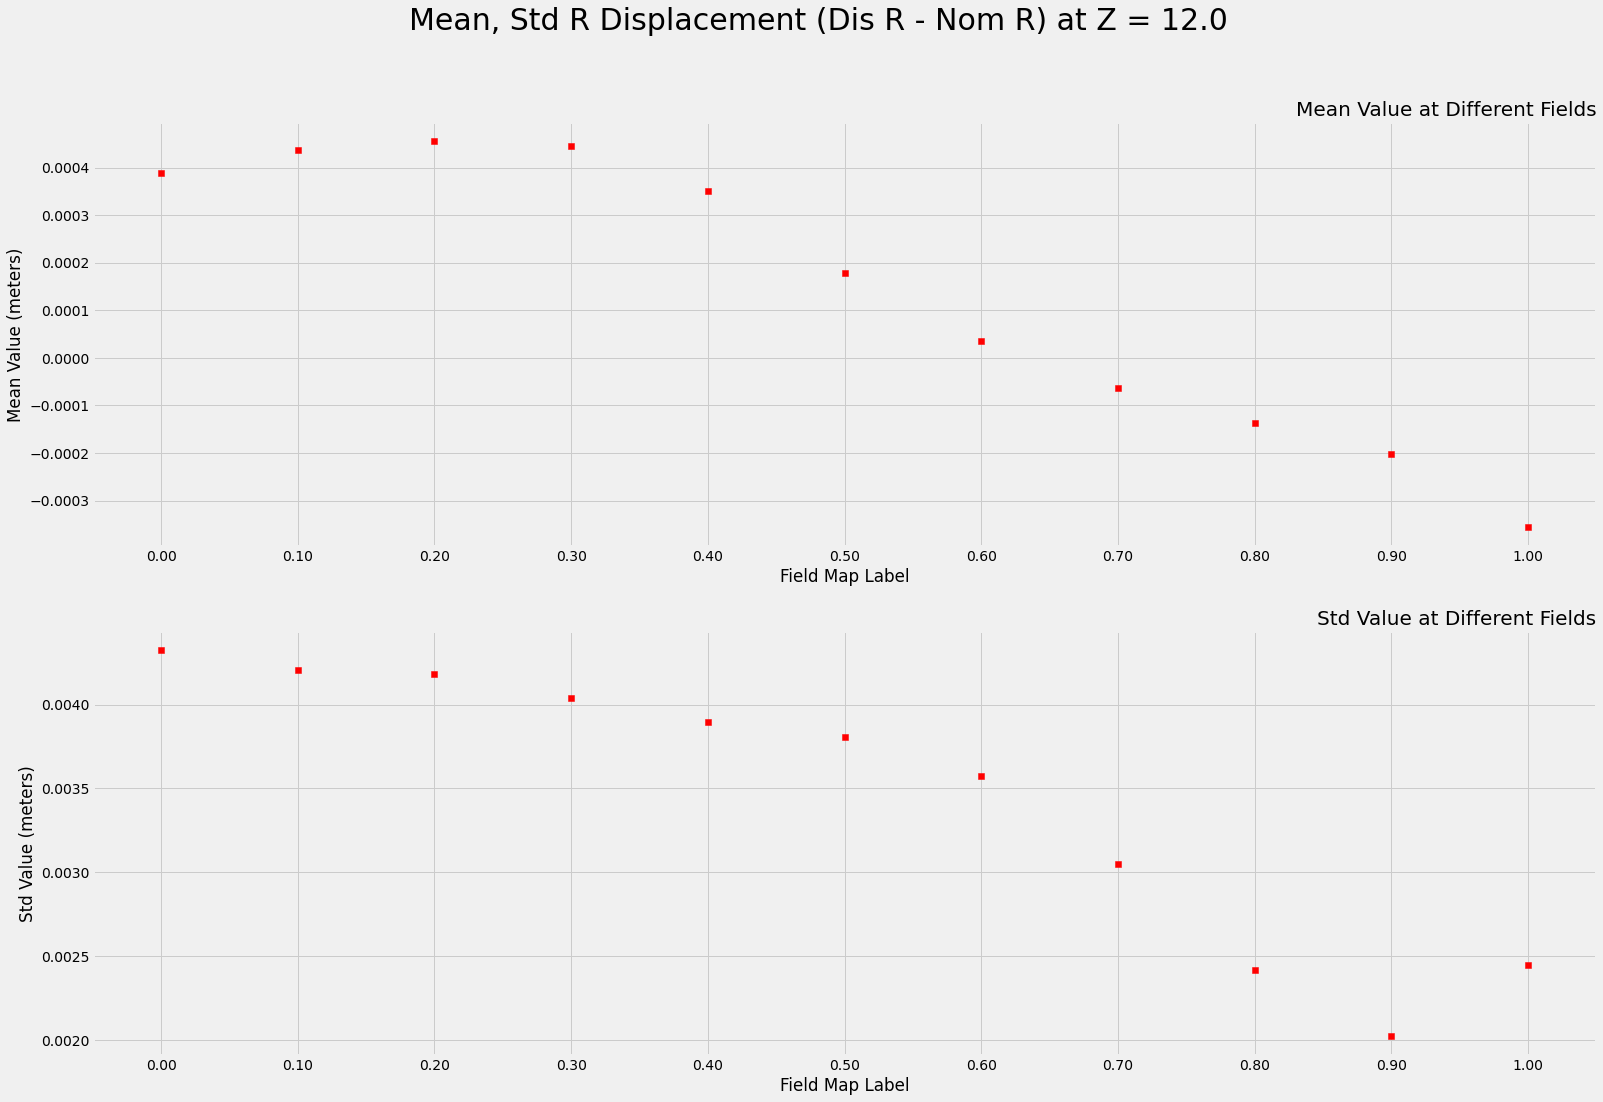

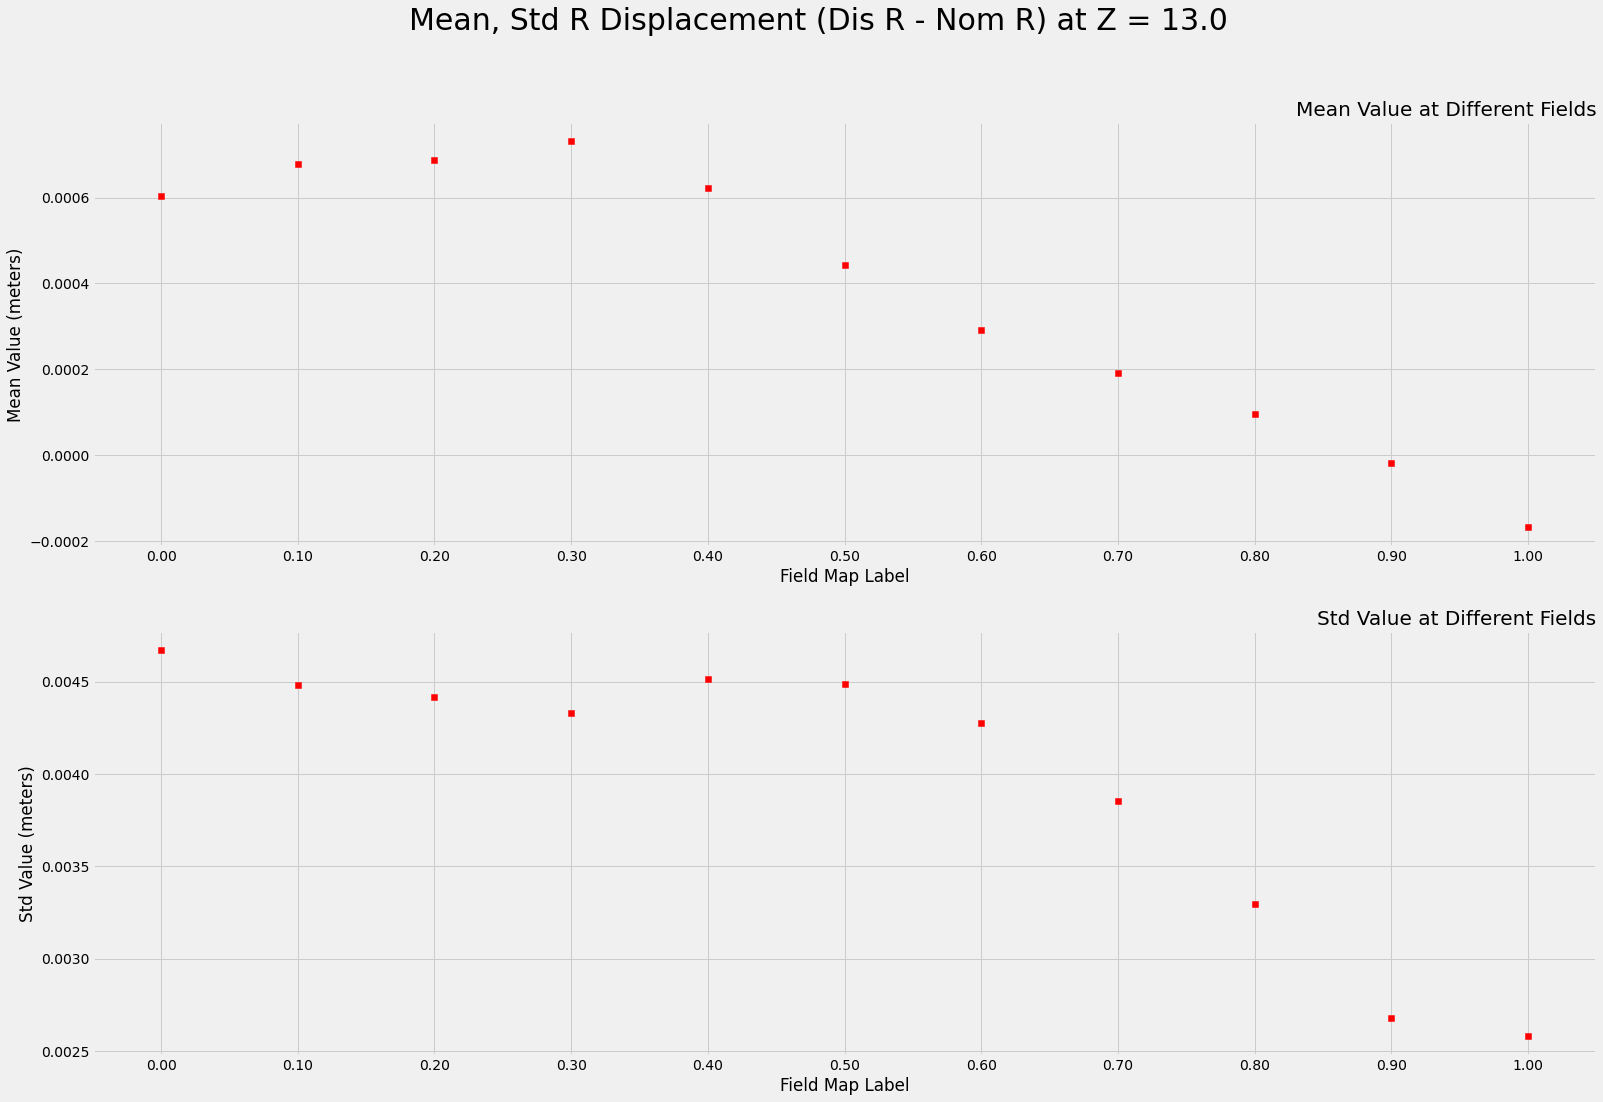

In [30]:
for z in zvals2:
    makeplots2(msdf2, z)

In [31]:
datadf

xdif          ydif     z field     theta
0       3.157526e-08 -2.426140e-08   6.0  0.00  0.000000
1       3.157526e-08 -2.426140e-08   6.0  0.00  0.000000
2       3.157526e-08 -2.426140e-08   6.0  0.00  0.000000
3       3.157526e-08 -2.426140e-08   6.0  0.00  0.000000
4       3.157526e-08 -2.426140e-08   6.0  0.00  0.000000
...              ...           ...   ...   ...       ...
398795 -6.893840e-02  3.681815e-01  13.0  1.00  1.923424
398796 -1.888878e-01  3.415068e-01  13.0  1.00  1.923424
398797 -1.843332e-01  1.560340e-01  13.0  1.00  1.923424
398798  9.844136e-02 -2.295476e-02  13.0  1.00  1.923424
398799  4.020833e-01  7.317260e-02  13.0  1.00  1.923424

[398800 rows x 5 columns]

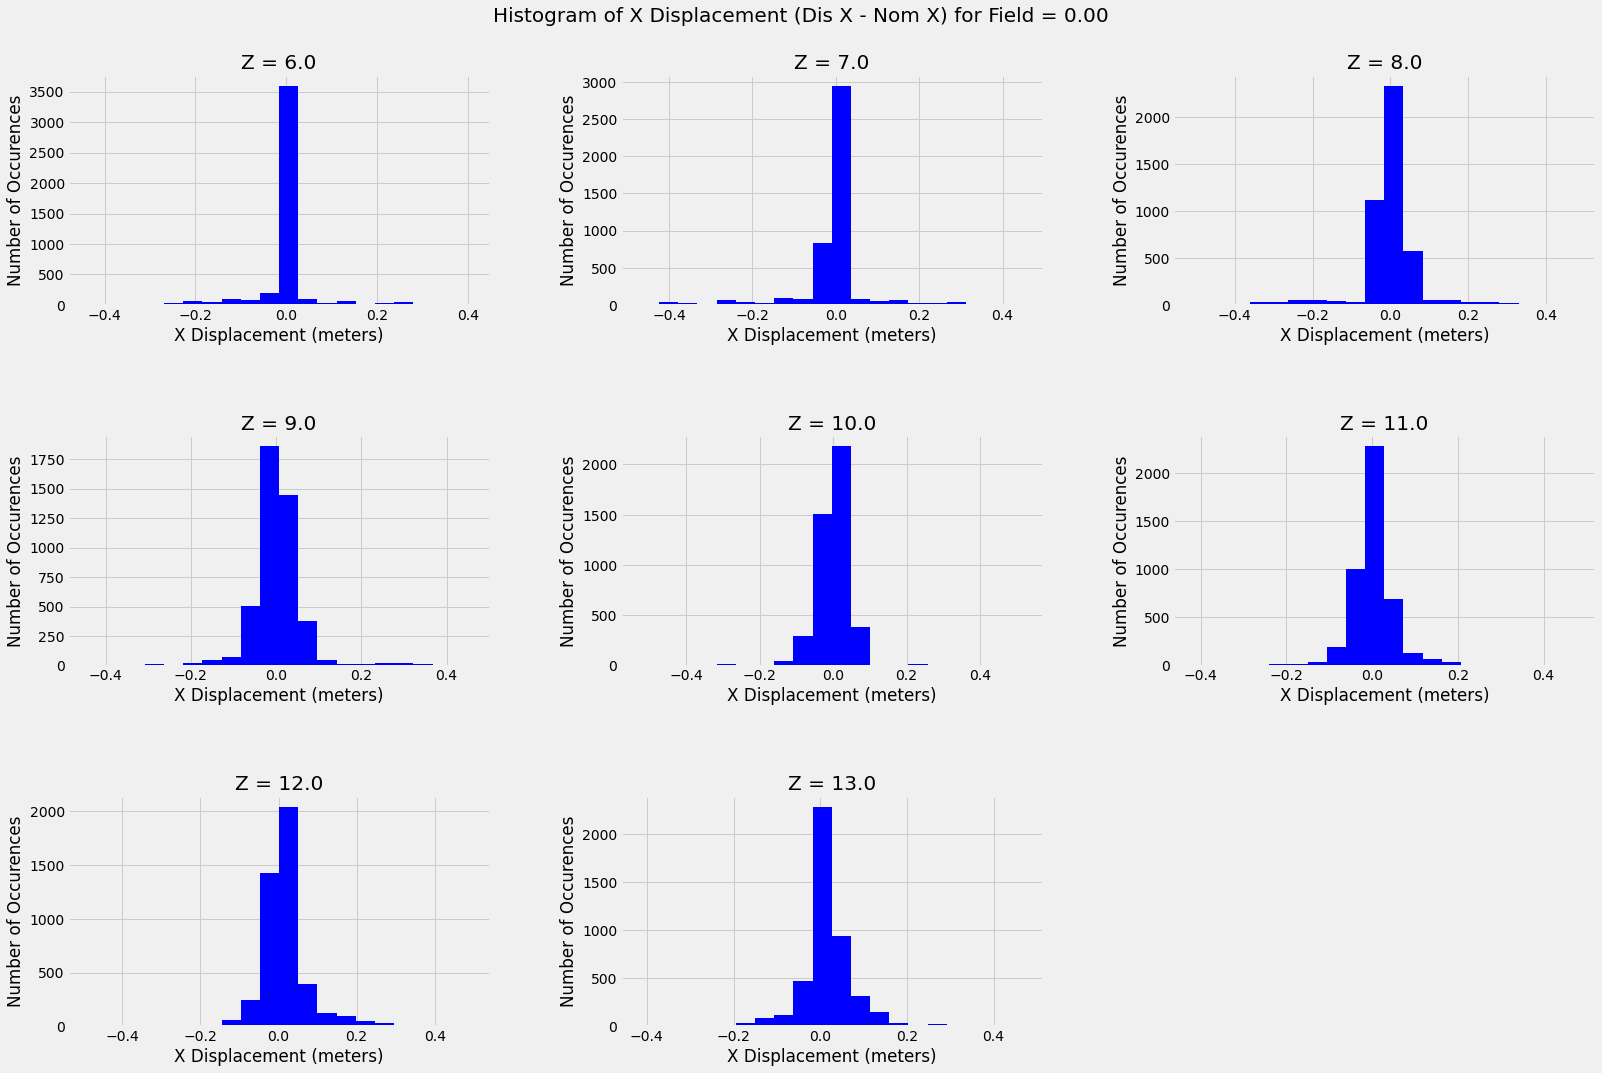

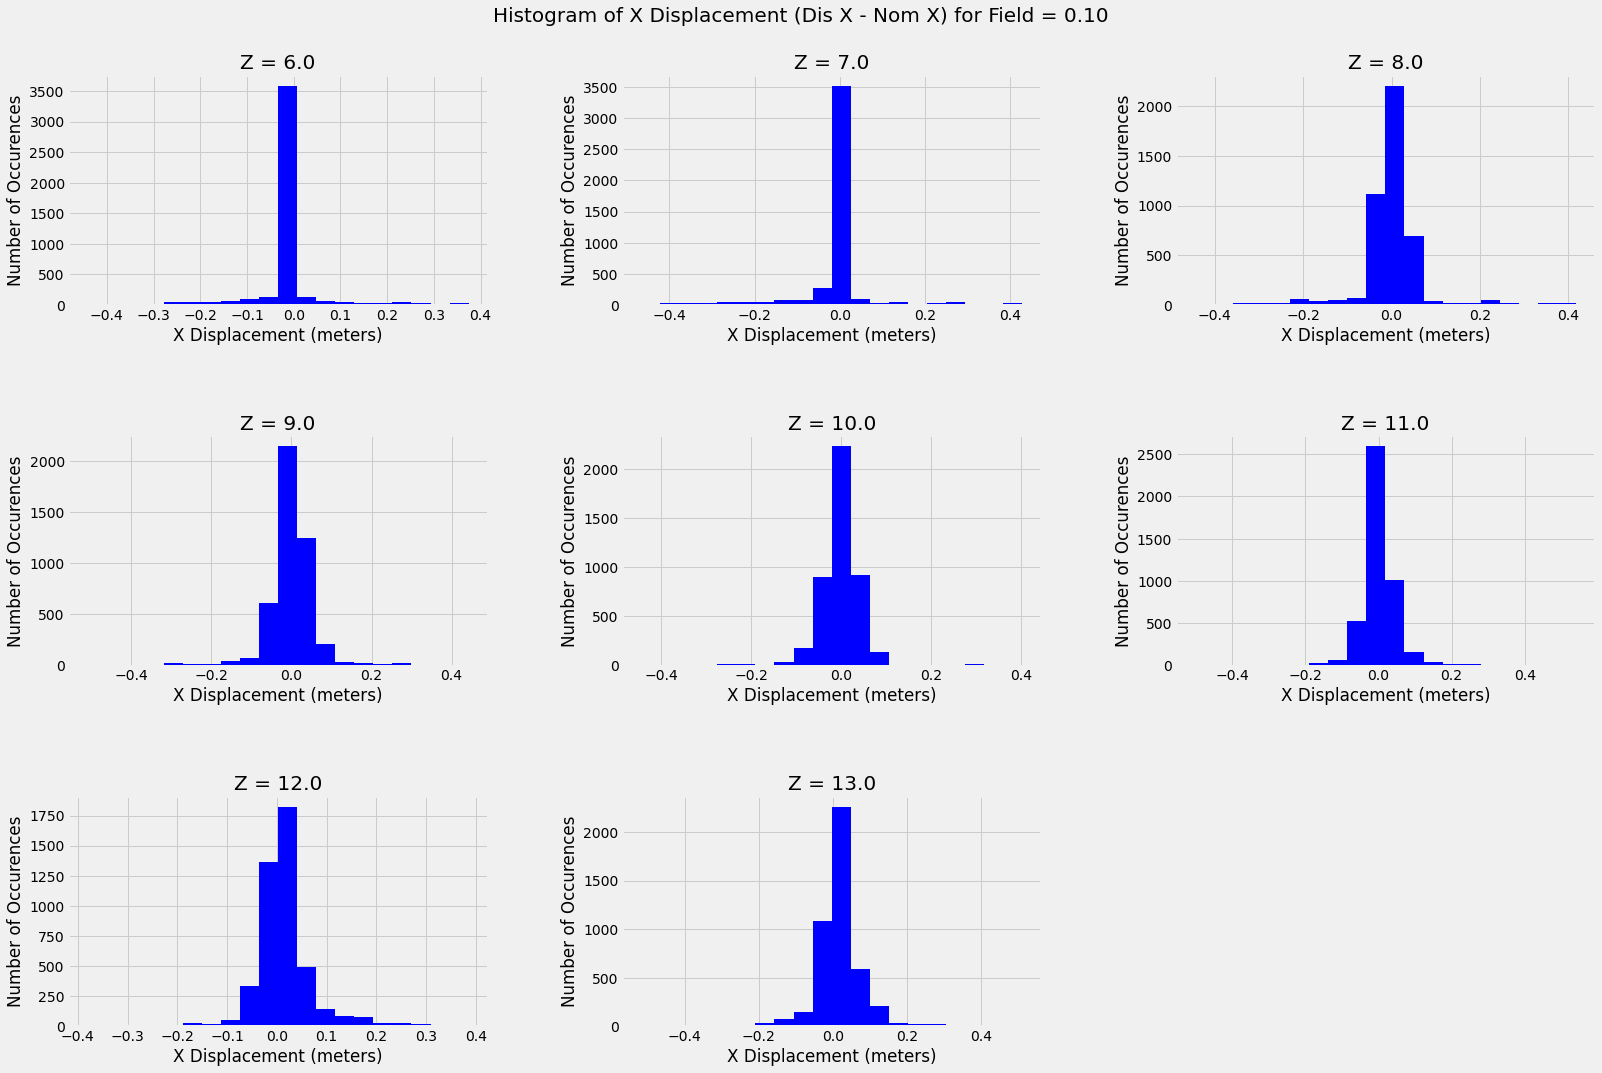

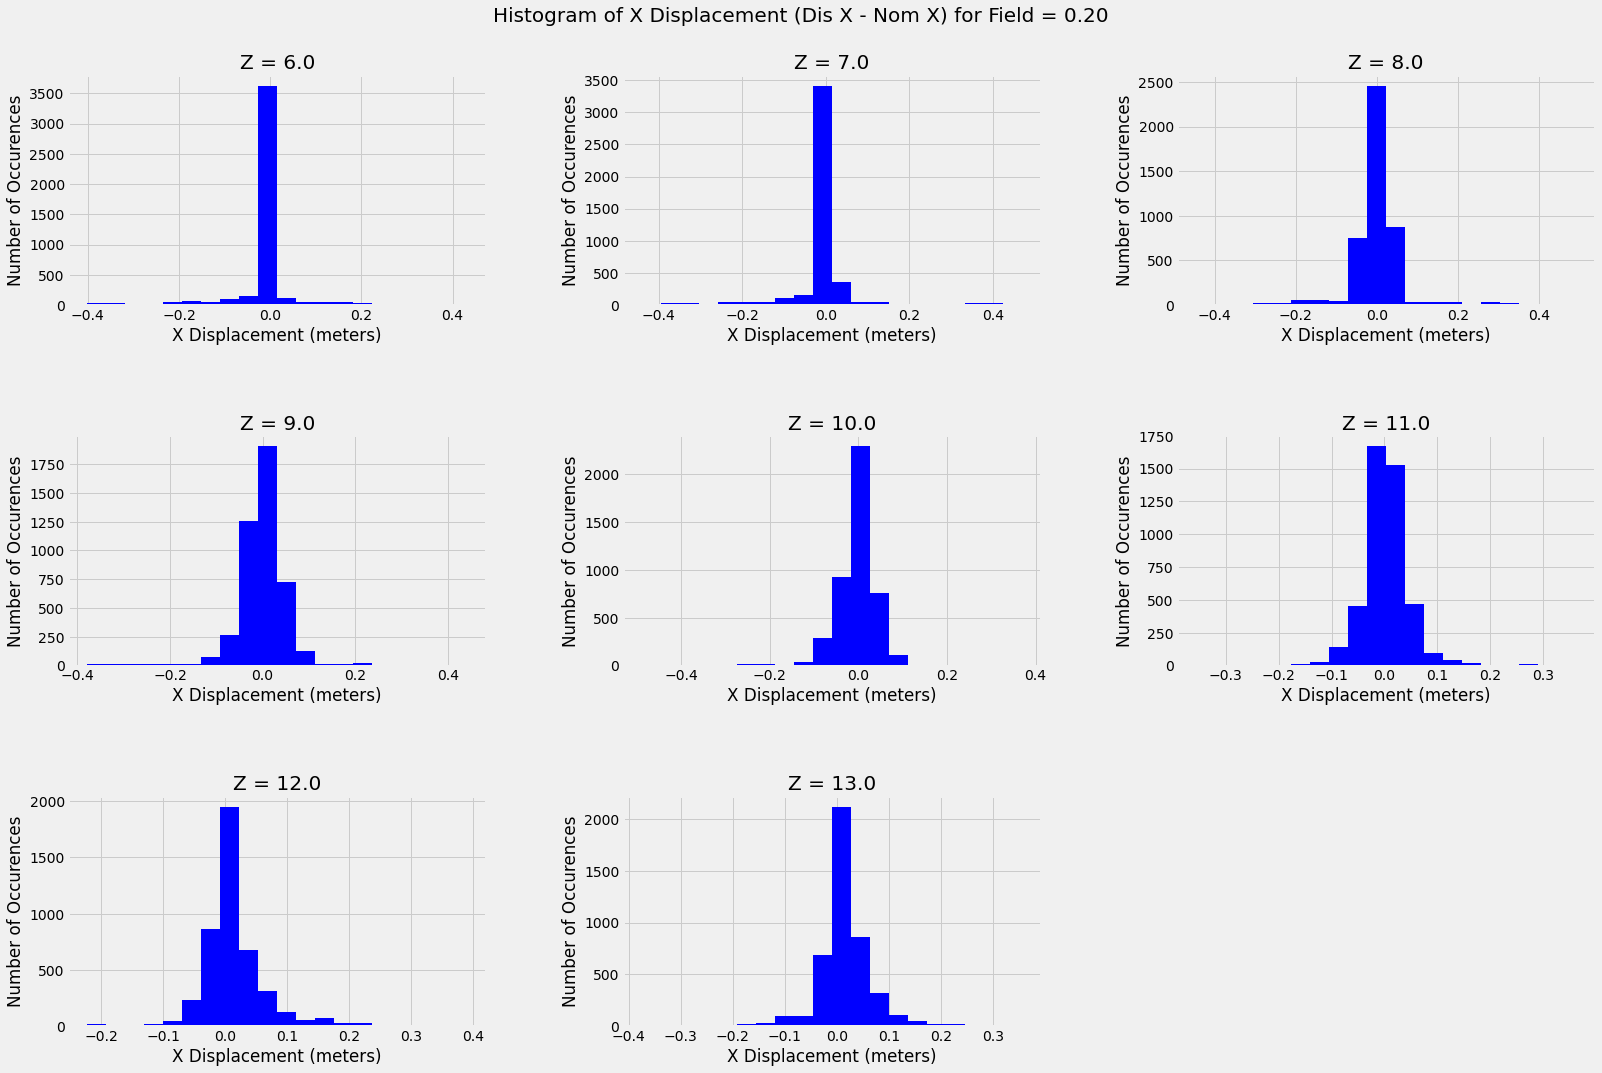

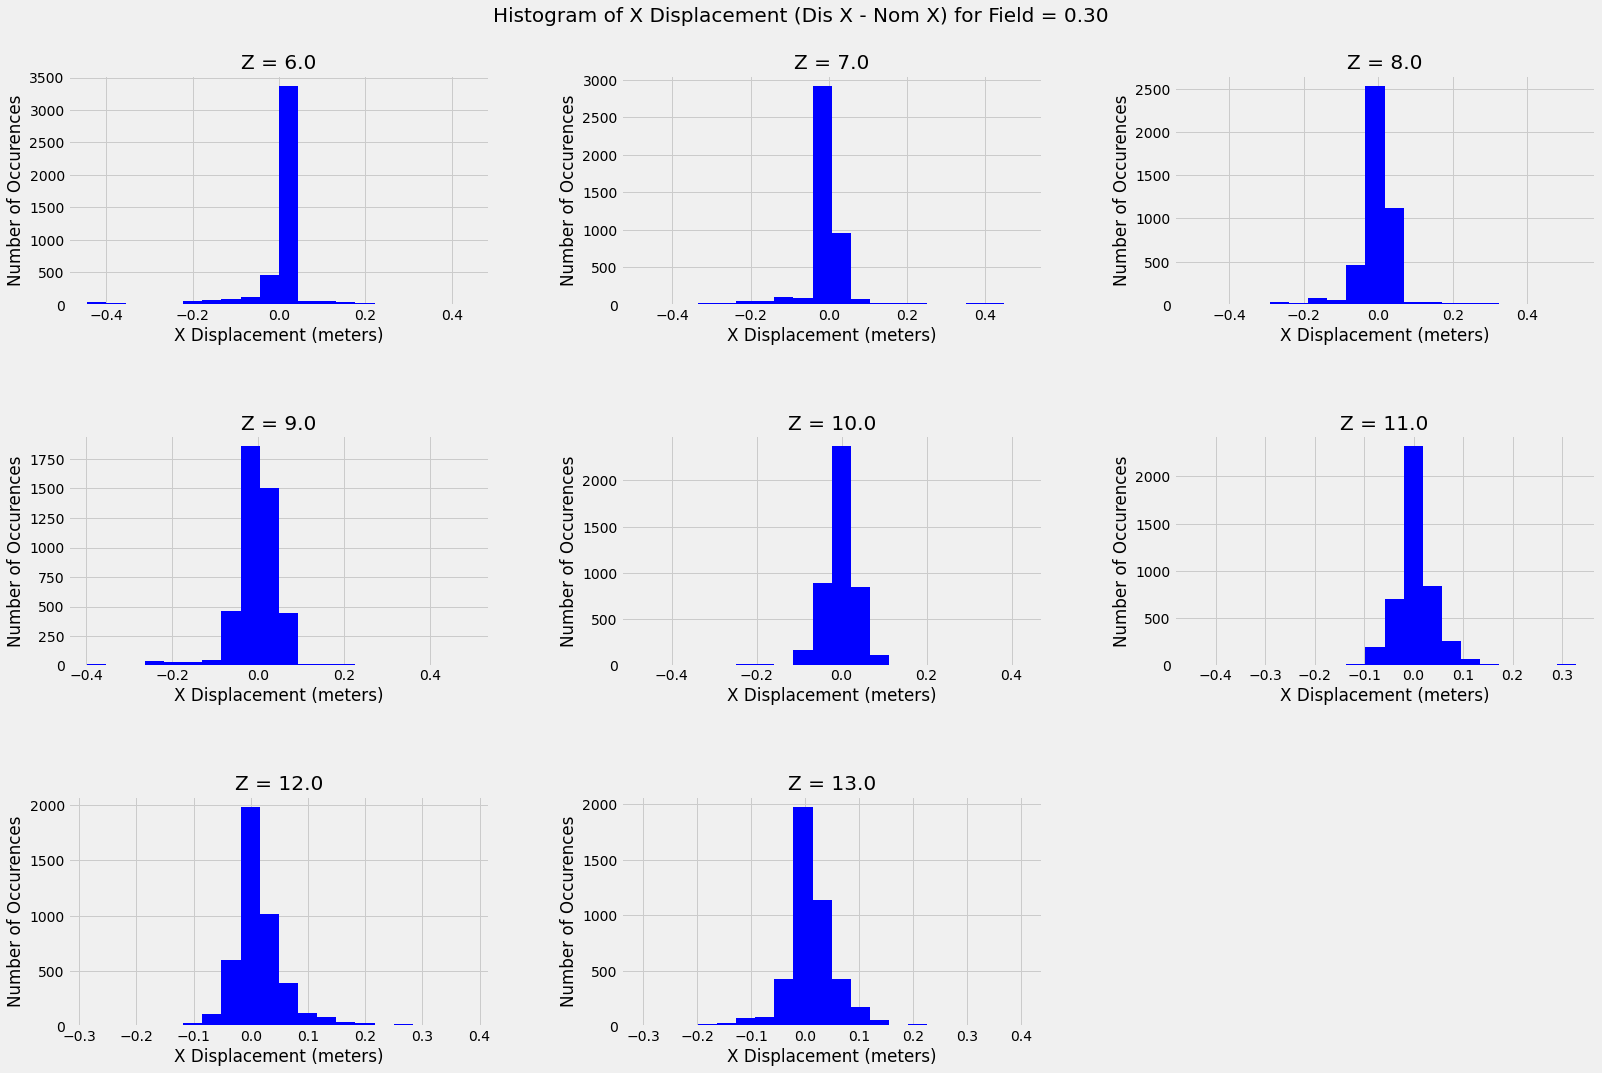

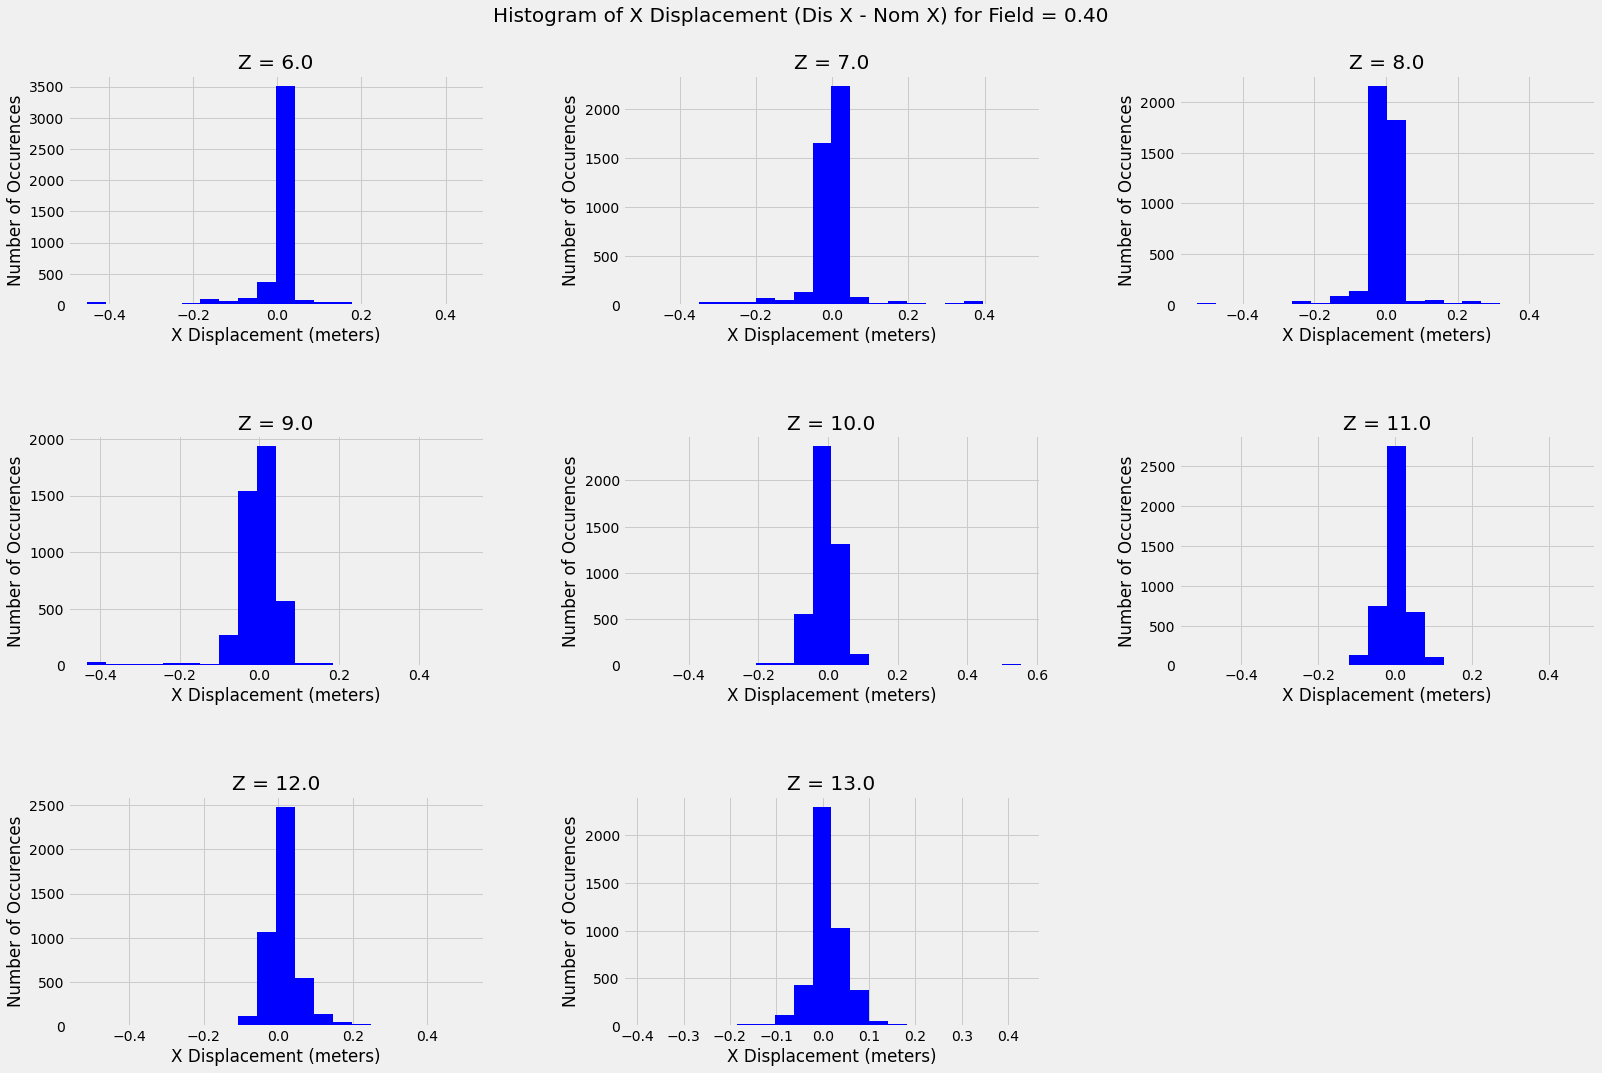

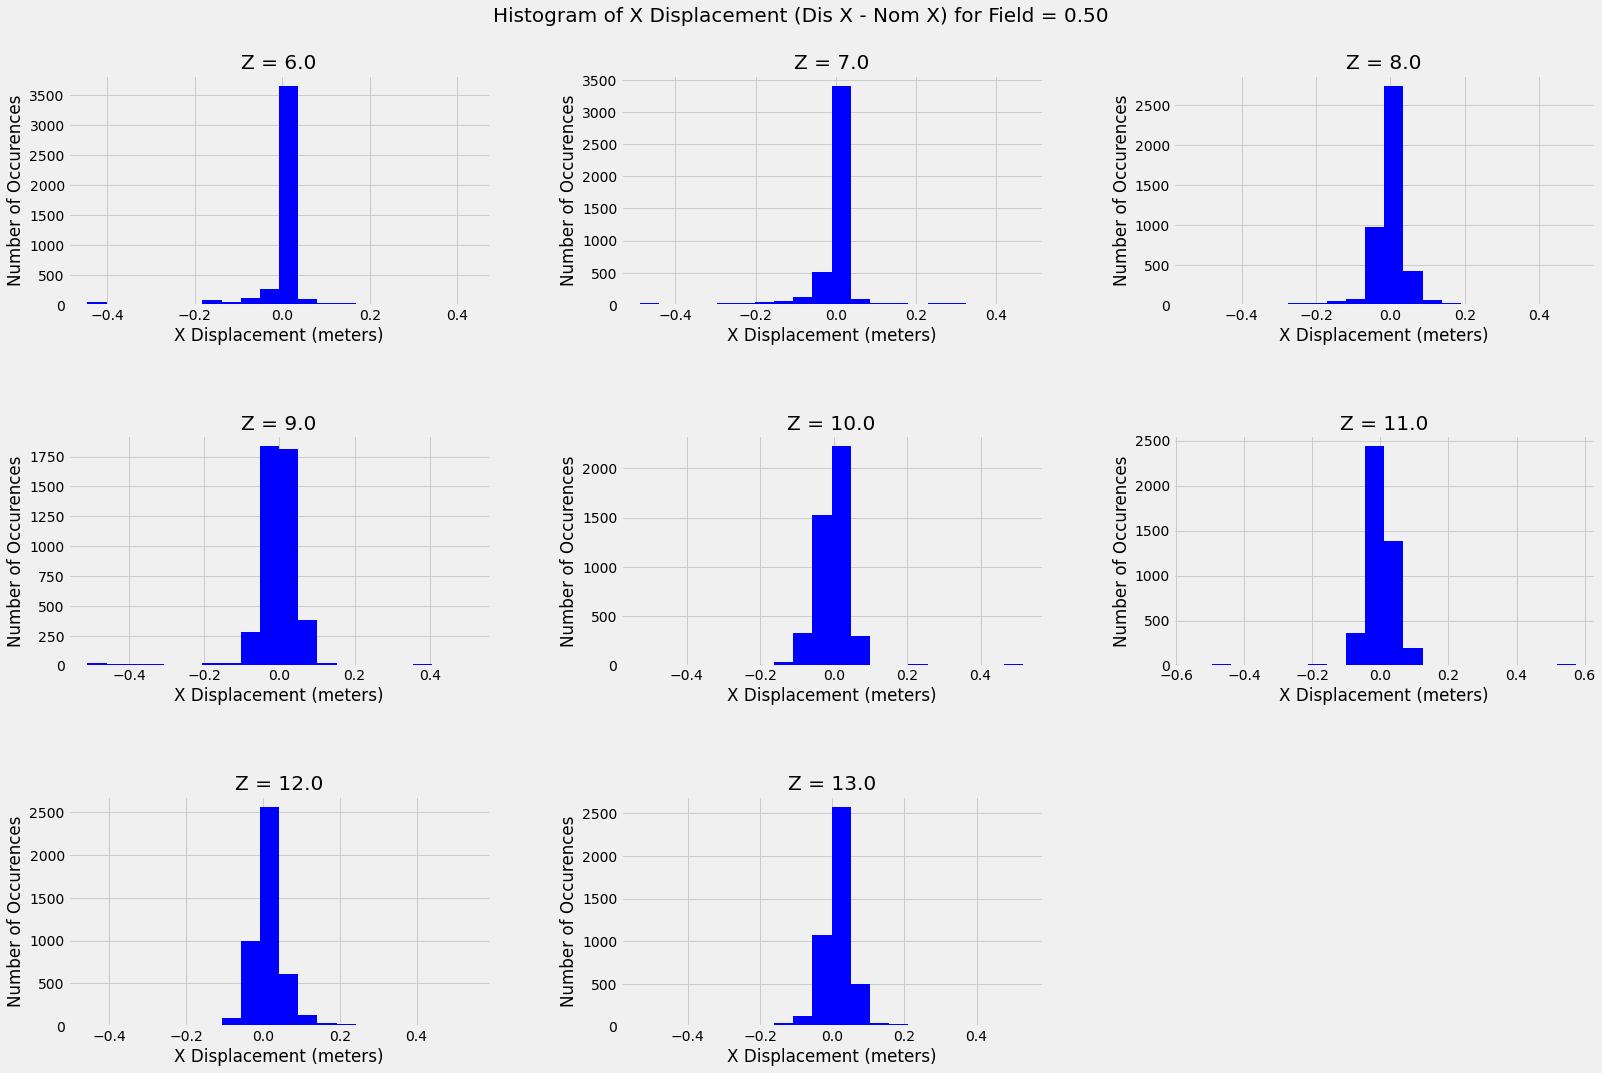

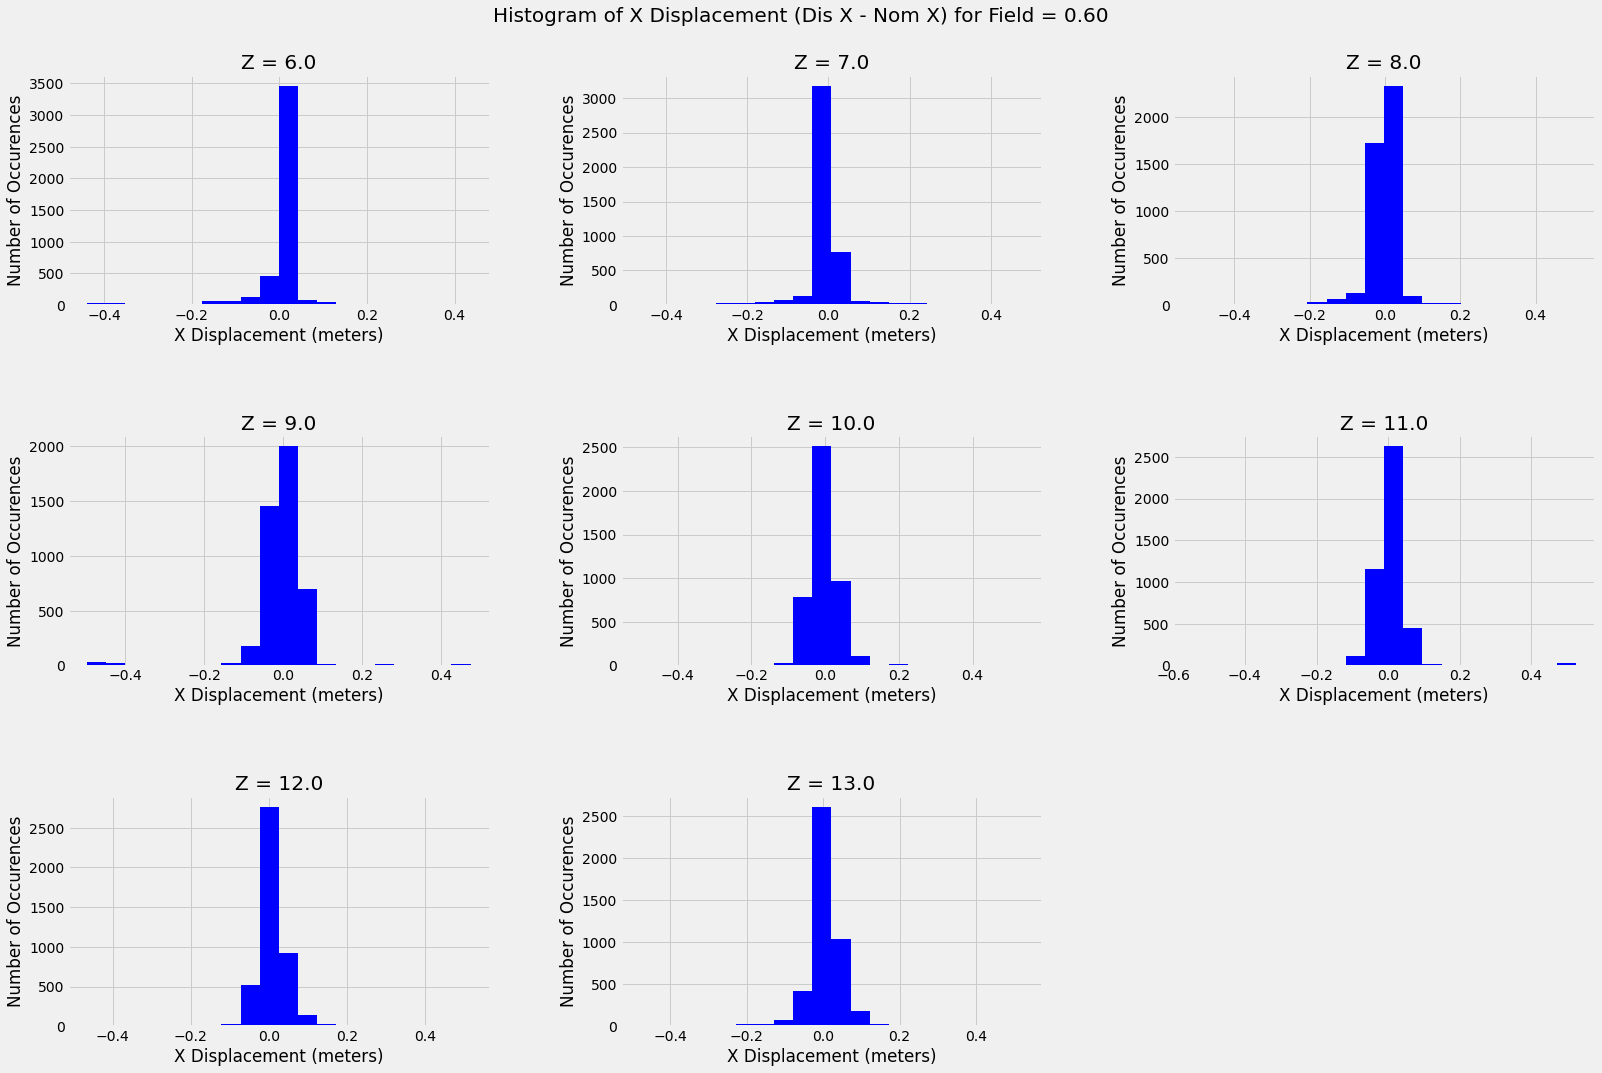

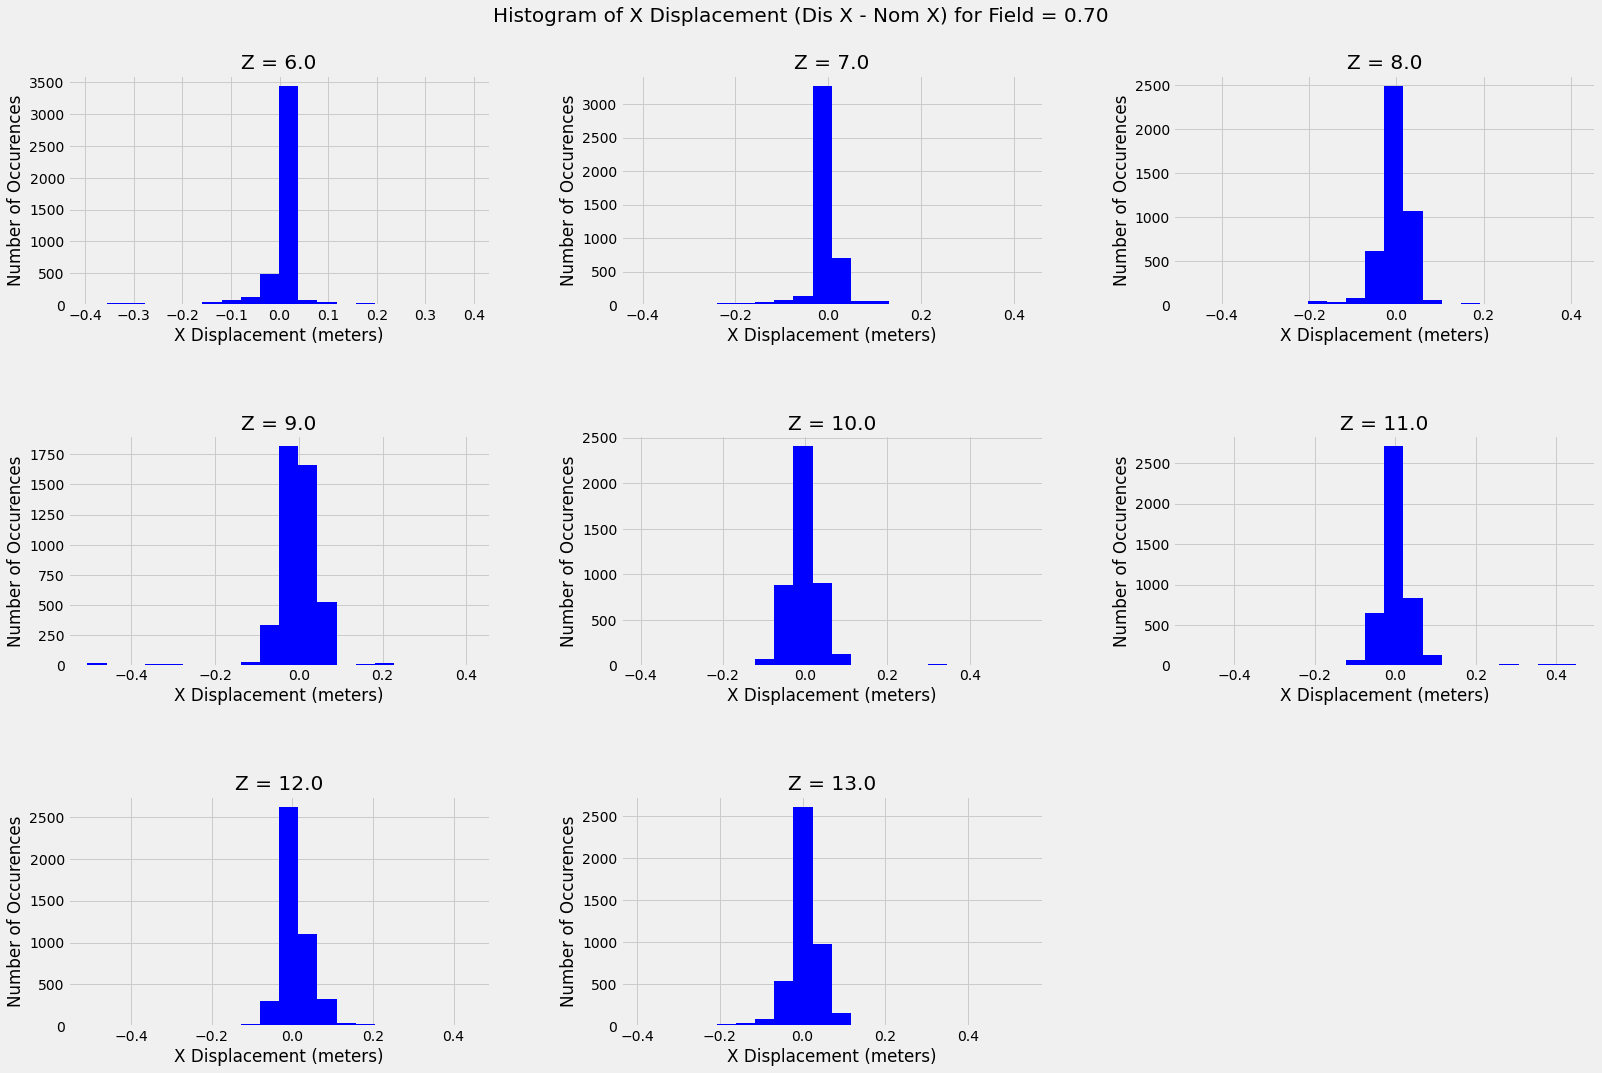

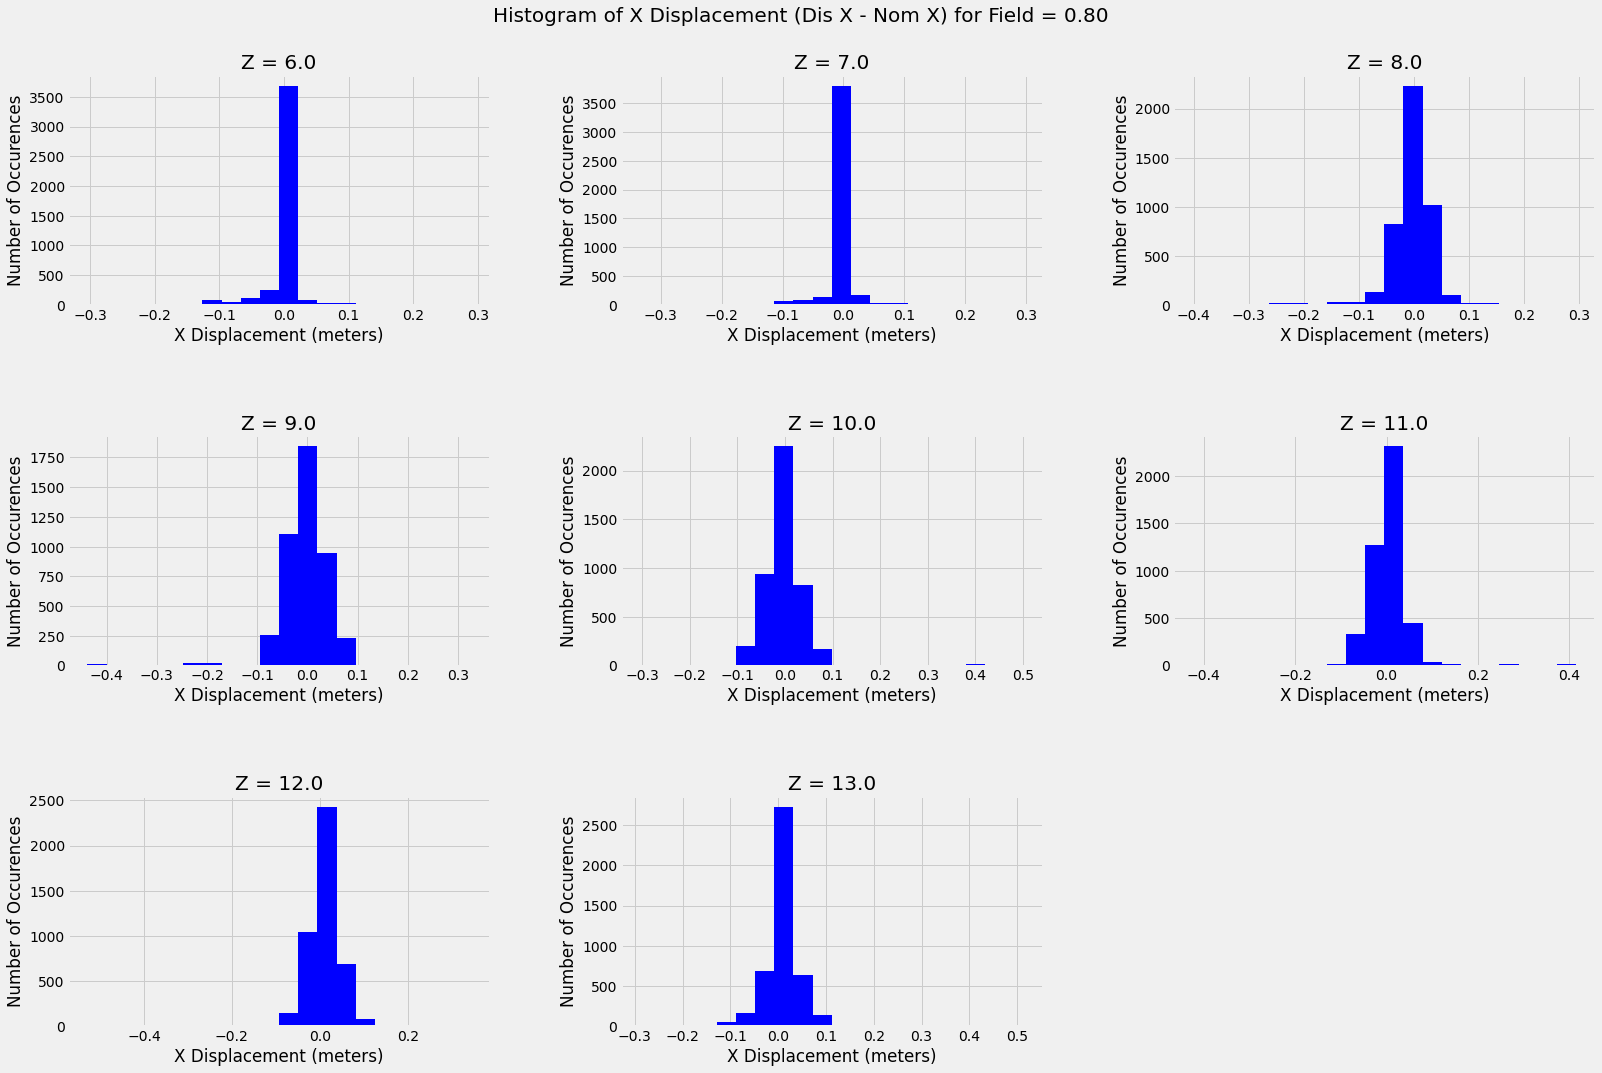

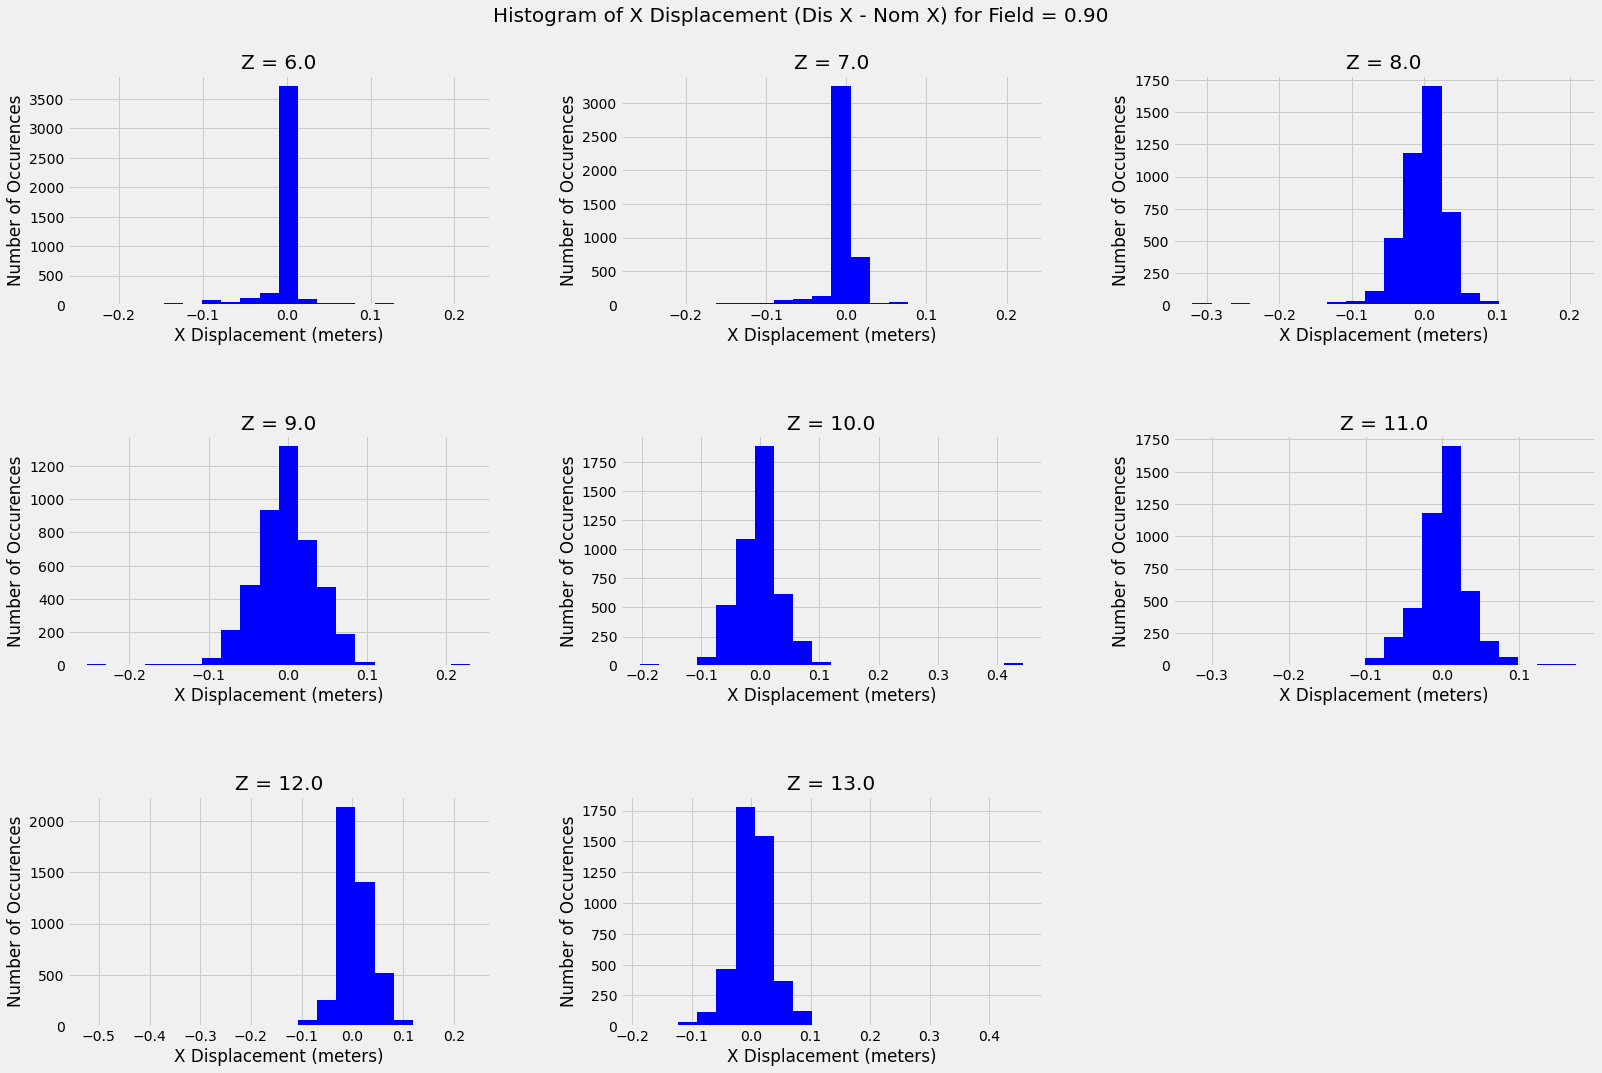

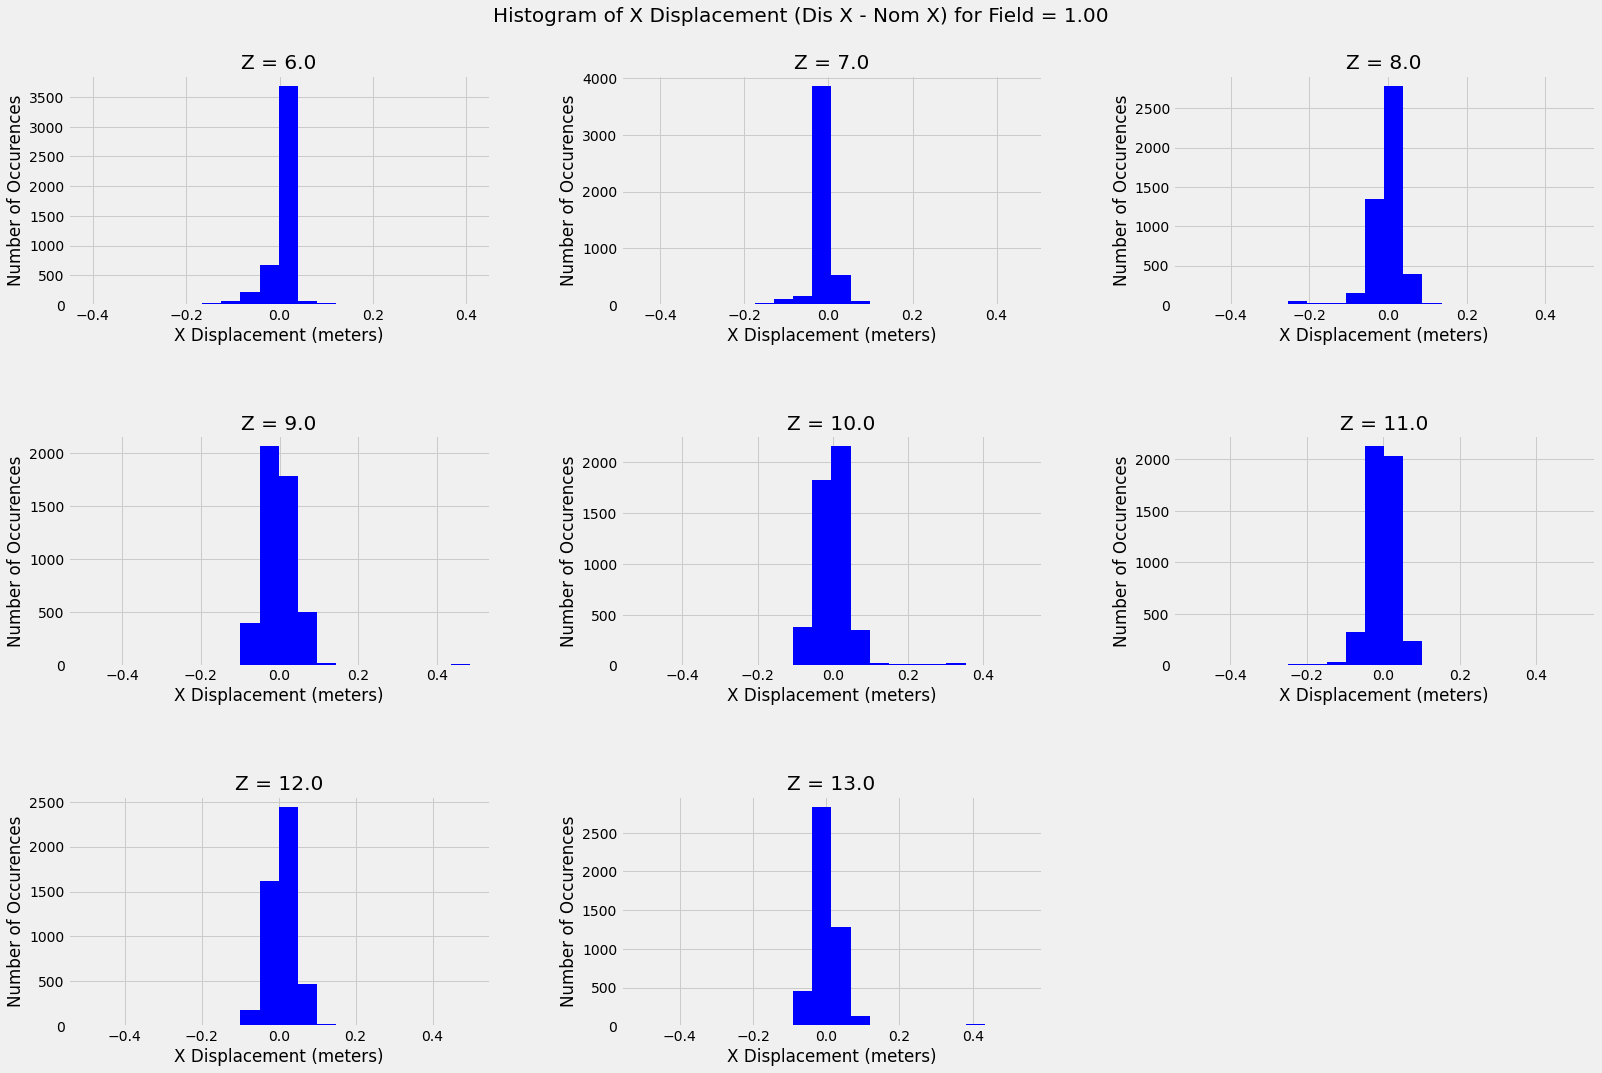

In [52]:
for field in datadf['field'].unique():
    fig = plt.figure()
    df1 = datadf[(datadf['z']==zvals[0]) & (datadf['field']==field)]
    df2 = datadf[(datadf['z']==zvals[1]) & (datadf['field']==field)]
    df3 = datadf[(datadf['z']==zvals[2]) & (datadf['field']==field)]
    df4 = datadf[(datadf['z']==zvals[3]) & (datadf['field']==field)]
    df5 = datadf[(datadf['z']==zvals[4]) & (datadf['field']==field)]
    df6 = datadf[(datadf['z']==zvals[5]) & (datadf['field']==field)]
    df7 = datadf[(datadf['z']==zvals[6]) & (datadf['field']==field)]
    df8 = datadf[(datadf['z']==zvals[7]) & (datadf['field']==field)]
    
    ax1 = plt.subplot2grid((3,3), (0,0), rowspan=1, colspan=1)
    ax1.hist(list(df1['xdif']), bins = 20, facecolor = 'blue')
    ax1.set_title(f'Z = {zvals[0]}')
    ax1.set_ylabel(f'Number of Occurences')
    ax1.set_xlabel(f'X Displacement (meters)')
    
    ax2 = plt.subplot2grid((3,3), (0,1), rowspan=1, colspan=1)
    ax2.hist(list(df2['xdif']), bins = 20, facecolor = 'blue')
    ax2.set_title(f'Z = {zvals[1]}')
    ax2.set_ylabel(f'Number of Occurences')
    ax2.set_xlabel(f'X Displacement (meters)')
    
    ax3 = plt.subplot2grid((3,3), (0,2), rowspan=1, colspan=1)
    ax3.hist(list(df3['xdif']), bins = 20, facecolor = 'blue')
    ax3.set_title(f'Z = {zvals[2]}')
    ax3.set_ylabel(f'Number of Occurences')
    ax3.set_xlabel(f'X Displacement (meters)')
    
    ax4 = plt.subplot2grid((3,3), (1,0), rowspan=1, colspan=1)
    ax4.hist(list(df4['xdif']), bins = 20, facecolor = 'blue')
    ax4.set_title(f'Z = {zvals[3]}')
    ax4.set_ylabel(f'Number of Occurences')
    ax4.set_xlabel(f'X Displacement (meters)')
    
    ax5 = plt.subplot2grid((3,3), (1,1), rowspan=1, colspan=1)
    ax5.hist(list(df5['xdif']), bins = 20, facecolor = 'blue')
    ax5.set_title(f'Z = {zvals[4]}')
    ax5.set_ylabel(f'Number of Occurences')
    ax5.set_xlabel(f'X Displacement (meters)')
    
    ax6 = plt.subplot2grid((3,3), (1,2), rowspan=1, colspan=1)
    ax6.hist(list(df6['xdif']), bins = 20, facecolor = 'blue')
    ax6.set_title(f'Z = {zvals[5]}')
    ax6.set_ylabel(f'Number of Occurences')
    ax6.set_xlabel(f'X Displacement (meters)')
    
    ax7 = plt.subplot2grid((3,3), (2,0), rowspan=1, colspan=1)
    ax7.hist(list(df7['xdif']), bins = 20, facecolor = 'blue')
    ax7.set_title(f'Z = {zvals[6]}')
    ax7.set_ylabel(f'Number of Occurences')
    ax7.set_xlabel(f'X Displacement (meters)')
    
    ax8 = plt.subplot2grid((3,3), (2,1), rowspan=1, colspan=1)
    ax8.hist(list(df8['xdif']), bins = 20, facecolor = 'blue')
    ax8.set_title(f'Z = {zvals[7]}')
    ax8.set_ylabel(f'Number of Occurences')
    ax8.set_xlabel(f'X Displacement (meters)')
    
    fig.suptitle(f'Histogram of X Displacement (Dis X - Nom X) for Field = {field}', fontsize = 20)
    fig.tight_layout(pad = 5.0)
    fig.savefig(plotdir+f'/X_hist_{field}.png')

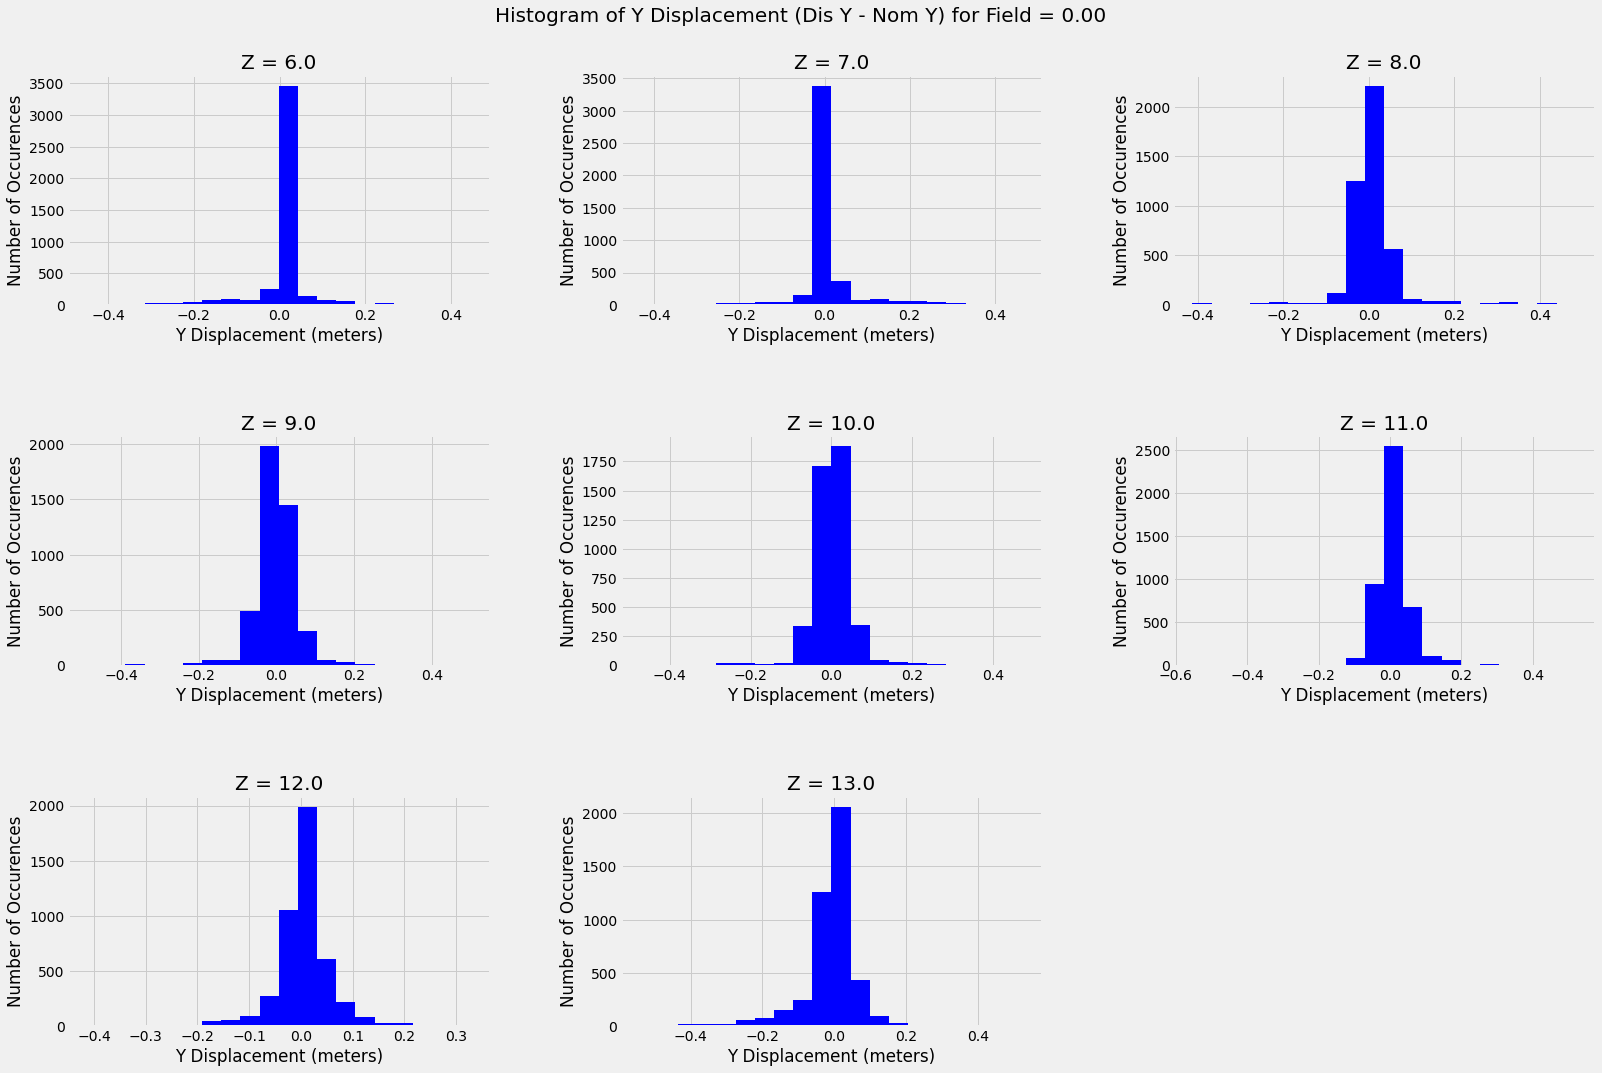

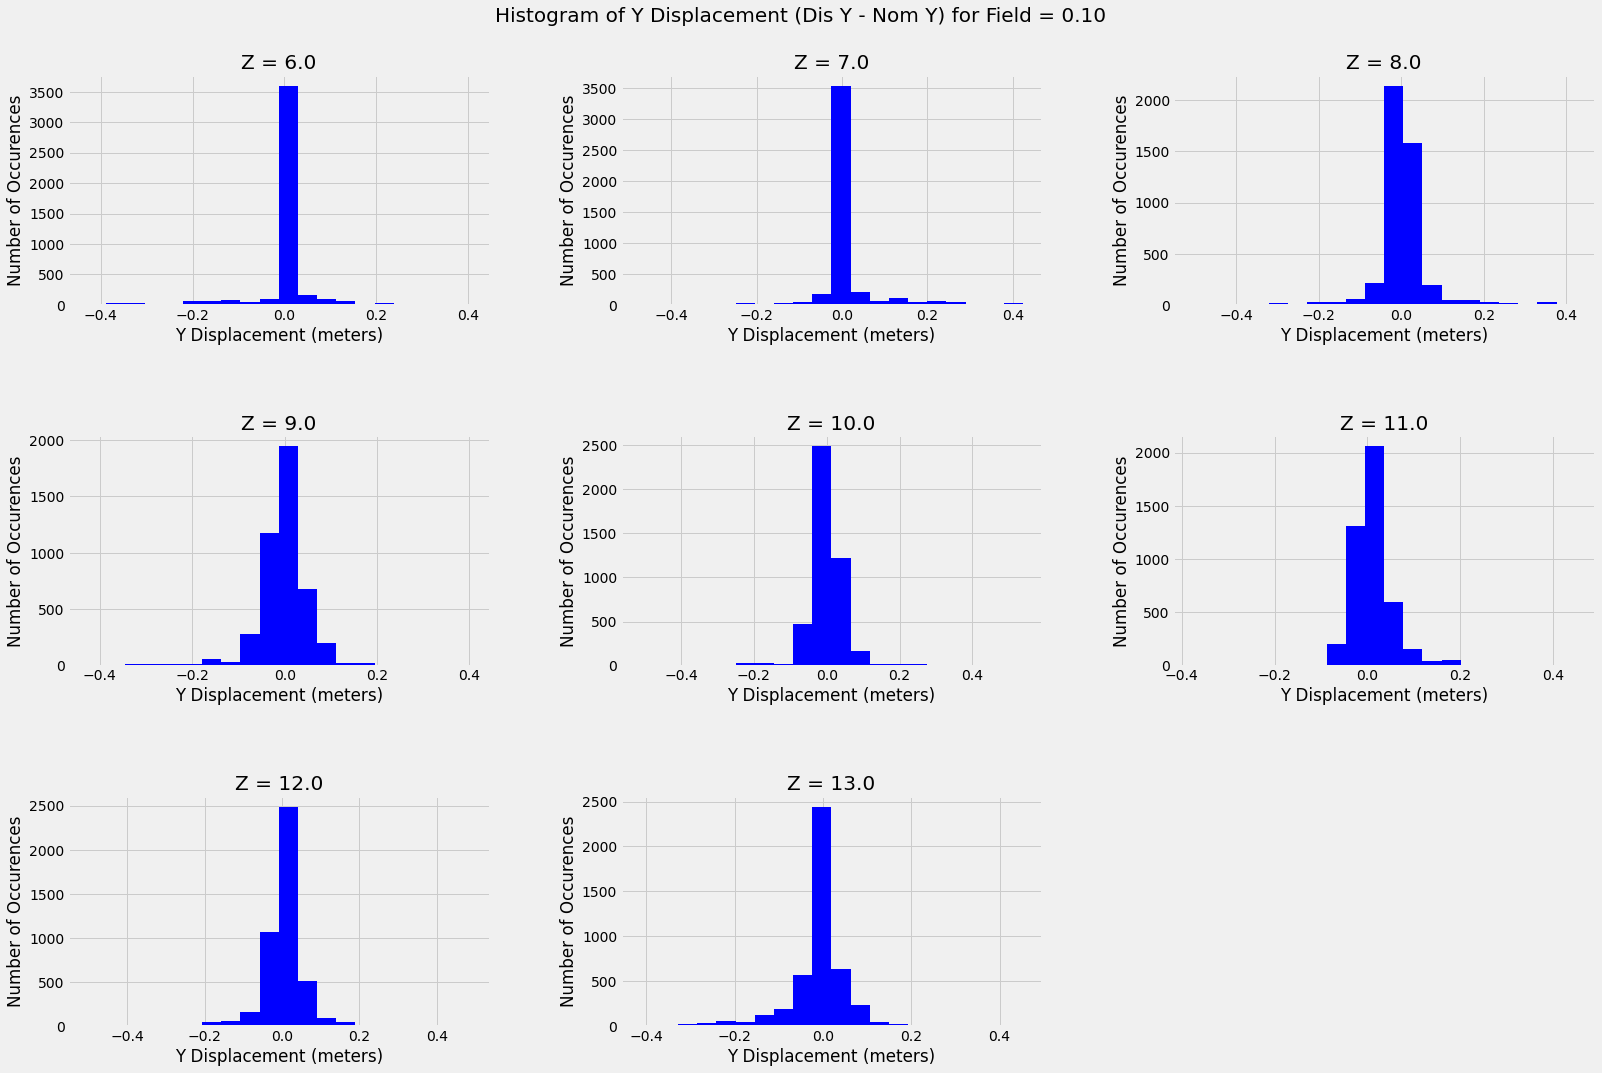

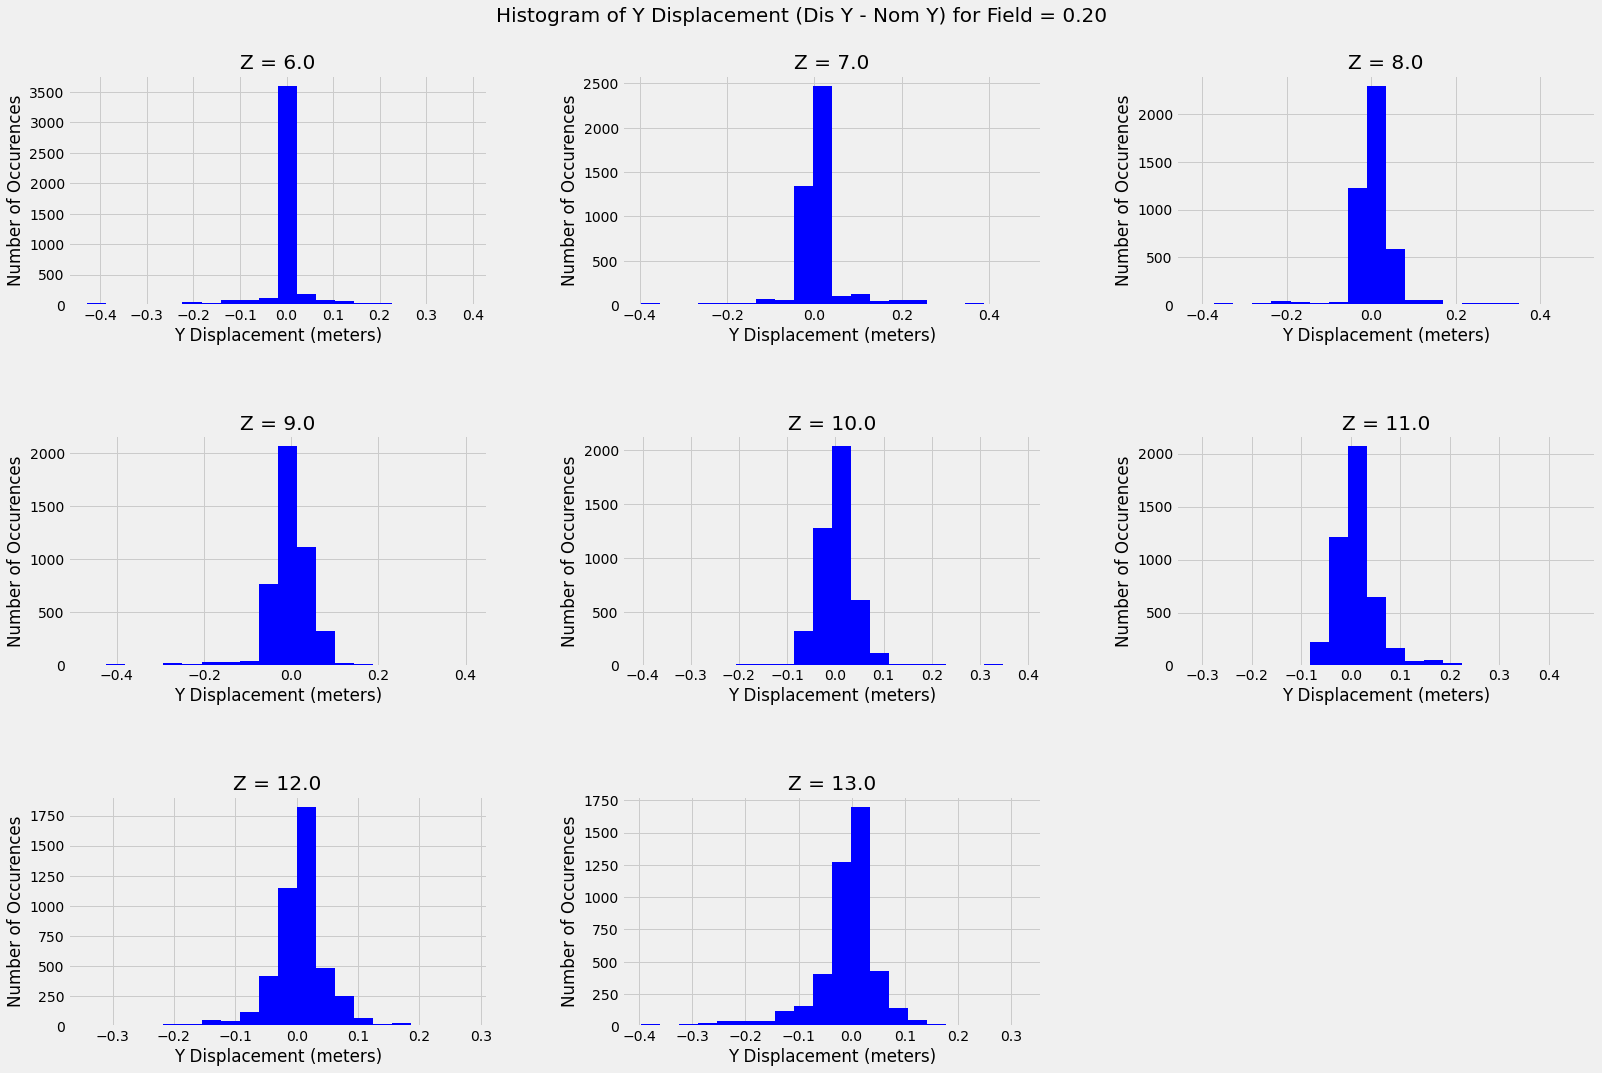

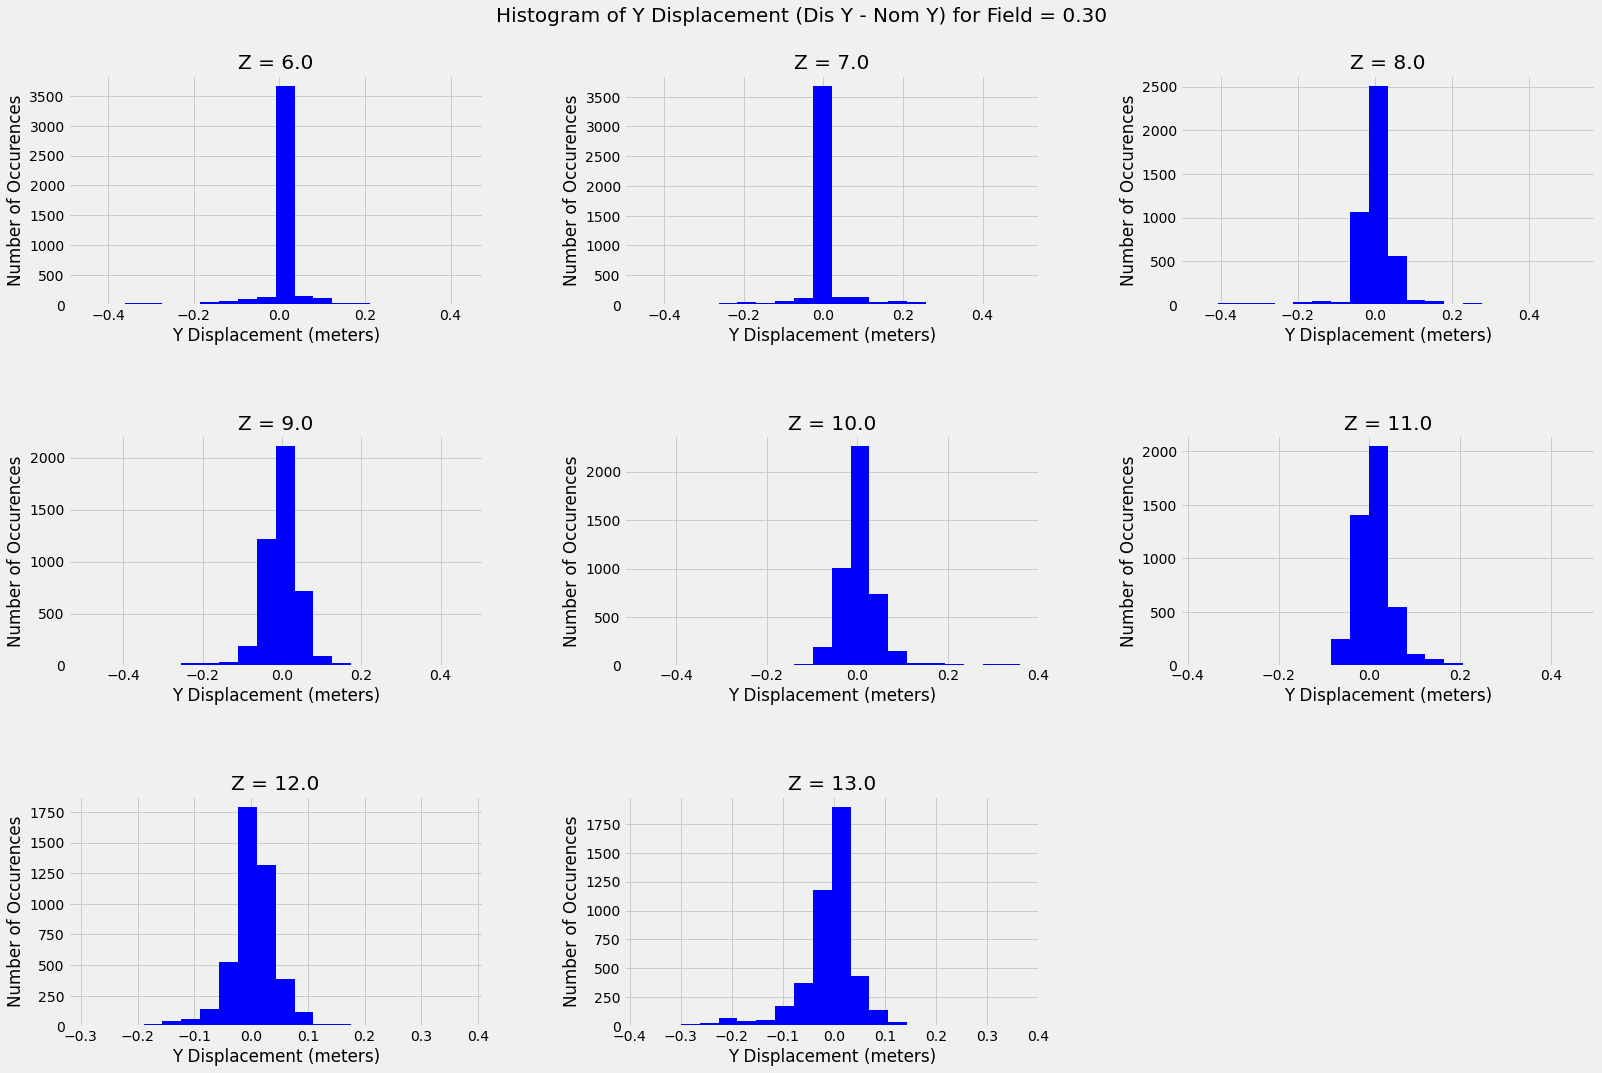

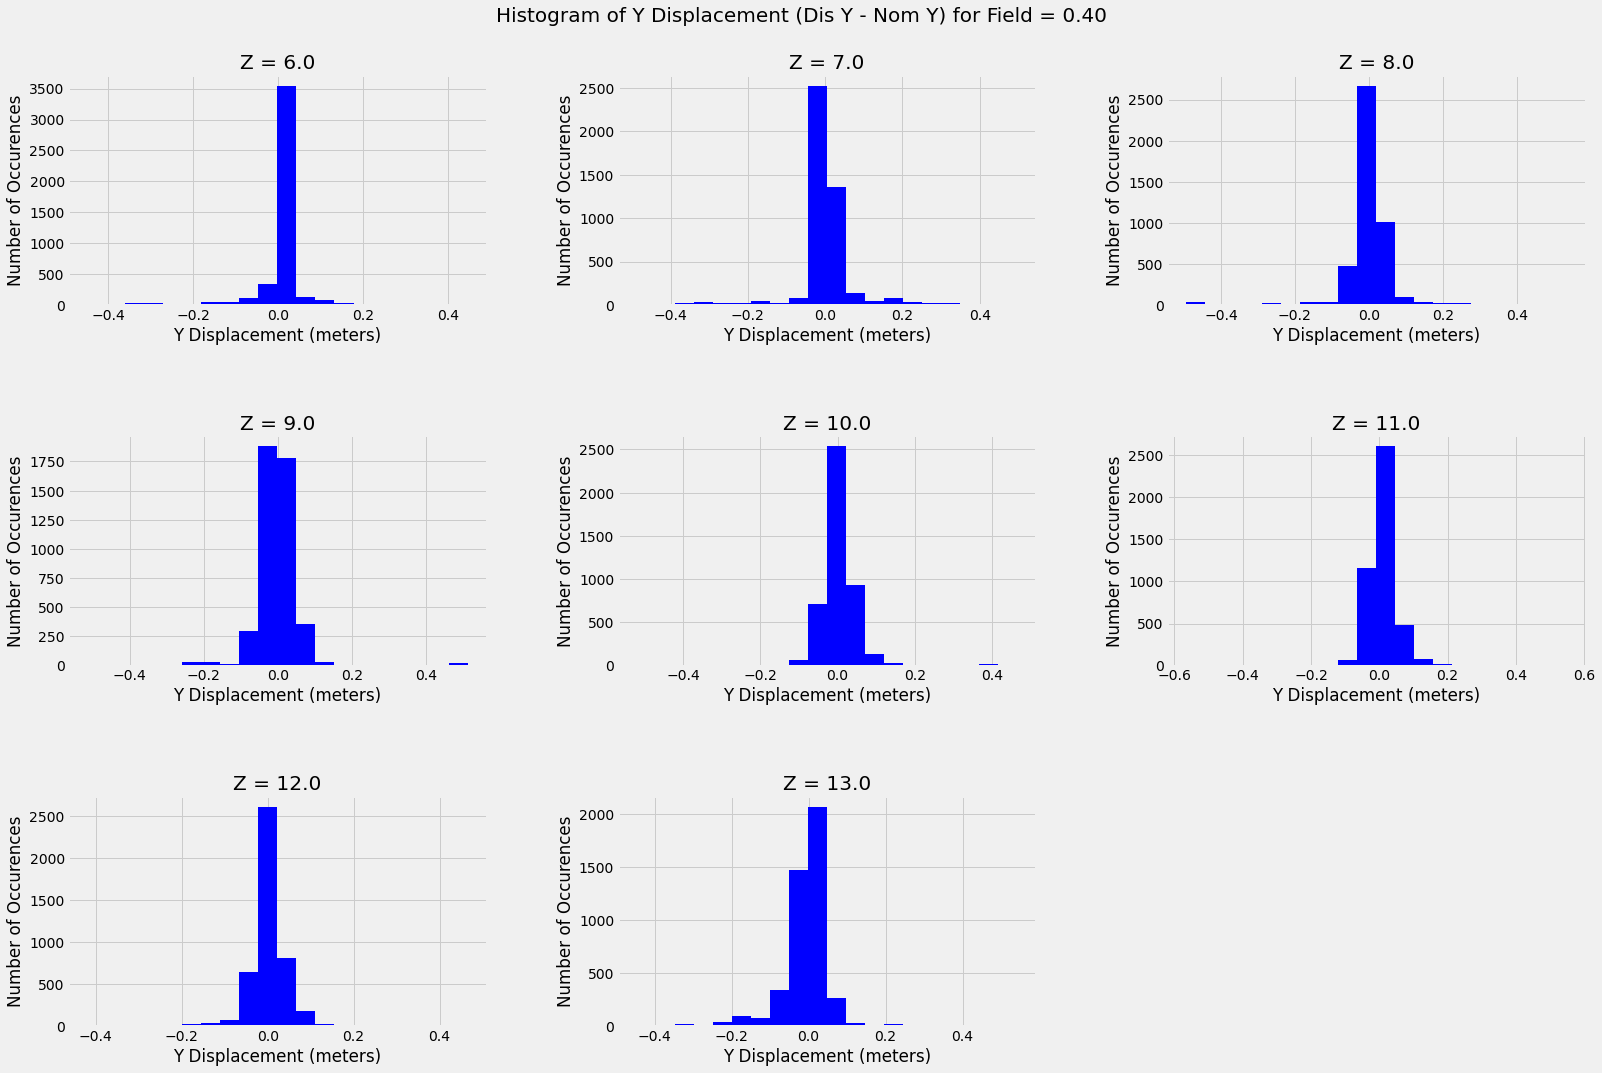

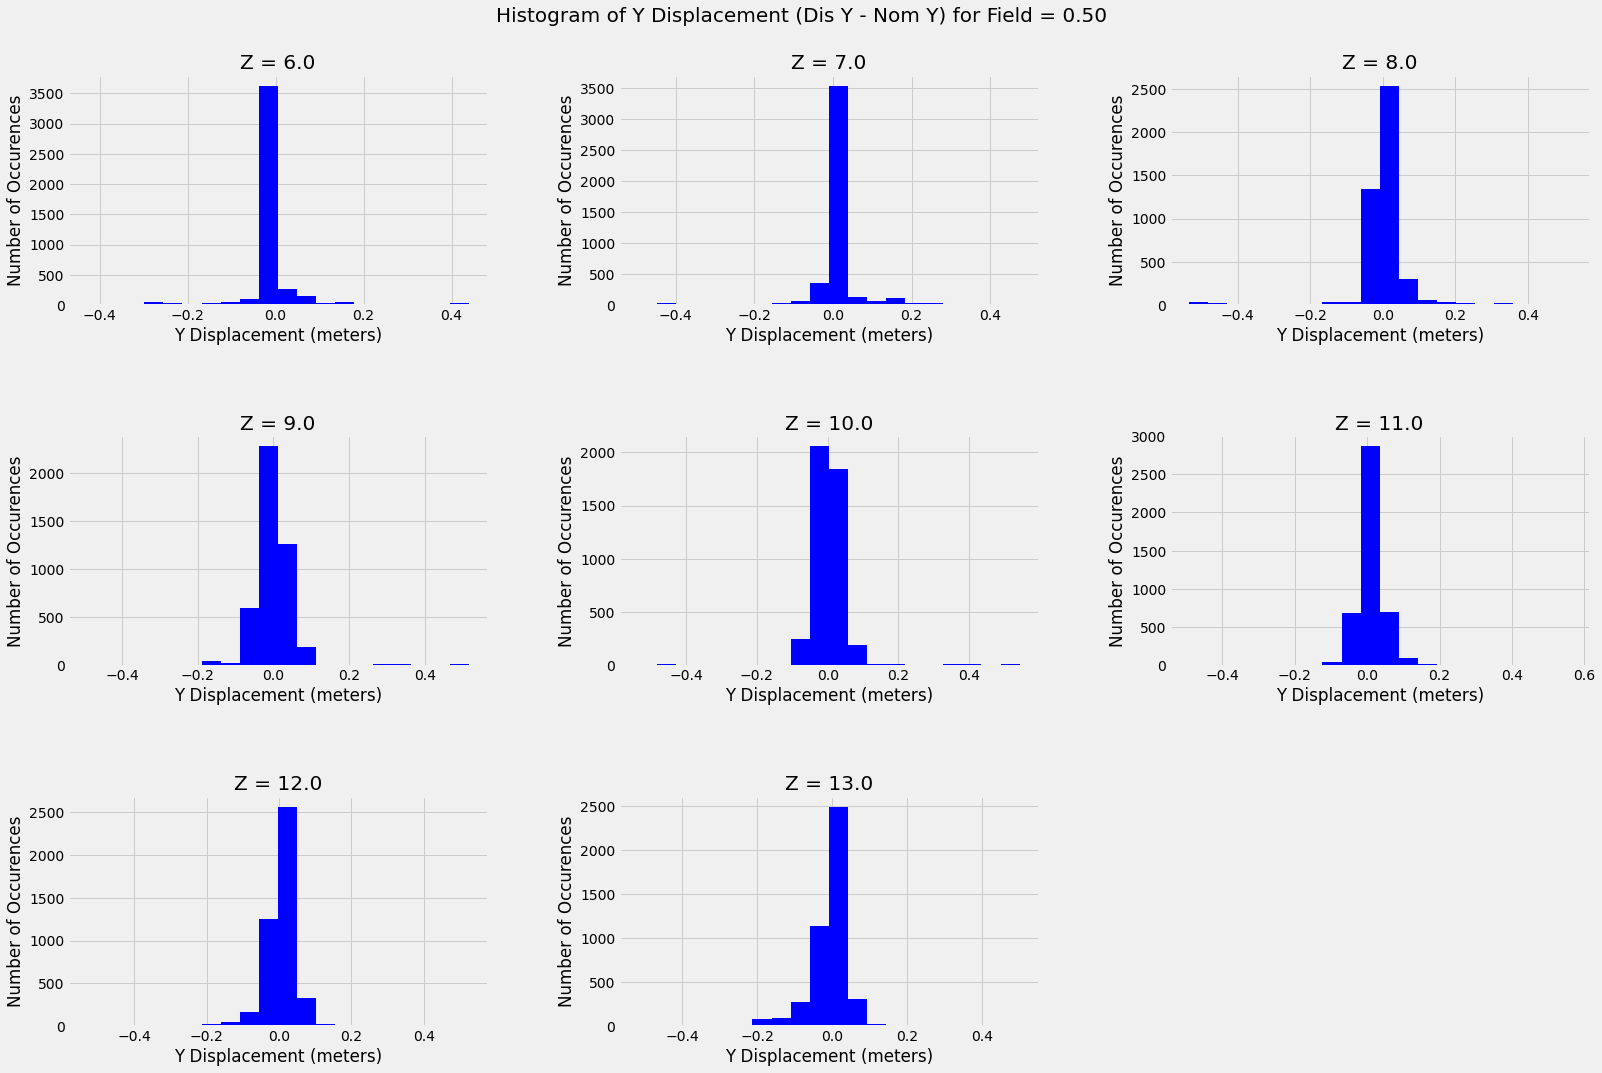

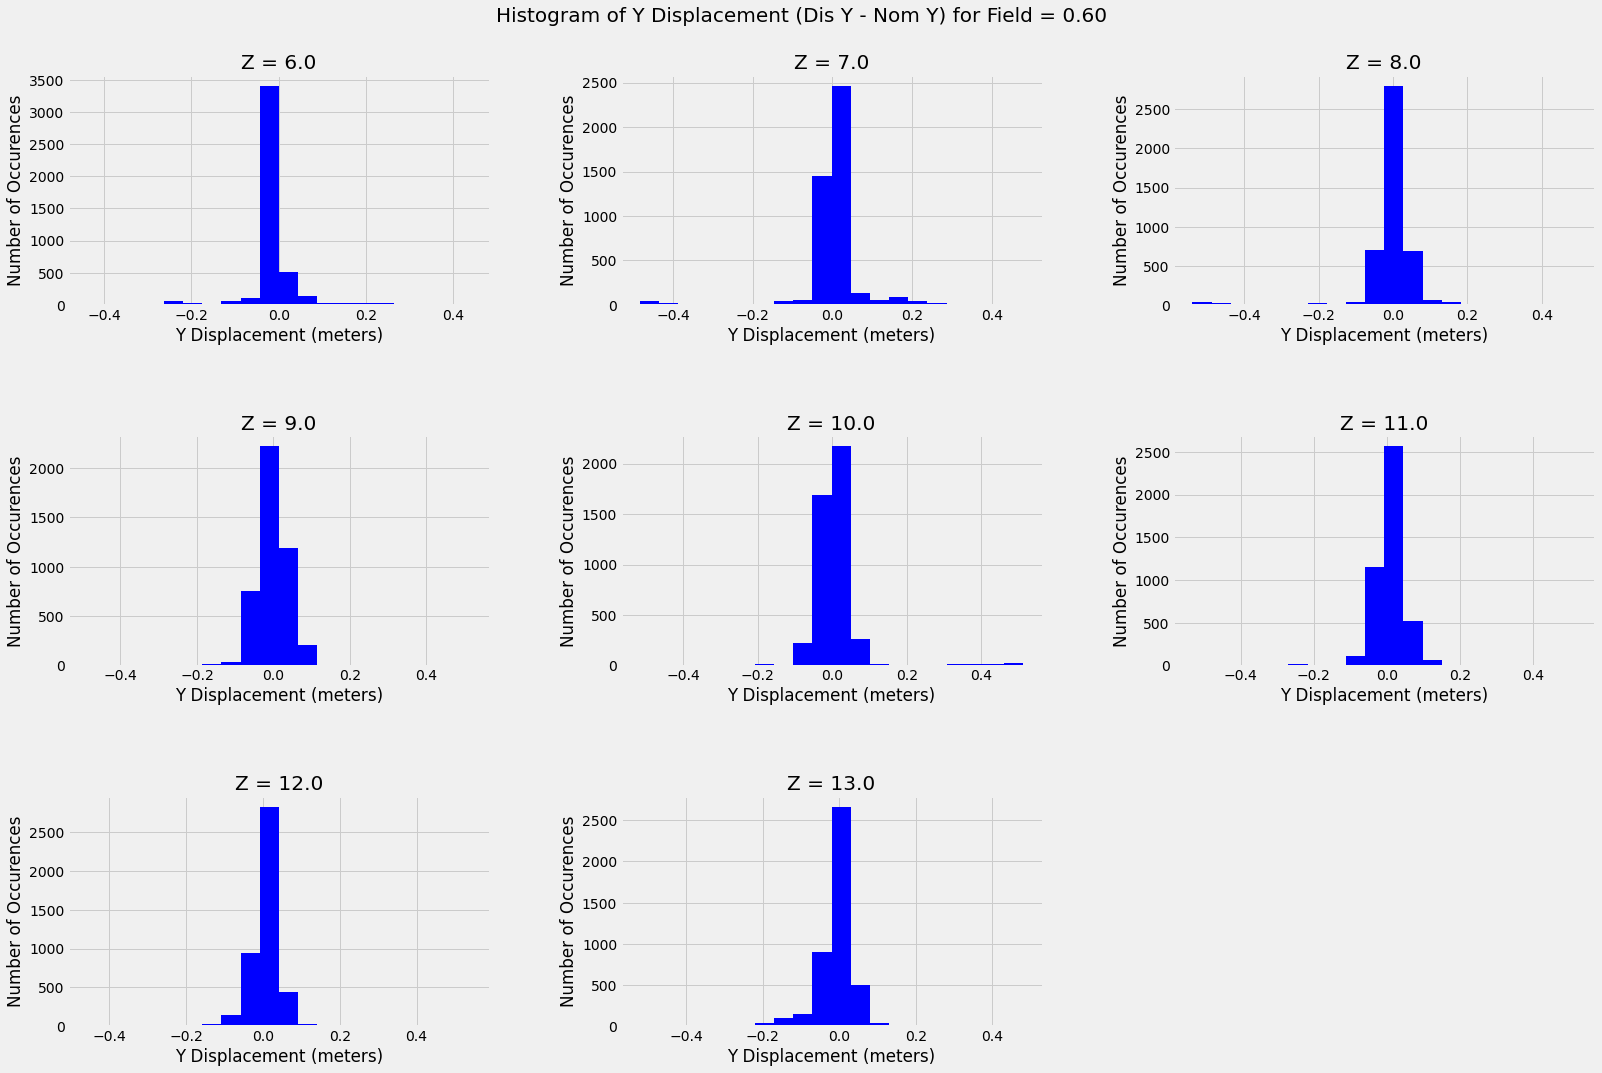

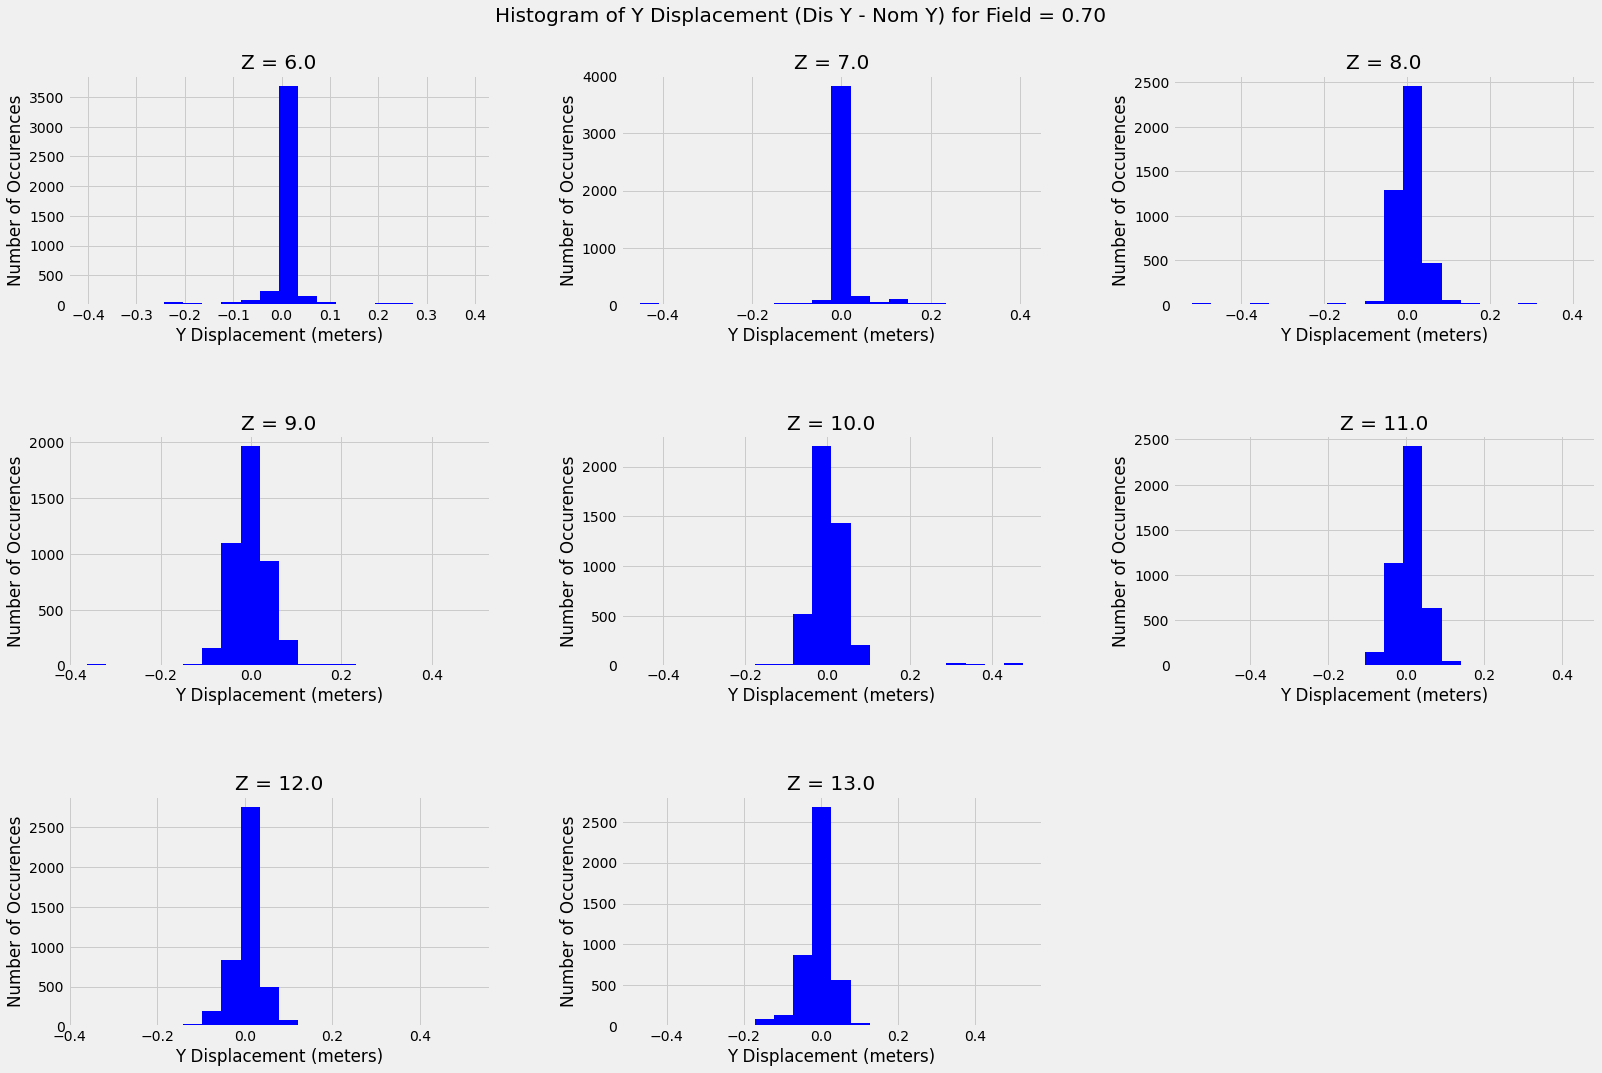

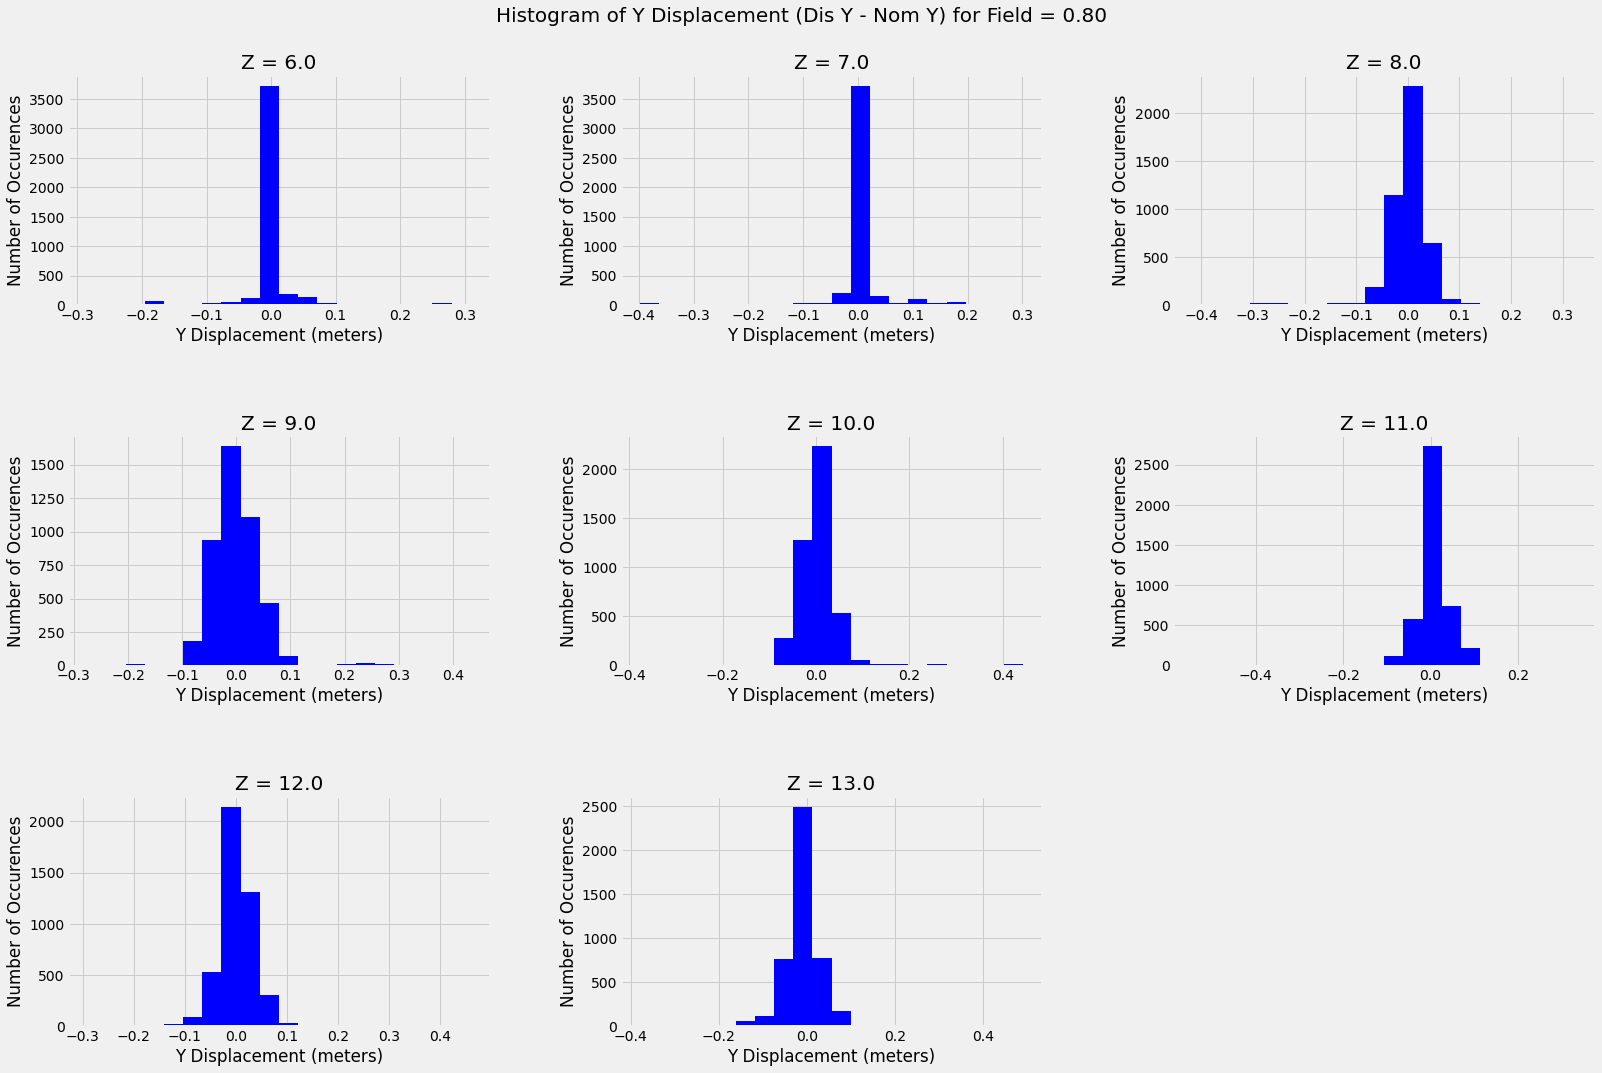

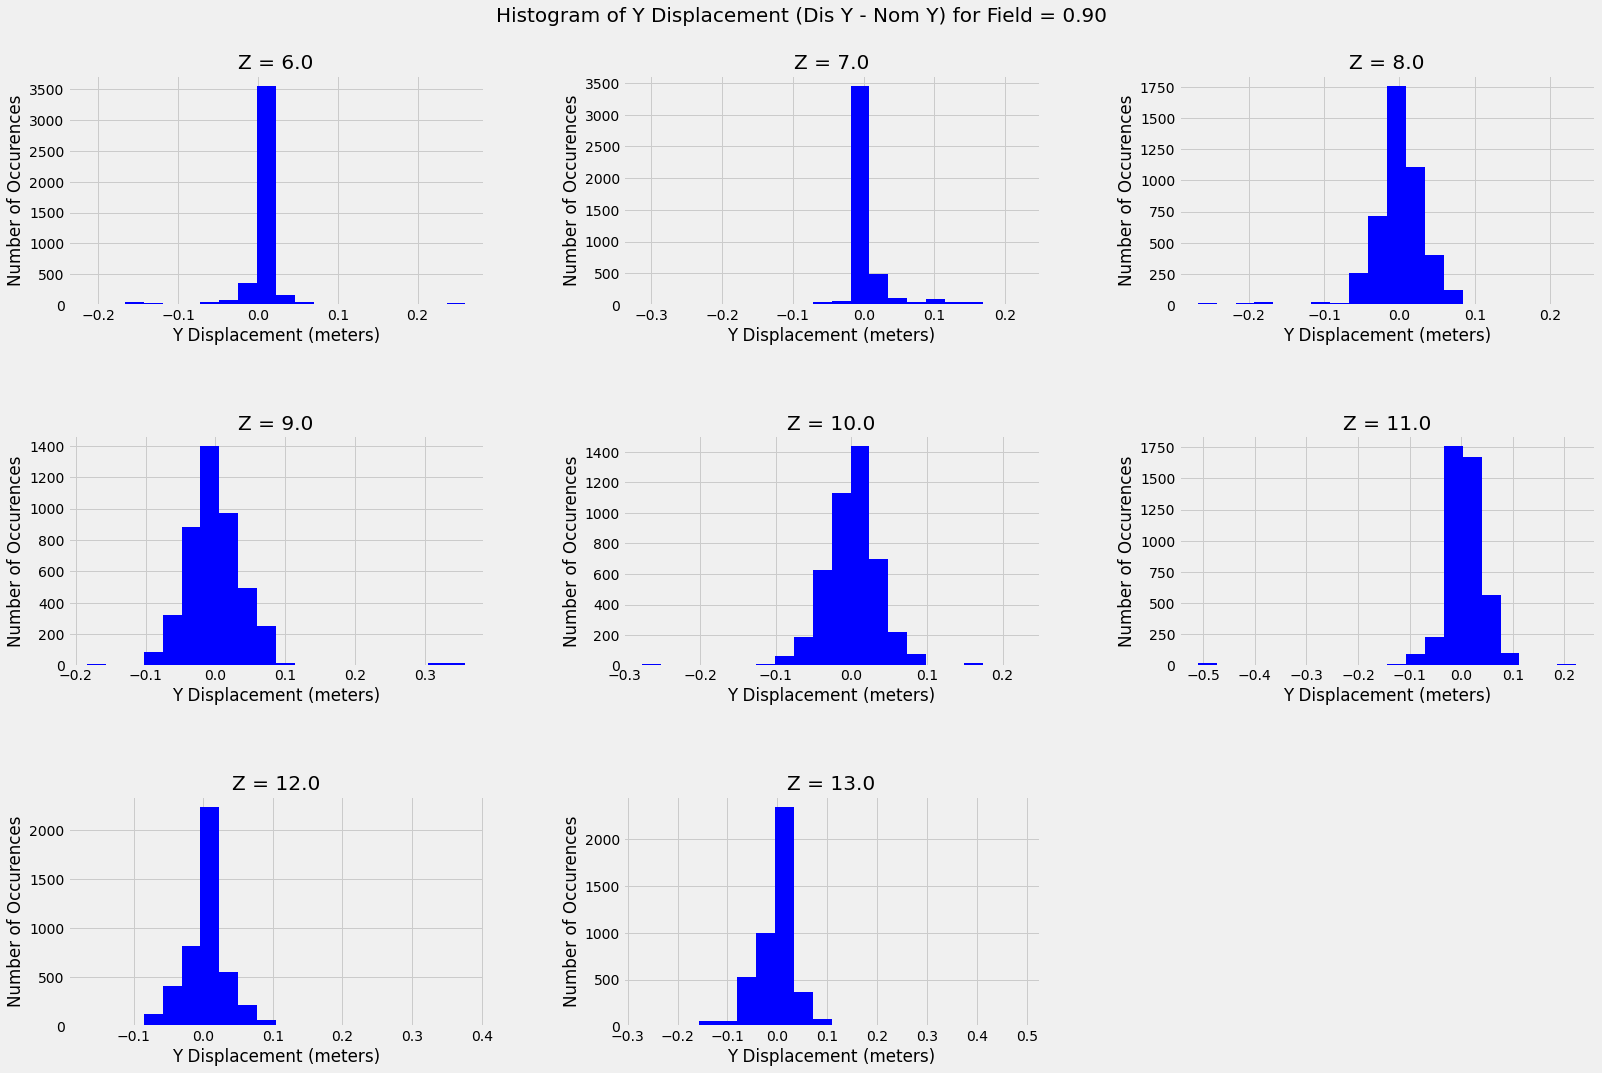

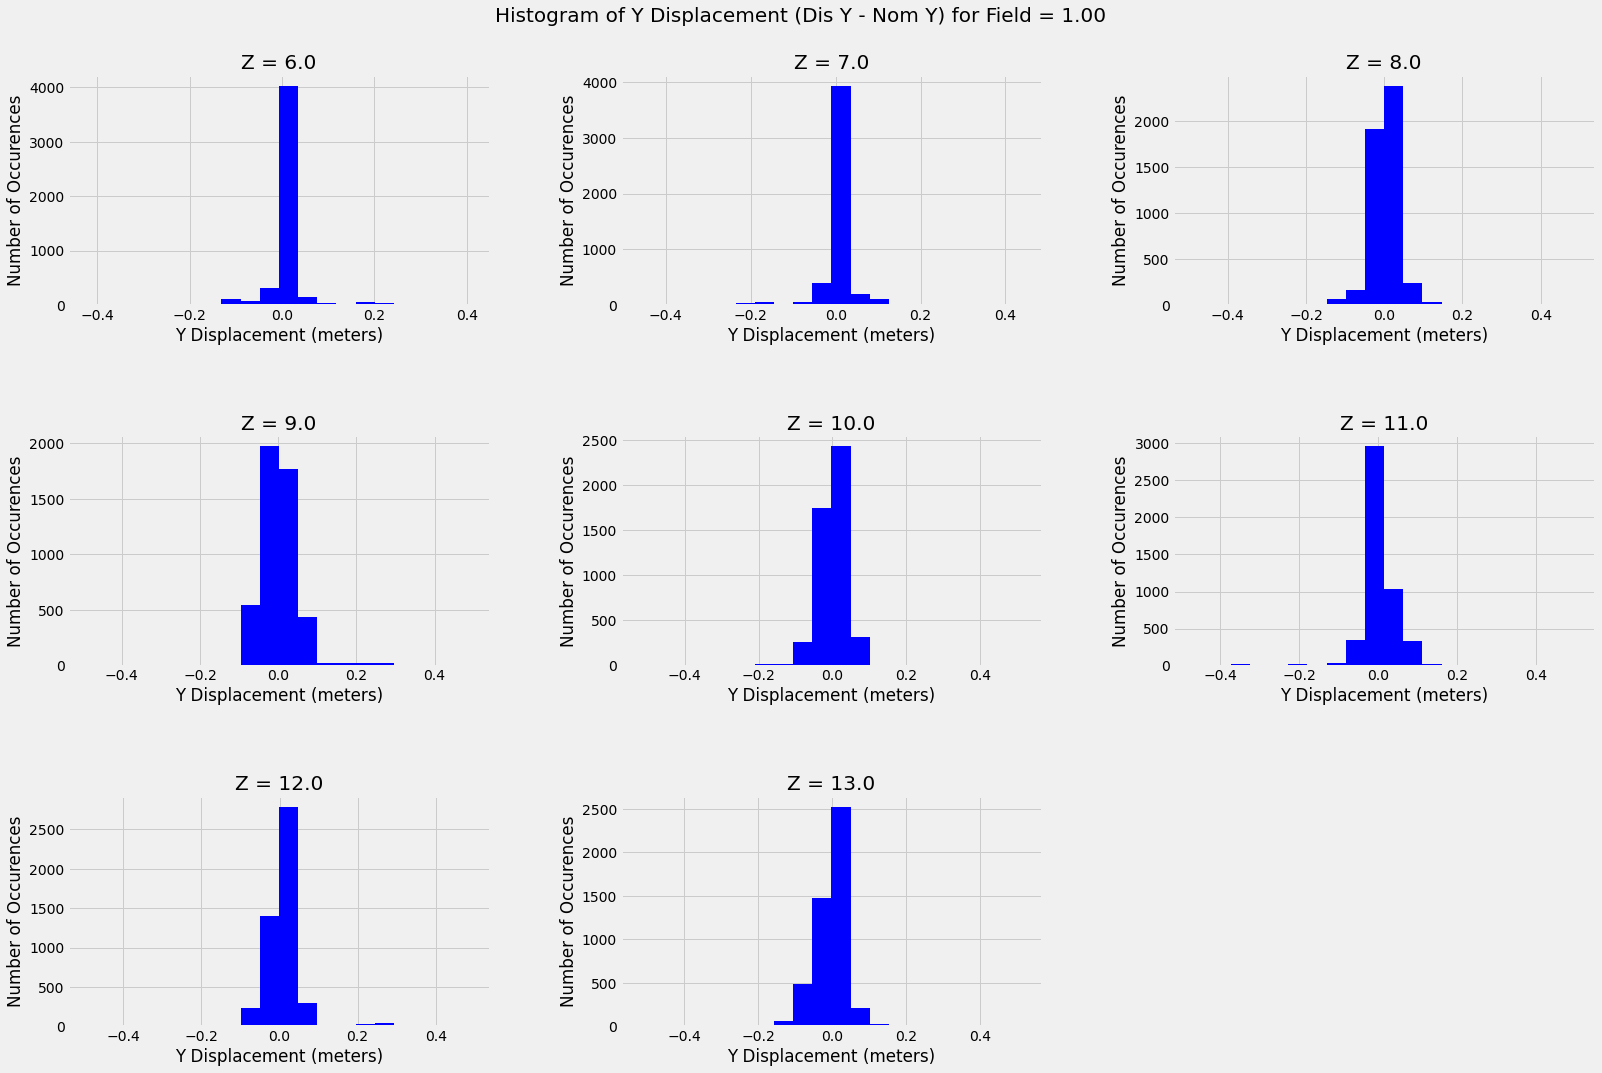

In [33]:
for field in datadf['field'].unique():
    fig = plt.figure()
    df1 = datadf[(datadf['z']==zvals[0]) & (datadf['field']==field)]
    df2 = datadf[(datadf['z']==zvals[1]) & (datadf['field']==field)]
    df3 = datadf[(datadf['z']==zvals[2]) & (datadf['field']==field)]
    df4 = datadf[(datadf['z']==zvals[3]) & (datadf['field']==field)]
    df5 = datadf[(datadf['z']==zvals[4]) & (datadf['field']==field)]
    df6 = datadf[(datadf['z']==zvals[5]) & (datadf['field']==field)]
    df7 = datadf[(datadf['z']==zvals[6]) & (datadf['field']==field)]
    df8 = datadf[(datadf['z']==zvals[7]) & (datadf['field']==field)]
    
    ax1 = plt.subplot2grid((3,3), (0,0), rowspan=1, colspan=1)
    ax1.hist(list(df1['ydif']), bins = 20, facecolor = 'blue')
    ax1.set_title(f'Z = {zvals[0]}')
    ax1.set_ylabel(f'Number of Occurences')
    ax1.set_xlabel(f'Y Displacement (meters)')
    
    ax2 = plt.subplot2grid((3,3), (0,1), rowspan=1, colspan=1)
    ax2.hist(list(df2['ydif']), bins = 20, facecolor = 'blue')
    ax2.set_title(f'Z = {zvals[1]}')
    ax2.set_ylabel(f'Number of Occurences')
    ax2.set_xlabel(f'Y Displacement (meters)')
    
    ax3 = plt.subplot2grid((3,3), (0,2), rowspan=1, colspan=1)
    ax3.hist(list(df3['ydif']), bins = 20, facecolor = 'blue')
    ax3.set_title(f'Z = {zvals[2]}')
    ax3.set_ylabel(f'Number of Occurences')
    ax3.set_xlabel(f'Y Displacement (meters)')
    
    ax4 = plt.subplot2grid((3,3), (1,0), rowspan=1, colspan=1)
    ax4.hist(list(df4['ydif']), bins = 20, facecolor = 'blue')
    ax4.set_title(f'Z = {zvals[3]}')
    ax4.set_ylabel(f'Number of Occurences')
    ax4.set_xlabel(f'Y Displacement (meters)')
    
    ax5 = plt.subplot2grid((3,3), (1,1), rowspan=1, colspan=1)
    ax5.hist(list(df5['ydif']), bins = 20, facecolor = 'blue')
    ax5.set_title(f'Z = {zvals[4]}')
    ax5.set_ylabel(f'Number of Occurences')
    ax5.set_xlabel(f'Y Displacement (meters)')
    
    ax6 = plt.subplot2grid((3,3), (1,2), rowspan=1, colspan=1)
    ax6.hist(list(df6['ydif']), bins = 20, facecolor = 'blue')
    ax6.set_title(f'Z = {zvals[5]}')
    ax6.set_ylabel(f'Number of Occurences')
    ax6.set_xlabel(f'Y Displacement (meters)')
    
    ax7 = plt.subplot2grid((3,3), (2,0), rowspan=1, colspan=1)
    ax7.hist(list(df7['ydif']), bins = 20, facecolor = 'blue')
    ax7.set_title(f'Z = {zvals[6]}')
    ax7.set_ylabel(f'Number of Occurences')
    ax7.set_xlabel(f'Y Displacement (meters)')
    
    ax8 = plt.subplot2grid((3,3), (2,1), rowspan=1, colspan=1)
    ax8.hist(list(df8['ydif']), bins = 20, facecolor = 'blue')
    ax8.set_title(f'Z = {zvals[7]}')
    ax8.set_ylabel(f'Number of Occurences')
    ax8.set_xlabel(f'Y Displacement (meters)')
    
    fig.suptitle(f'Histogram of Y Displacement (Dis Y - Nom Y) for Field = {field}', fontsize = 20)
    fig.tight_layout(pad = 5.0)
    fig.savefig(plotdir+f'/Y_hist_{field}.png')

In [34]:
zvals2

array([ 8.,  9., 10., 11., 12., 13.])

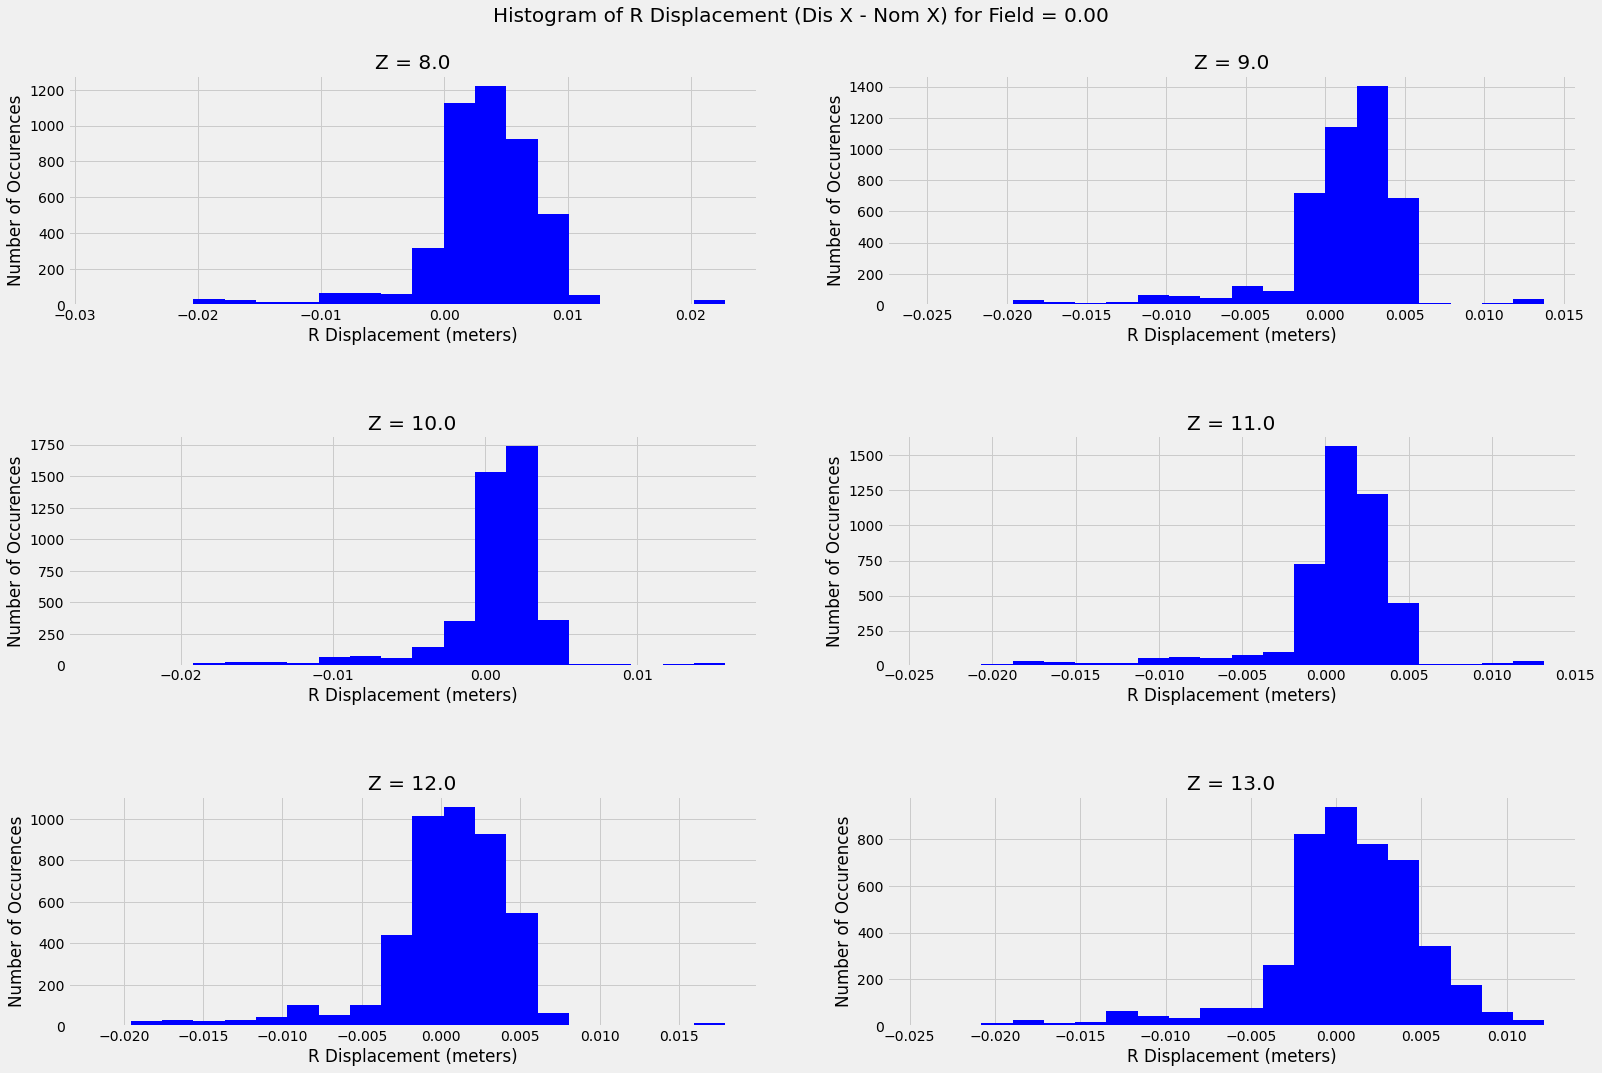

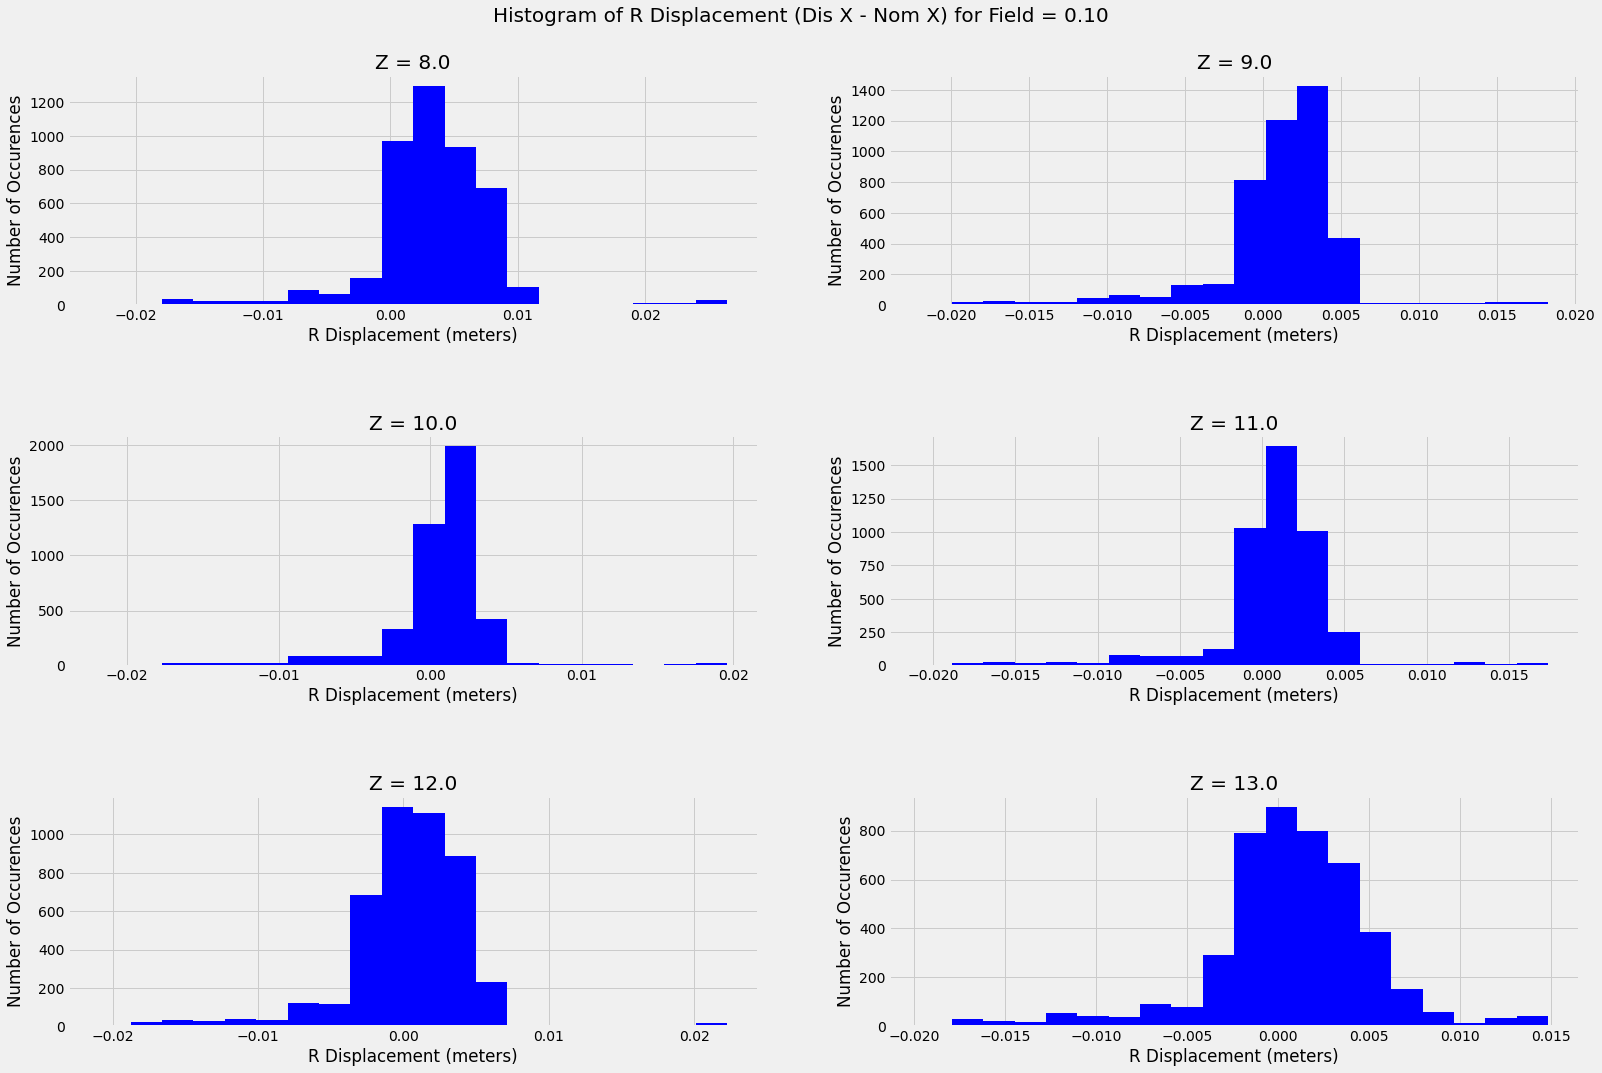

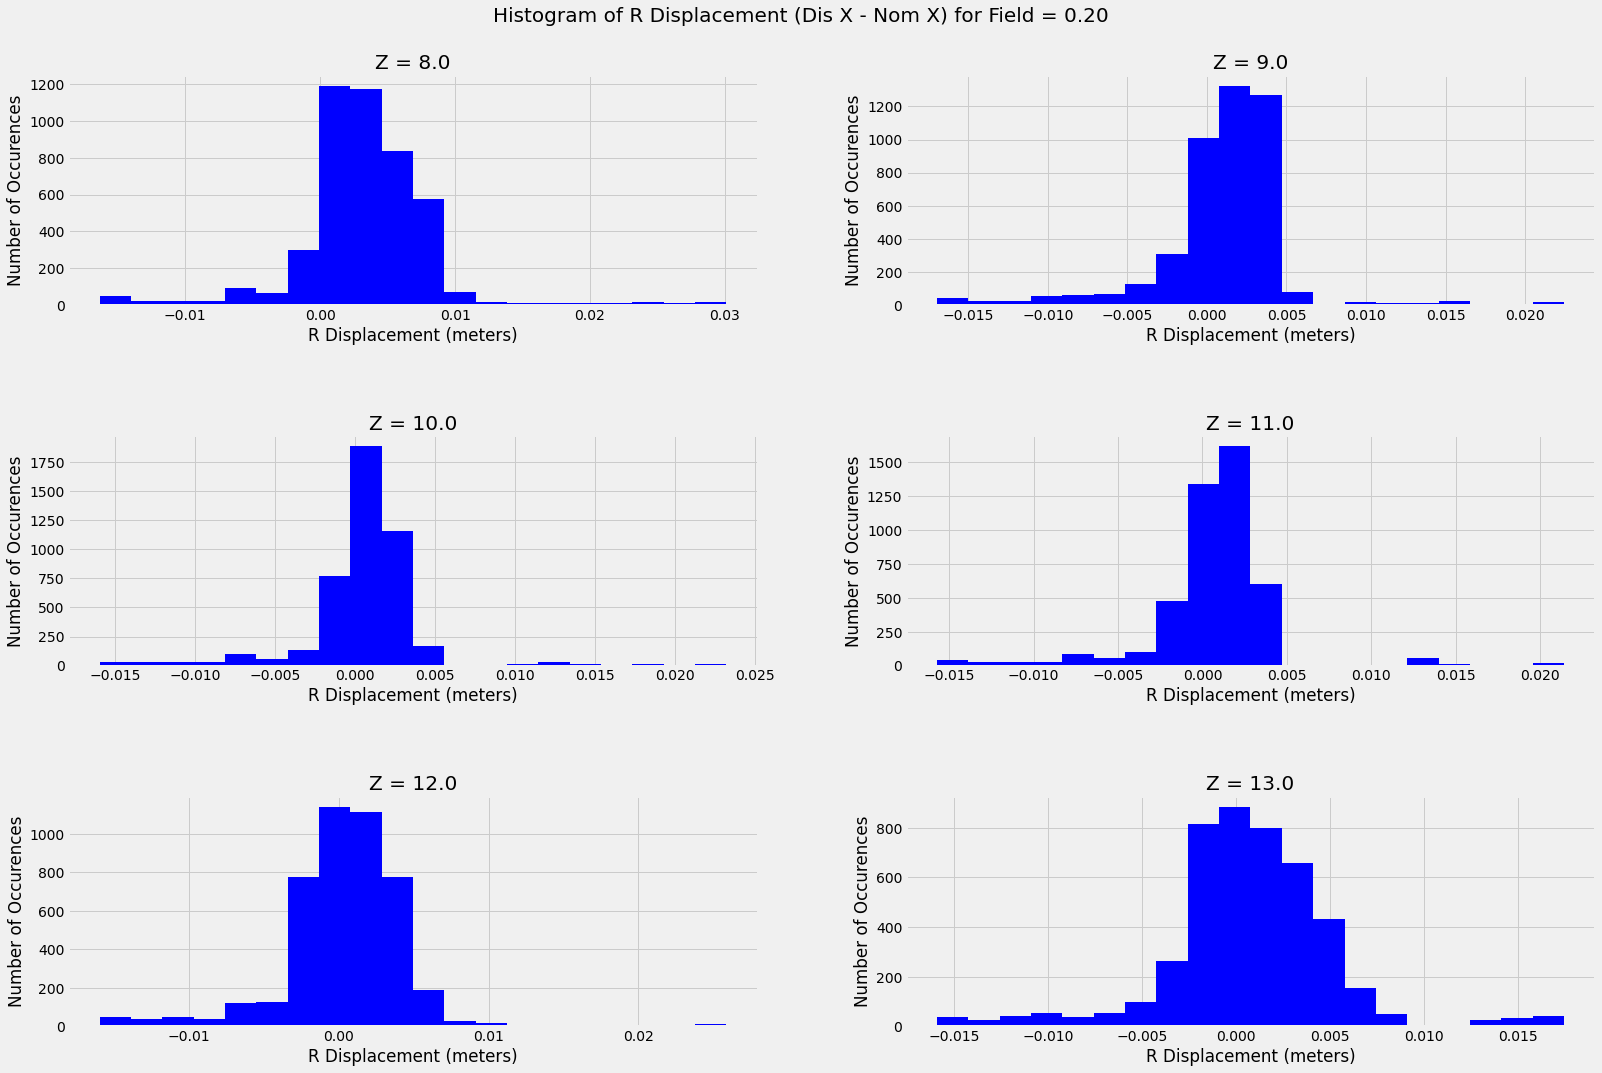

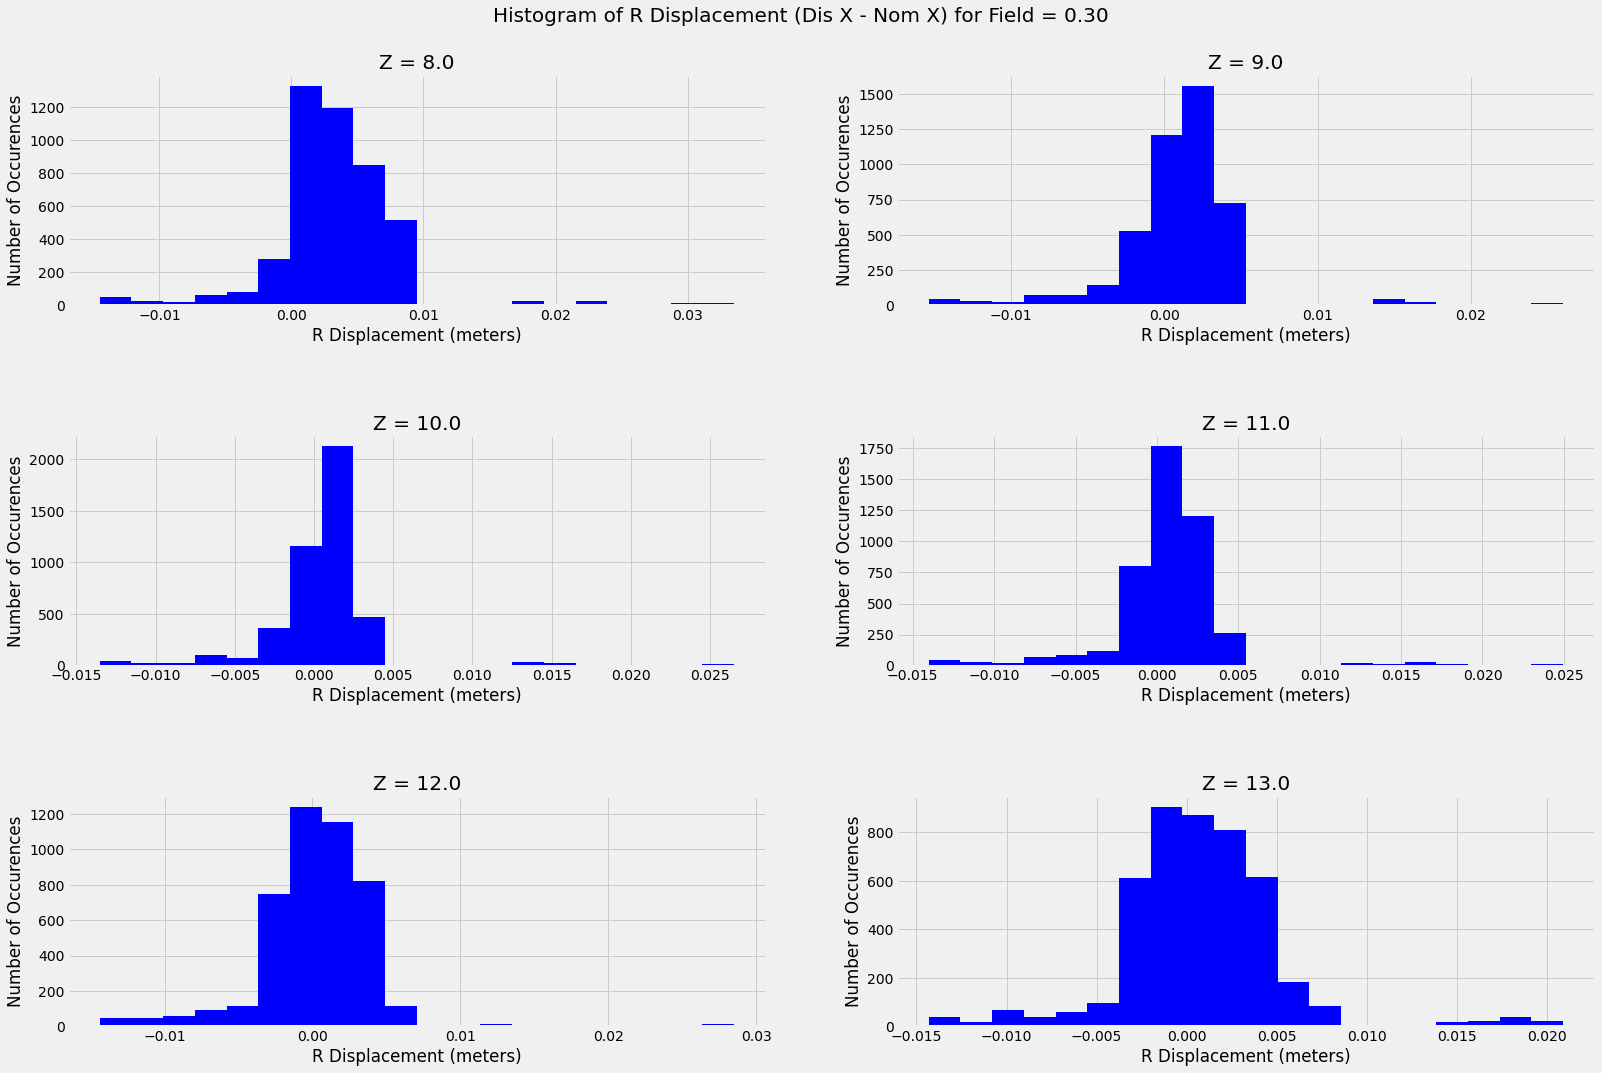

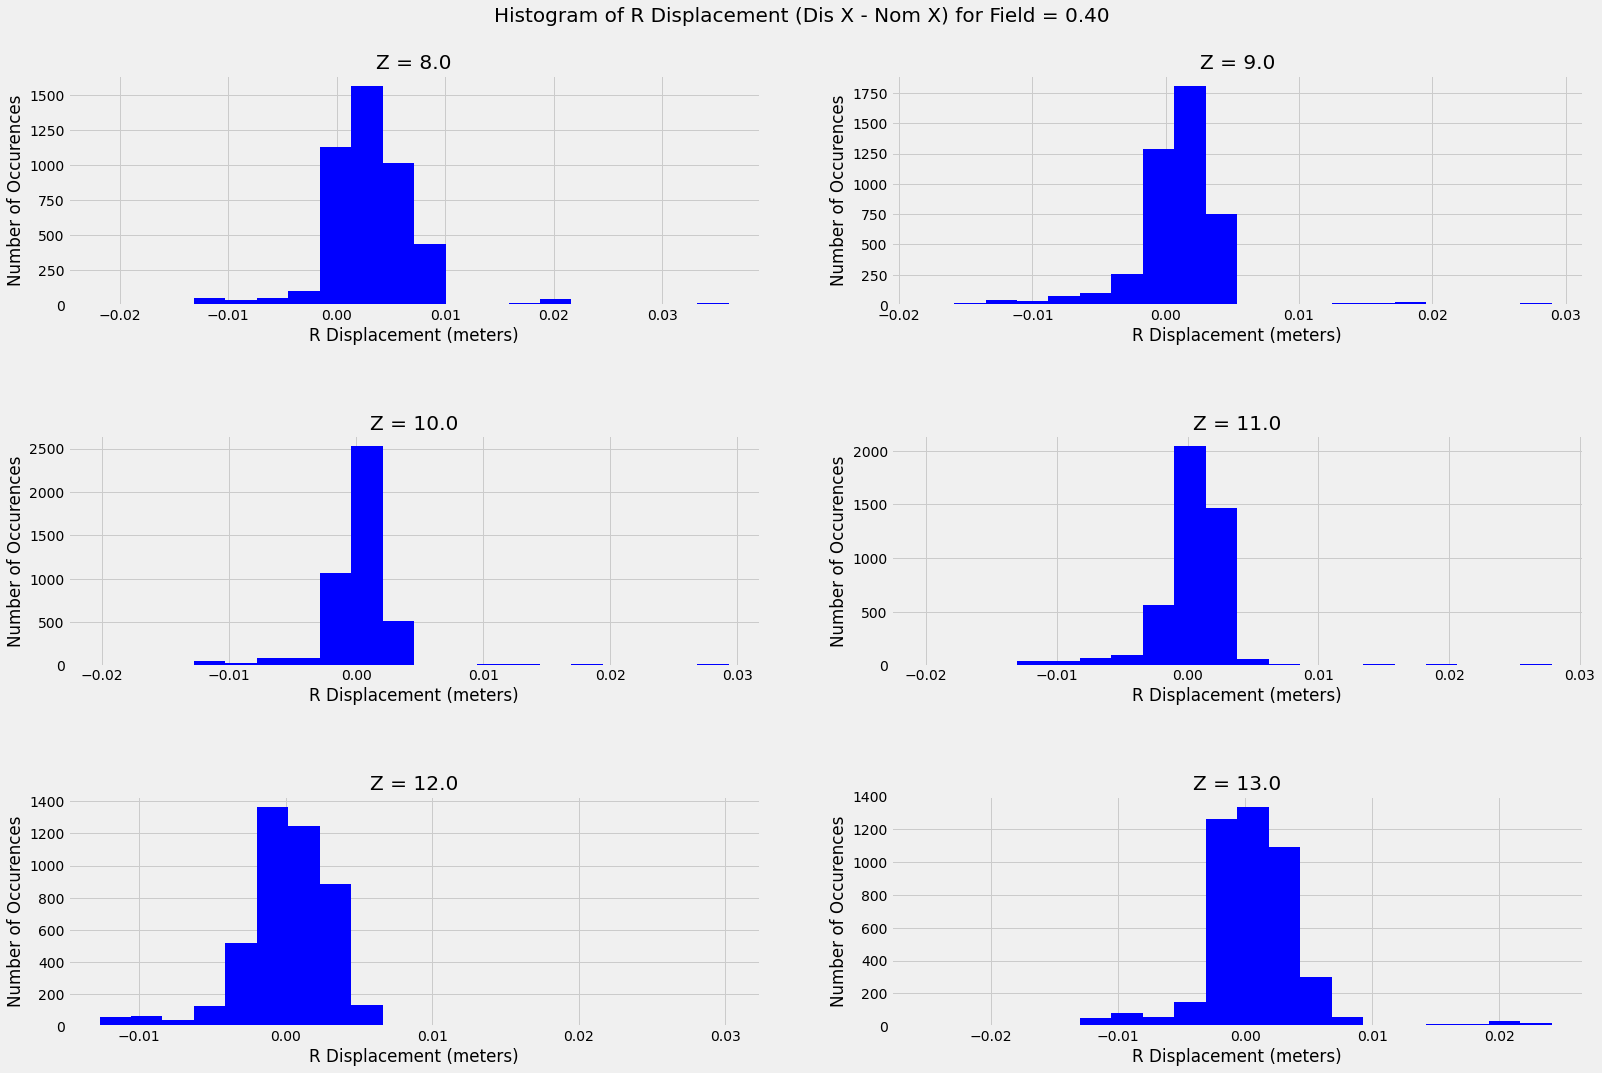

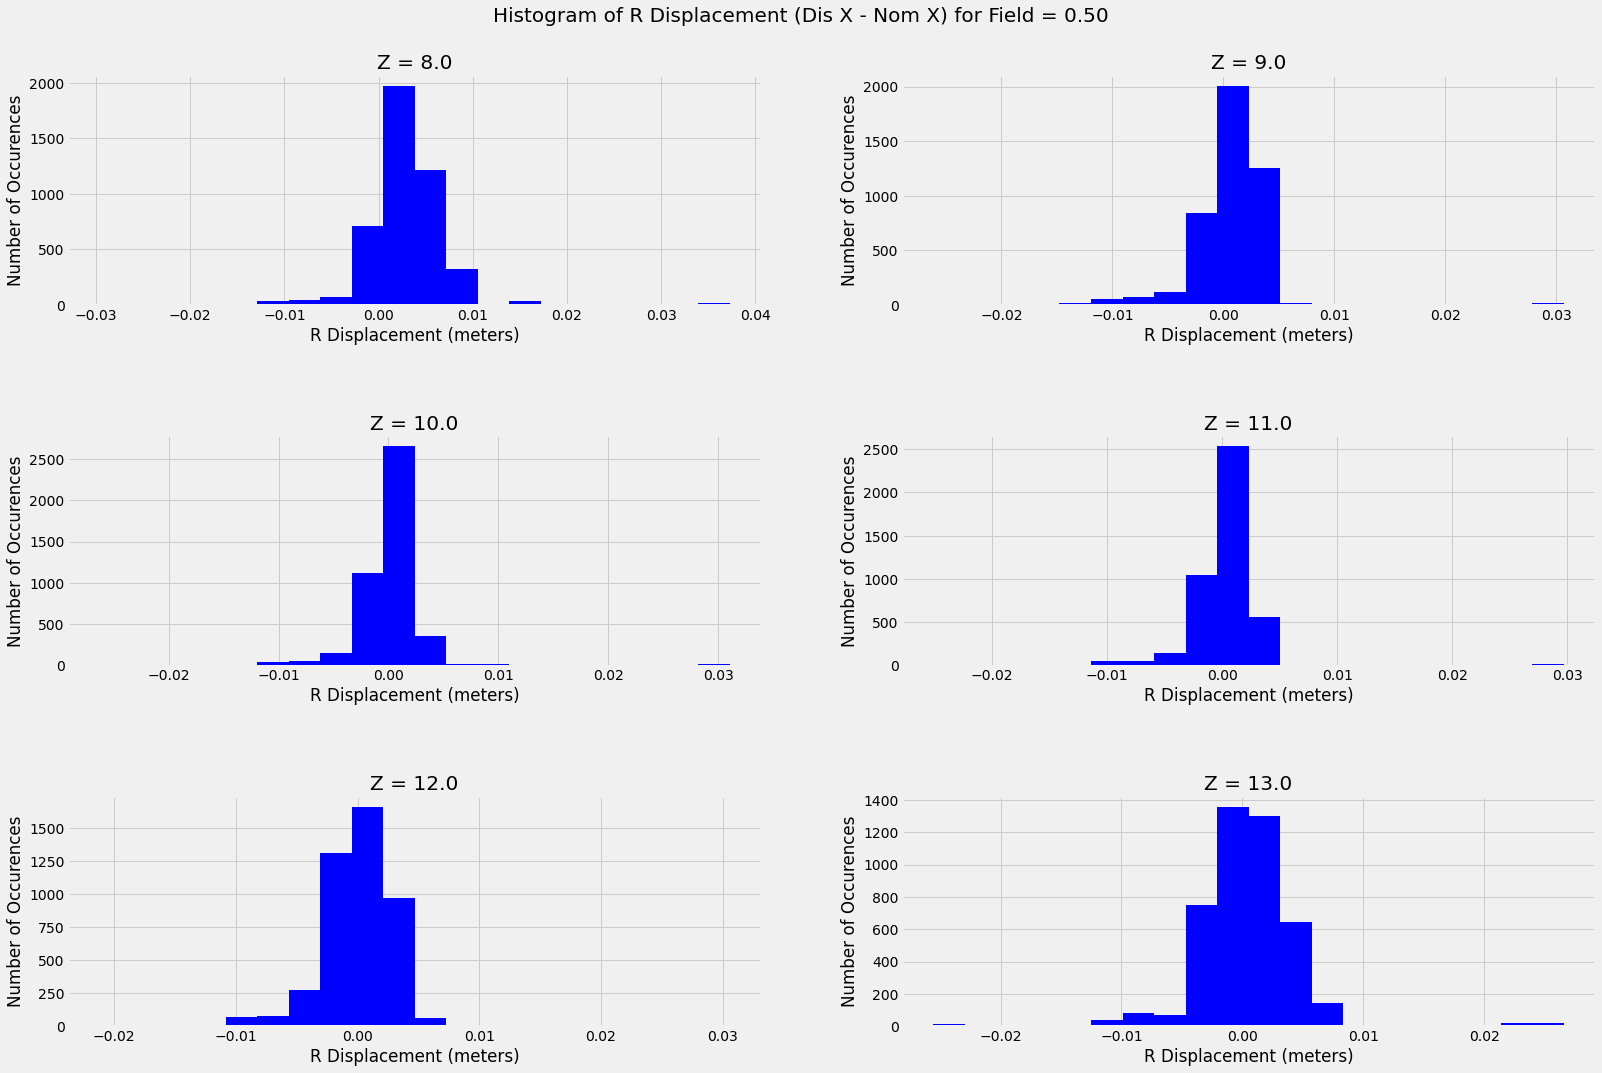

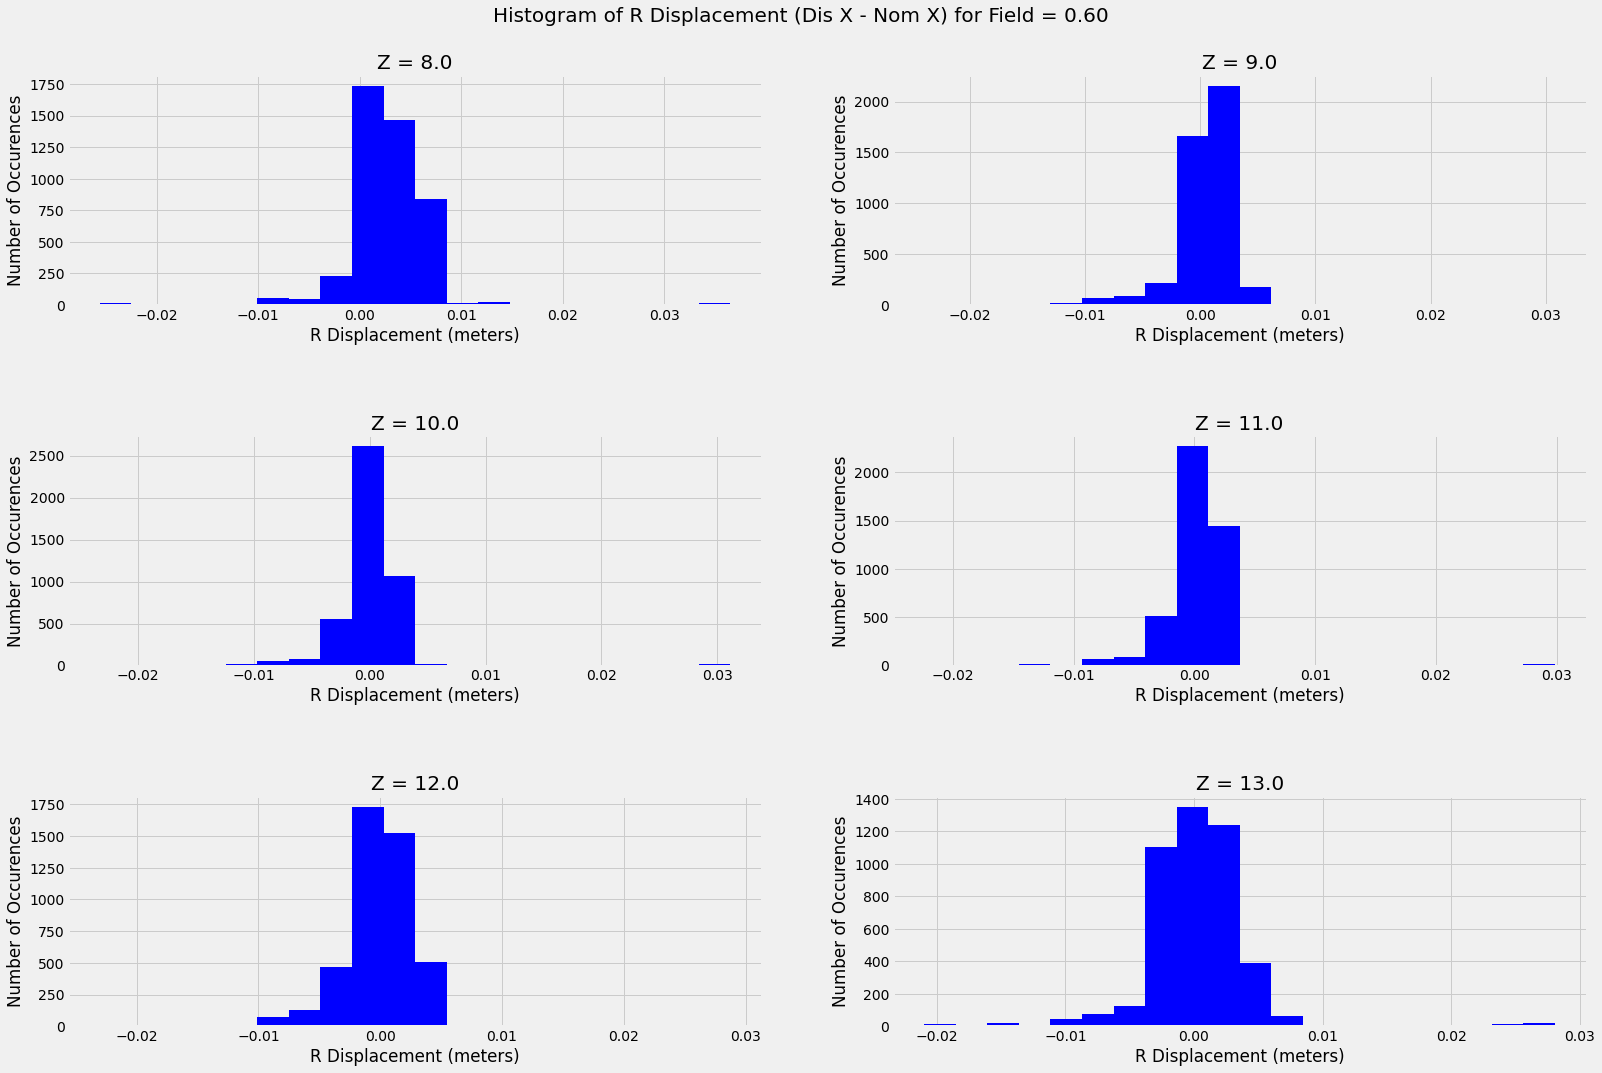

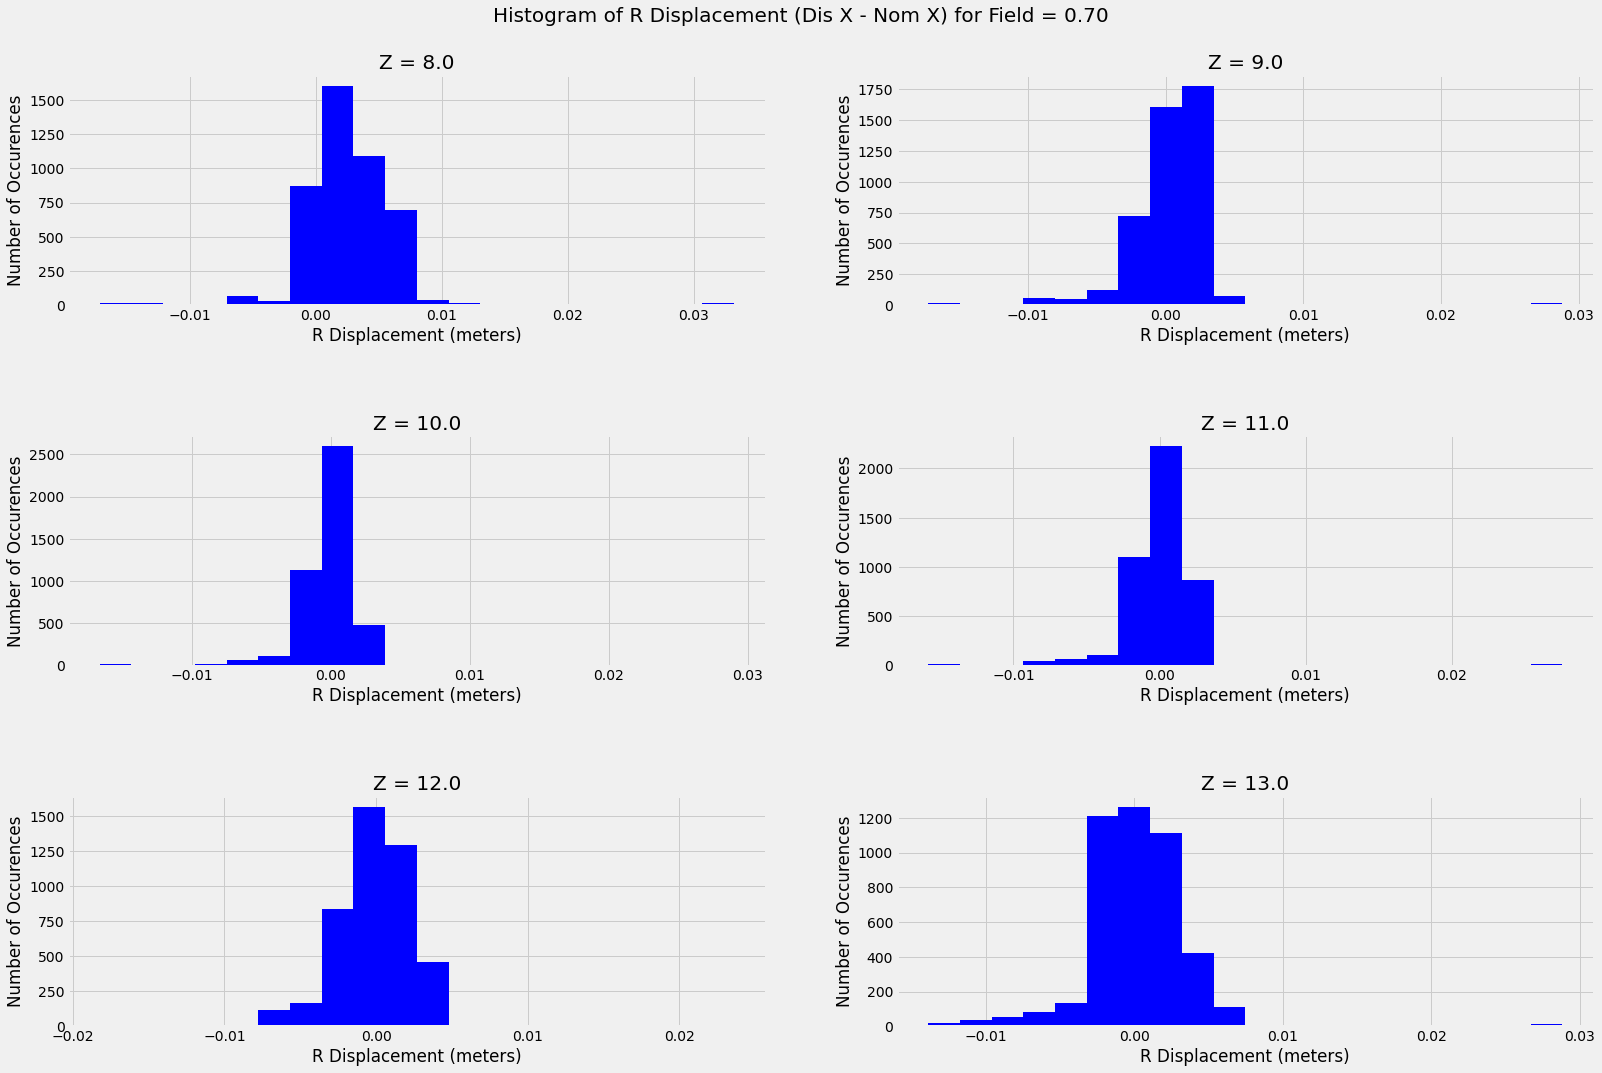

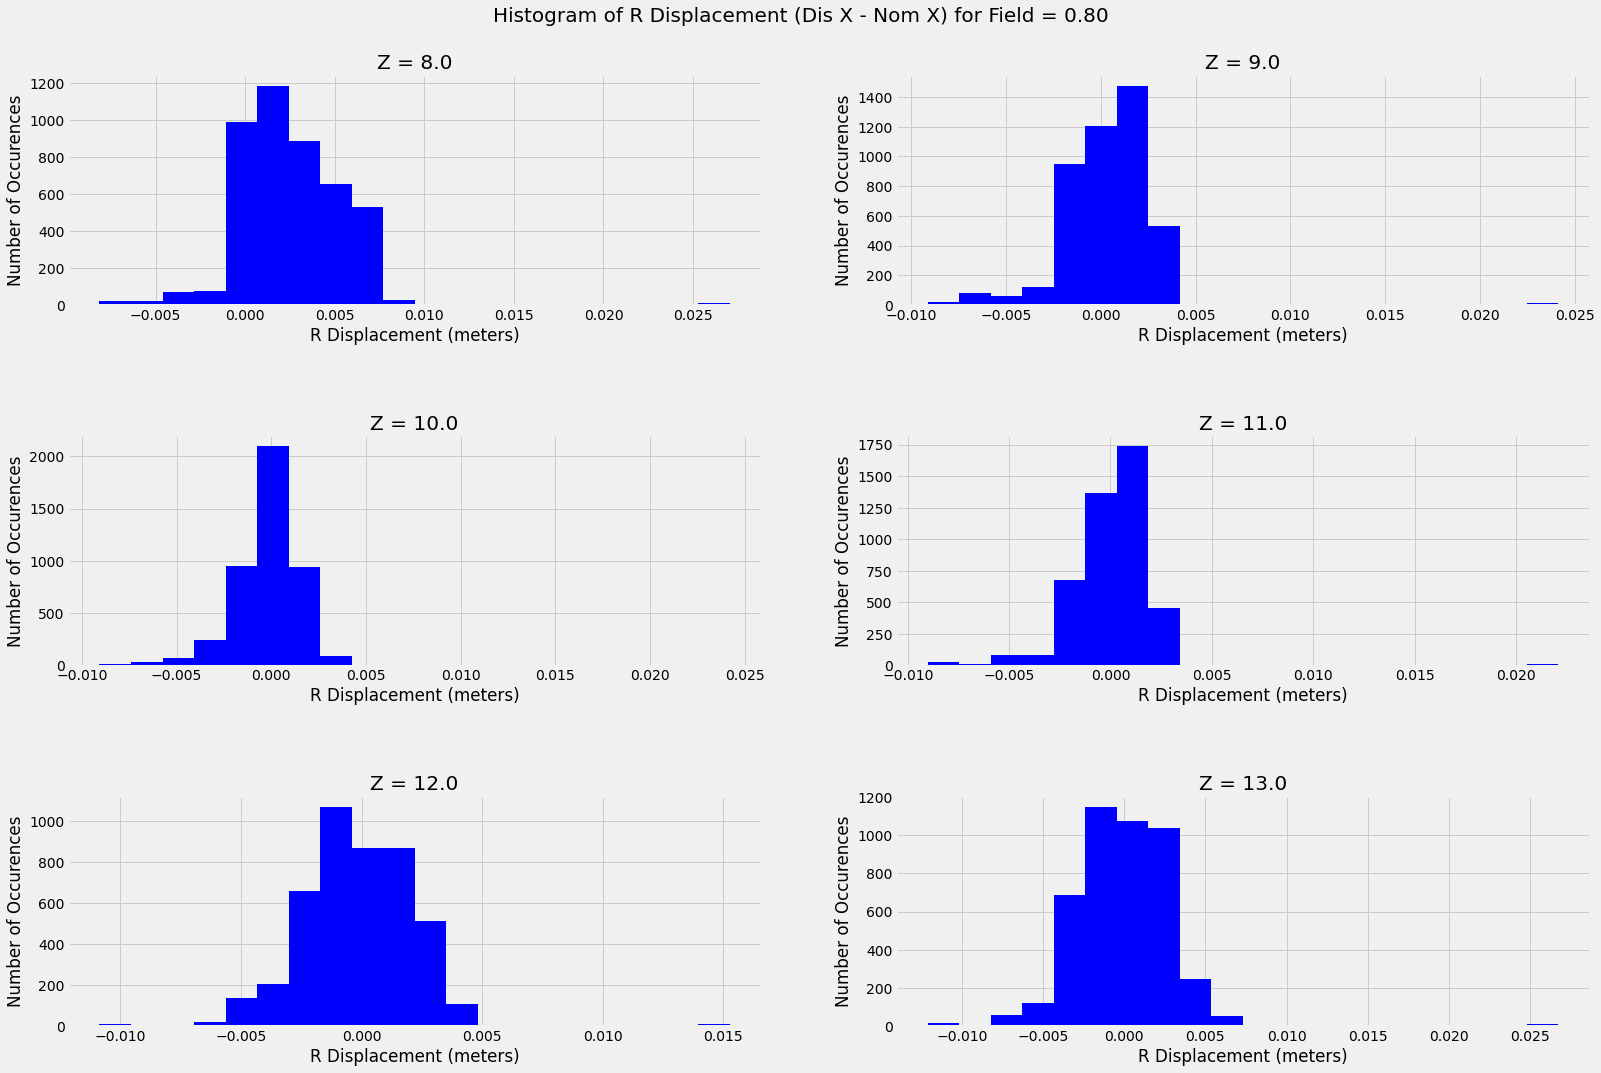

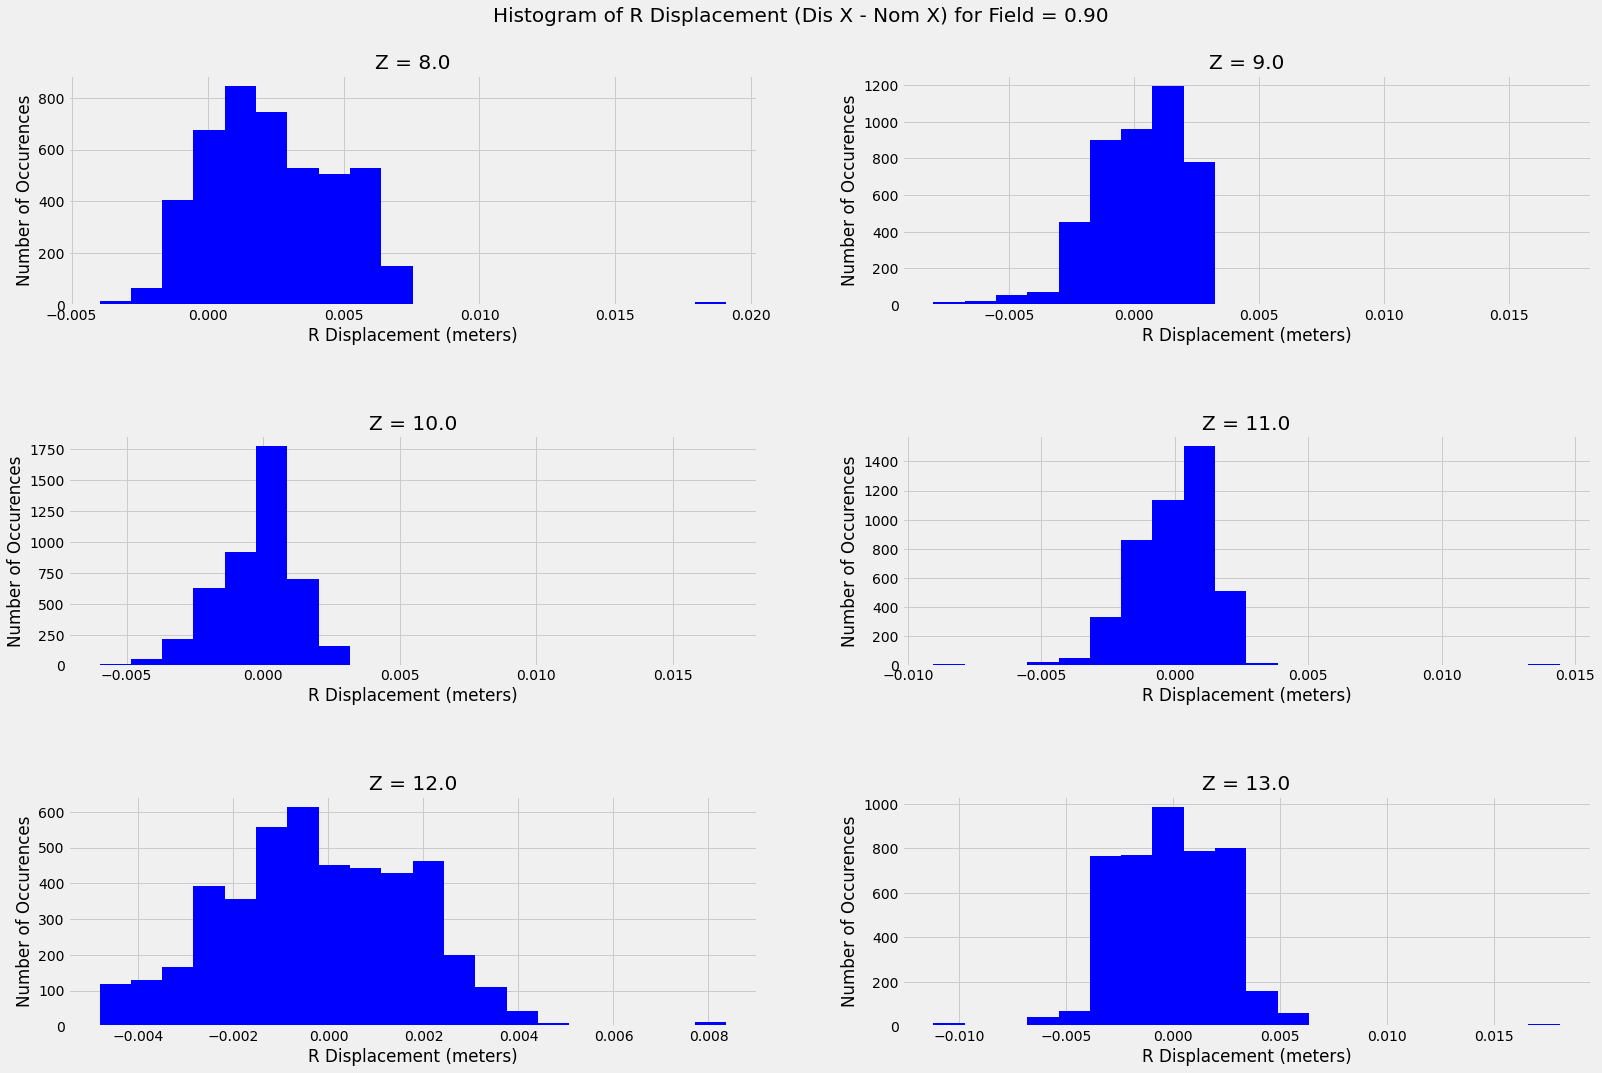

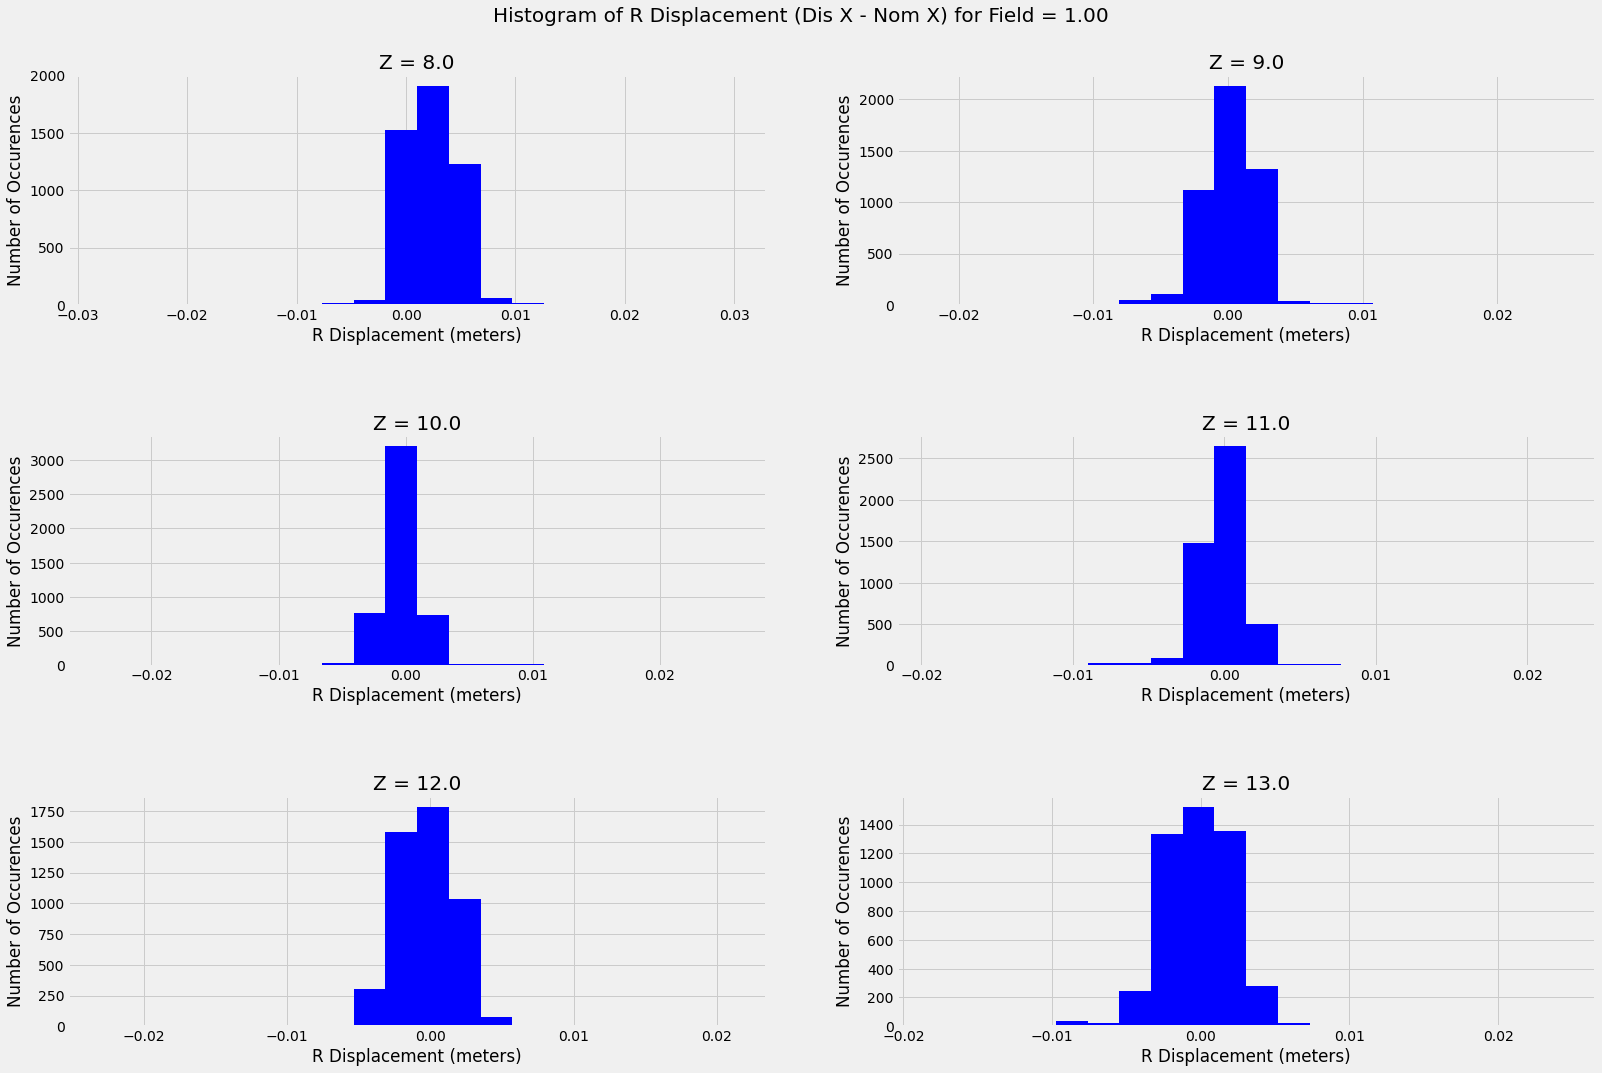

In [35]:
for field in datadf2['field'].unique():
    fig = plt.figure()
    df1 = datadf2[(datadf2['z']==zvals2[0]) & (datadf2['field']==field)]
    df2 = datadf2[(datadf2['z']==zvals2[1]) & (datadf2['field']==field)]
    df3 = datadf2[(datadf2['z']==zvals2[2]) & (datadf2['field']==field)]
    df4 = datadf2[(datadf2['z']==zvals2[3]) & (datadf2['field']==field)]
    df5 = datadf2[(datadf2['z']==zvals2[4]) & (datadf2['field']==field)]
    df6 = datadf2[(datadf2['z']==zvals2[5]) & (datadf2['field']==field)]
    
    ax1 = plt.subplot2grid((3,2), (0,0), rowspan=1, colspan=1)
    ax1.hist(list(df1['rdif']), bins = 20, facecolor = 'blue')
    ax1.set_title(f'Z = {zvals2[0]}')
    ax1.set_ylabel(f'Number of Occurences')
    ax1.set_xlabel(f'R Displacement (meters)')
    
    ax2 = plt.subplot2grid((3,2), (0,1), rowspan=1, colspan=1)
    ax2.hist(list(df2['rdif']), bins = 20, facecolor = 'blue')
    ax2.set_title(f'Z = {zvals2[1]}')
    ax2.set_ylabel(f'Number of Occurences')
    ax2.set_xlabel(f'R Displacement (meters)')
    
    ax3 = plt.subplot2grid((3,2), (1,0), rowspan=1, colspan=1)
    ax3.hist(list(df3['rdif']), bins = 20, facecolor = 'blue')
    ax3.set_title(f'Z = {zvals2[2]}')
    ax3.set_ylabel(f'Number of Occurences')
    ax3.set_xlabel(f'R Displacement (meters)')
    
    ax4 = plt.subplot2grid((3,2), (1,1), rowspan=1, colspan=1)
    ax4.hist(list(df4['rdif']), bins = 20, facecolor = 'blue')
    ax4.set_title(f'Z = {zvals2[3]}')
    ax4.set_ylabel(f'Number of Occurences')
    ax4.set_xlabel(f'R Displacement (meters)')
    
    ax5 = plt.subplot2grid((3,2), (2,0), rowspan=1, colspan=1)
    ax5.hist(list(df5['rdif']), bins = 20, facecolor = 'blue')
    ax5.set_title(f'Z = {zvals2[4]}')
    ax5.set_ylabel(f'Number of Occurences')
    ax5.set_xlabel(f'R Displacement (meters)')
    
    ax6 = plt.subplot2grid((3,2), (2,1), rowspan=1, colspan=1)
    ax6.hist(list(df6['rdif']), bins = 20, facecolor = 'blue')
    ax6.set_title(f'Z = {zvals2[5]}')
    ax6.set_ylabel(f'Number of Occurences')
    ax6.set_xlabel(f'R Displacement (meters)')
    
    fig.suptitle(f'Histogram of R Displacement (Dis X - Nom X) for Field = {field}', fontsize = 20)
    fig.tight_layout(pad = 5.0)
    fig.savefig(plotdir2+f'/X_hist_{field}.png')

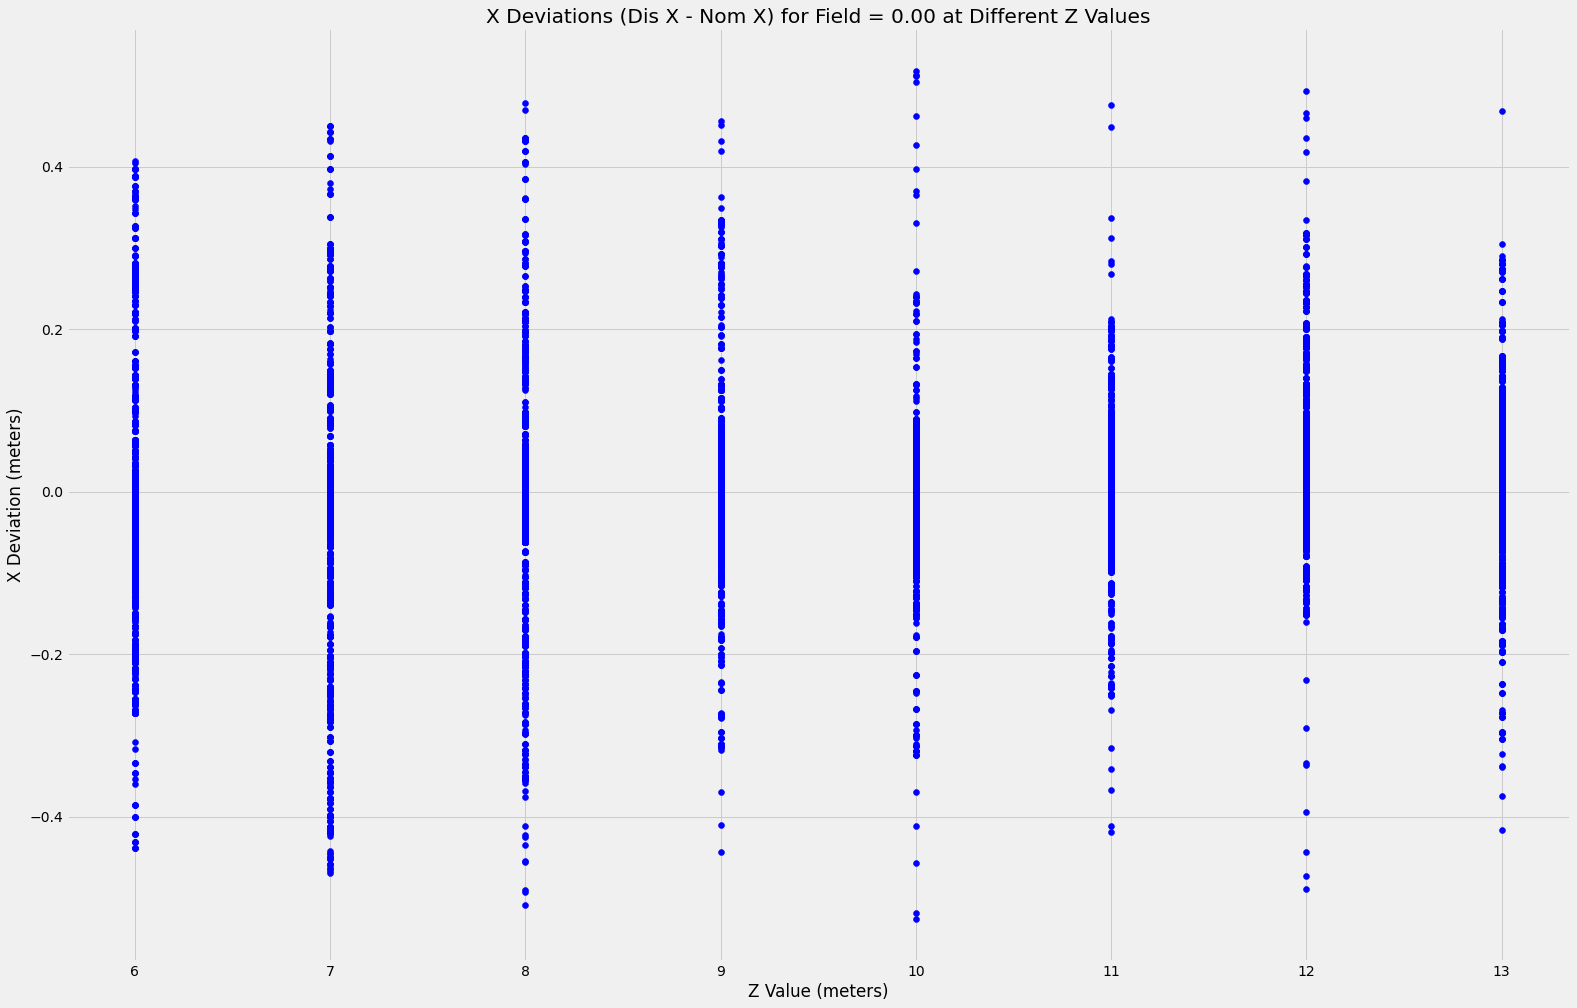

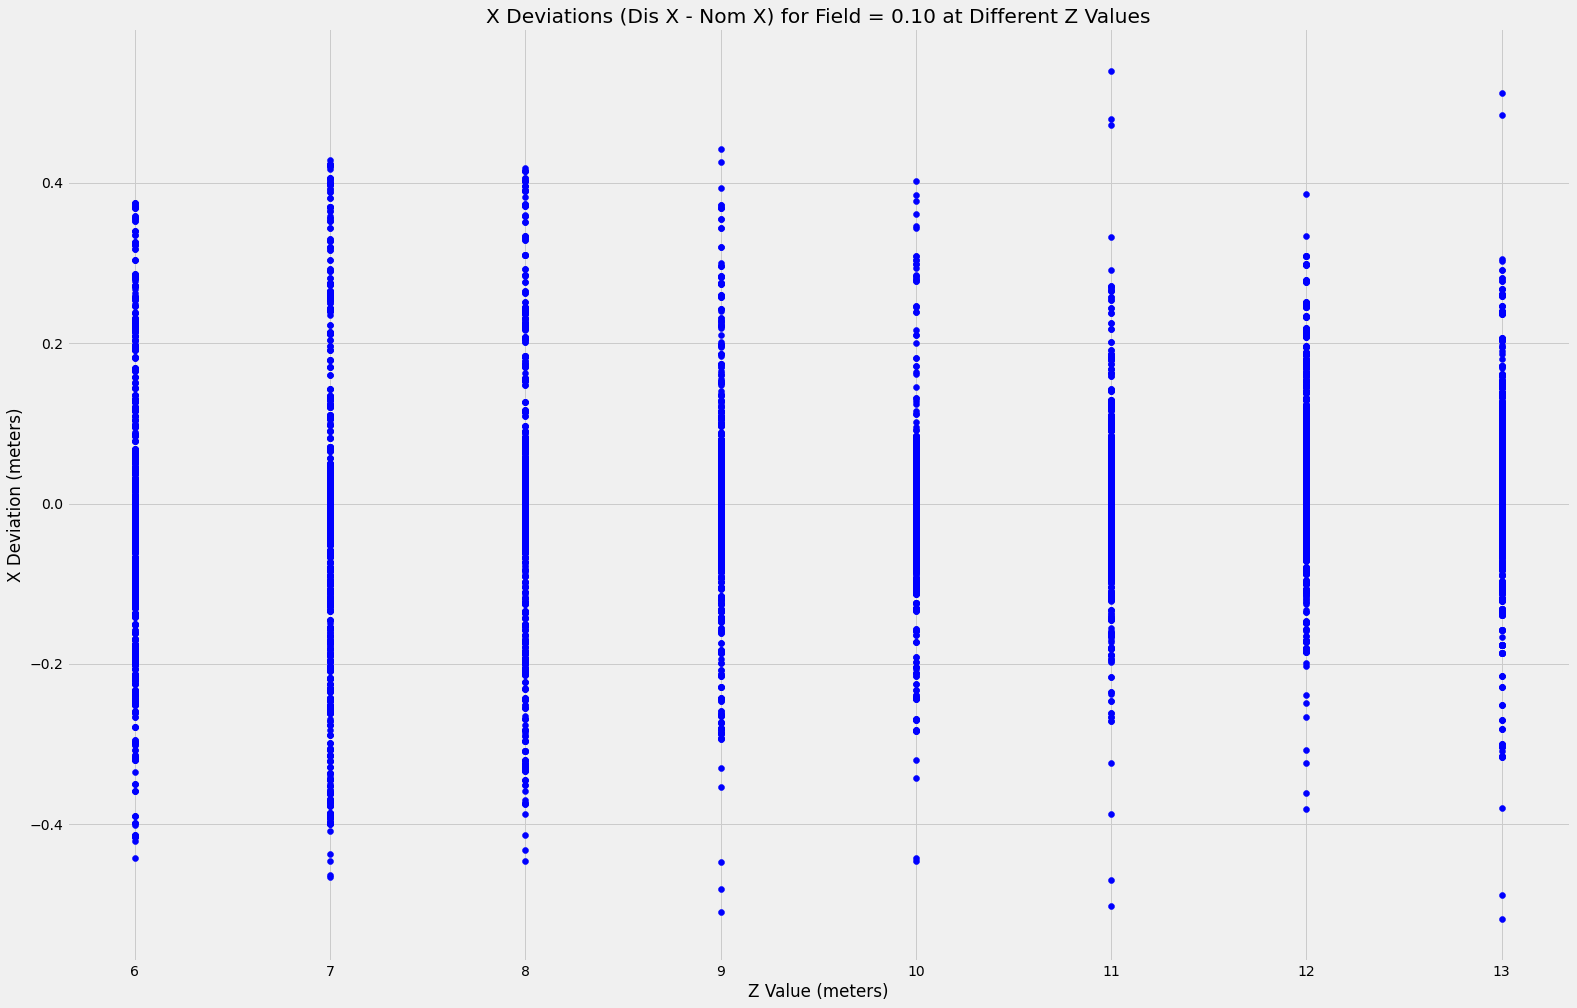

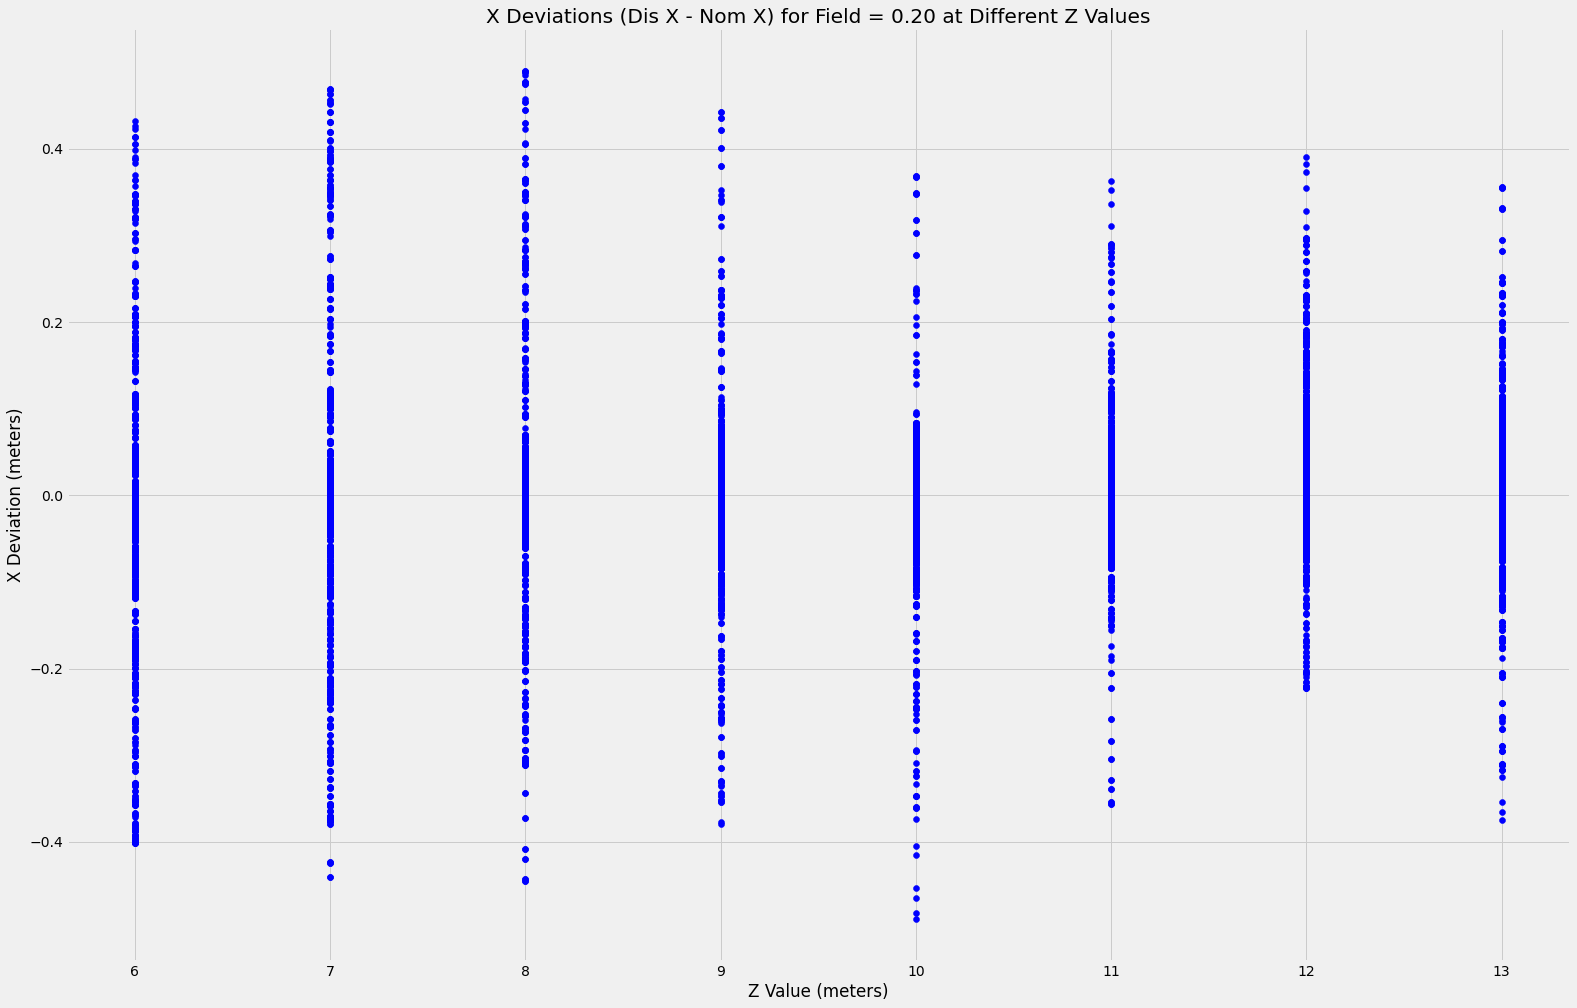

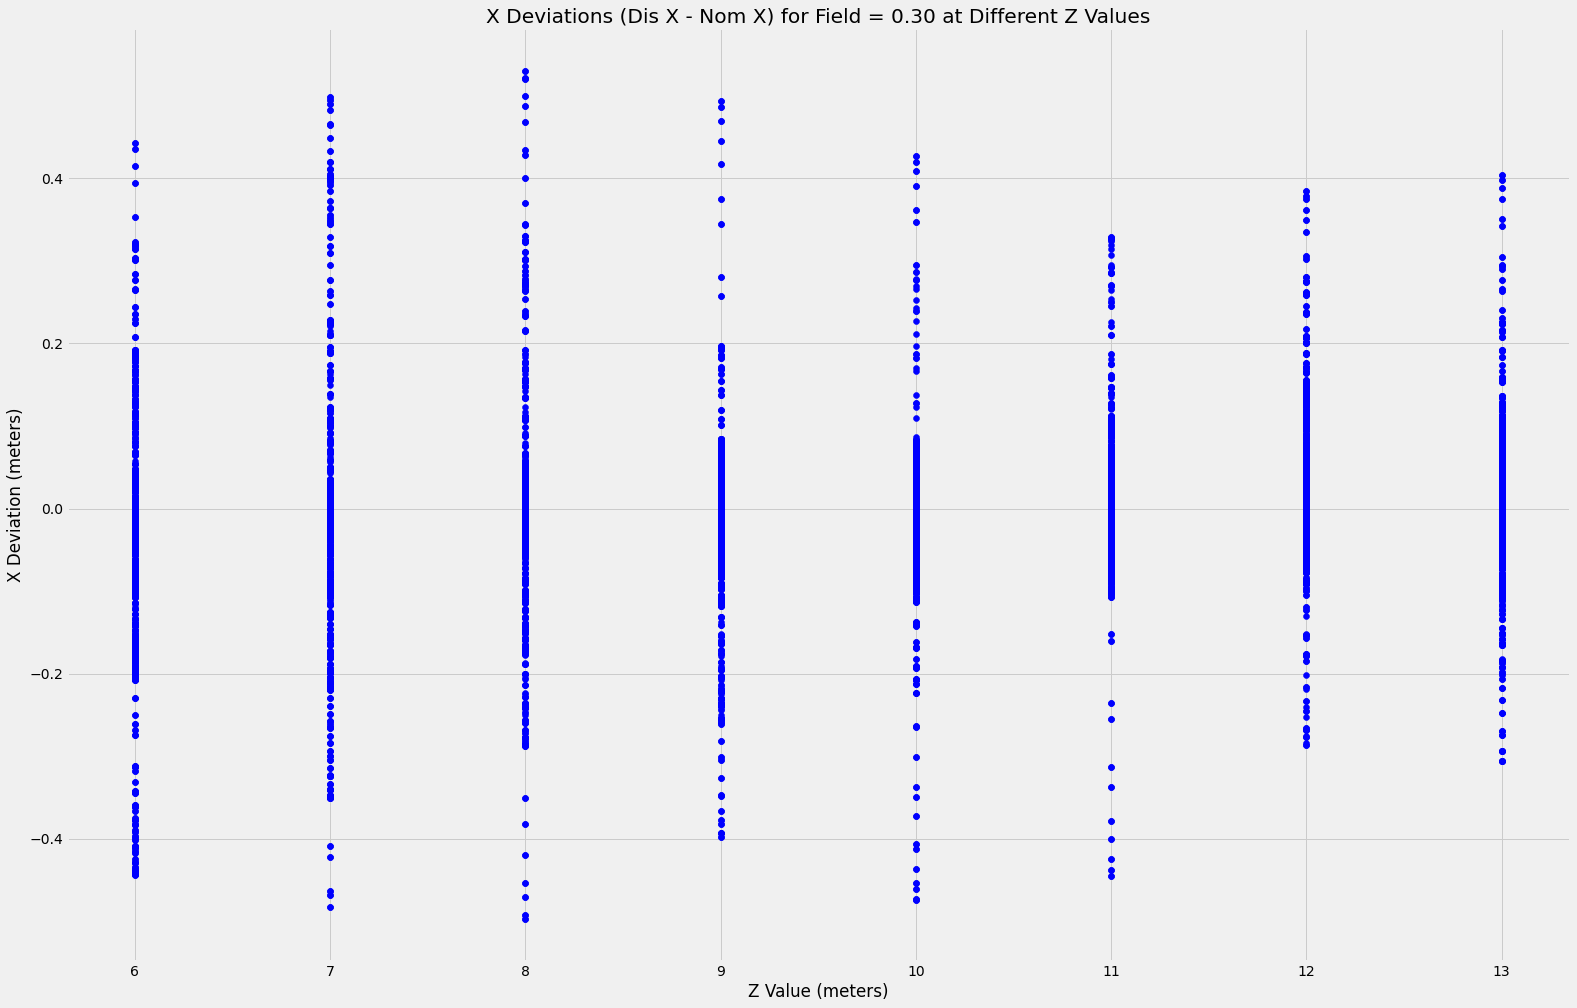

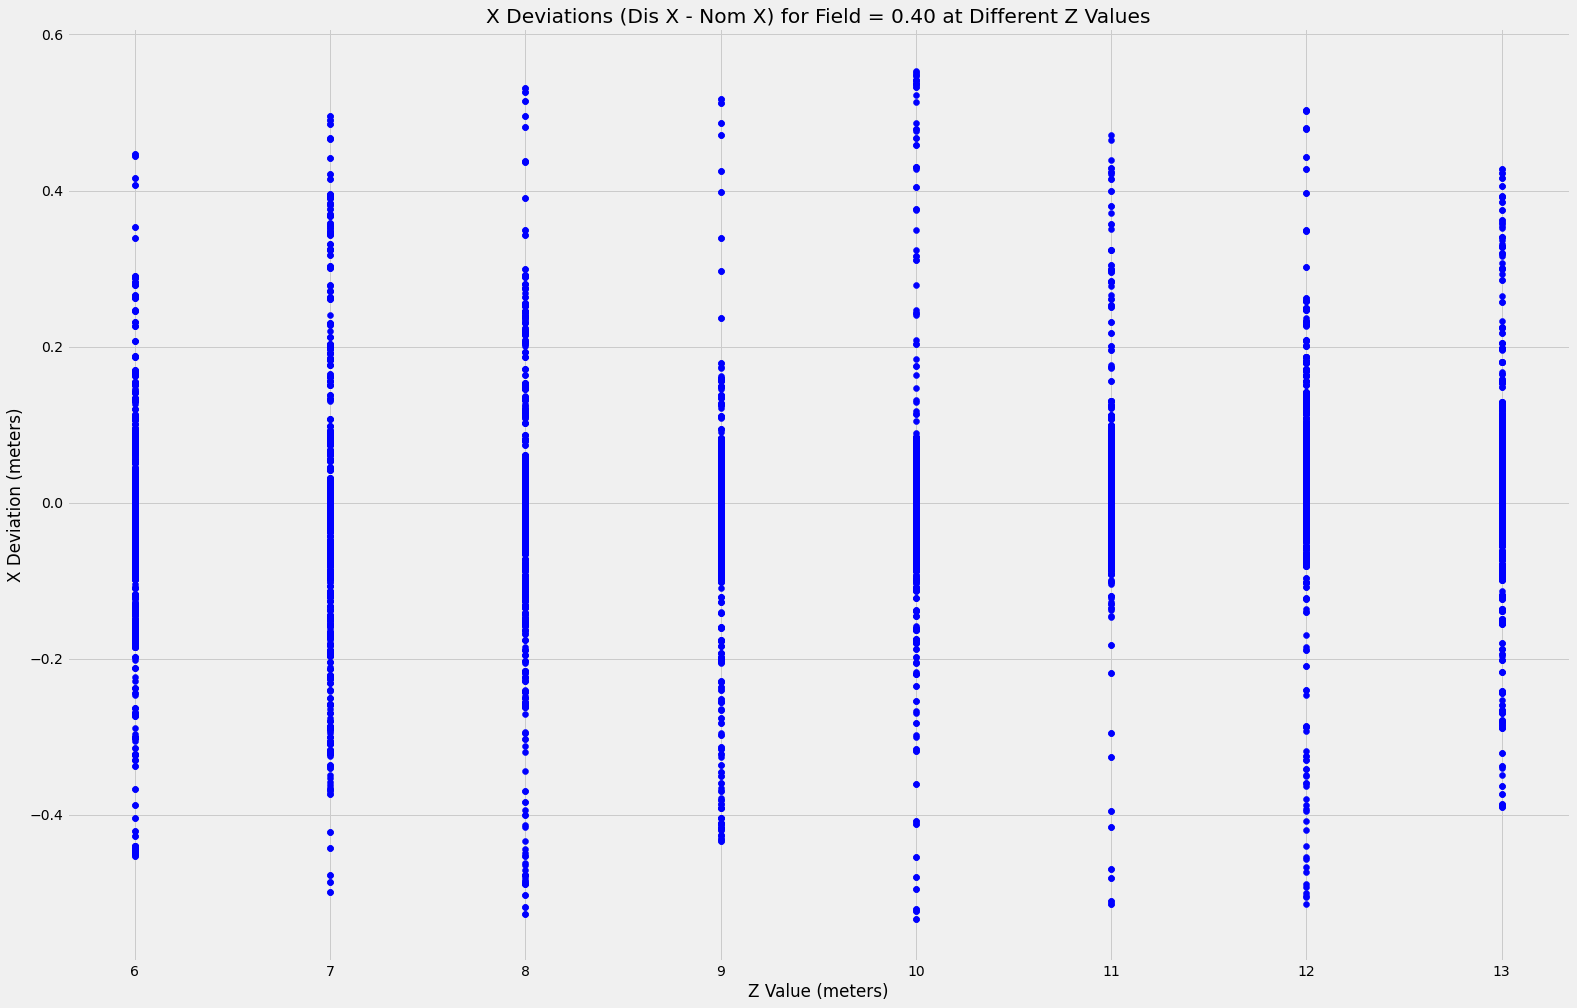

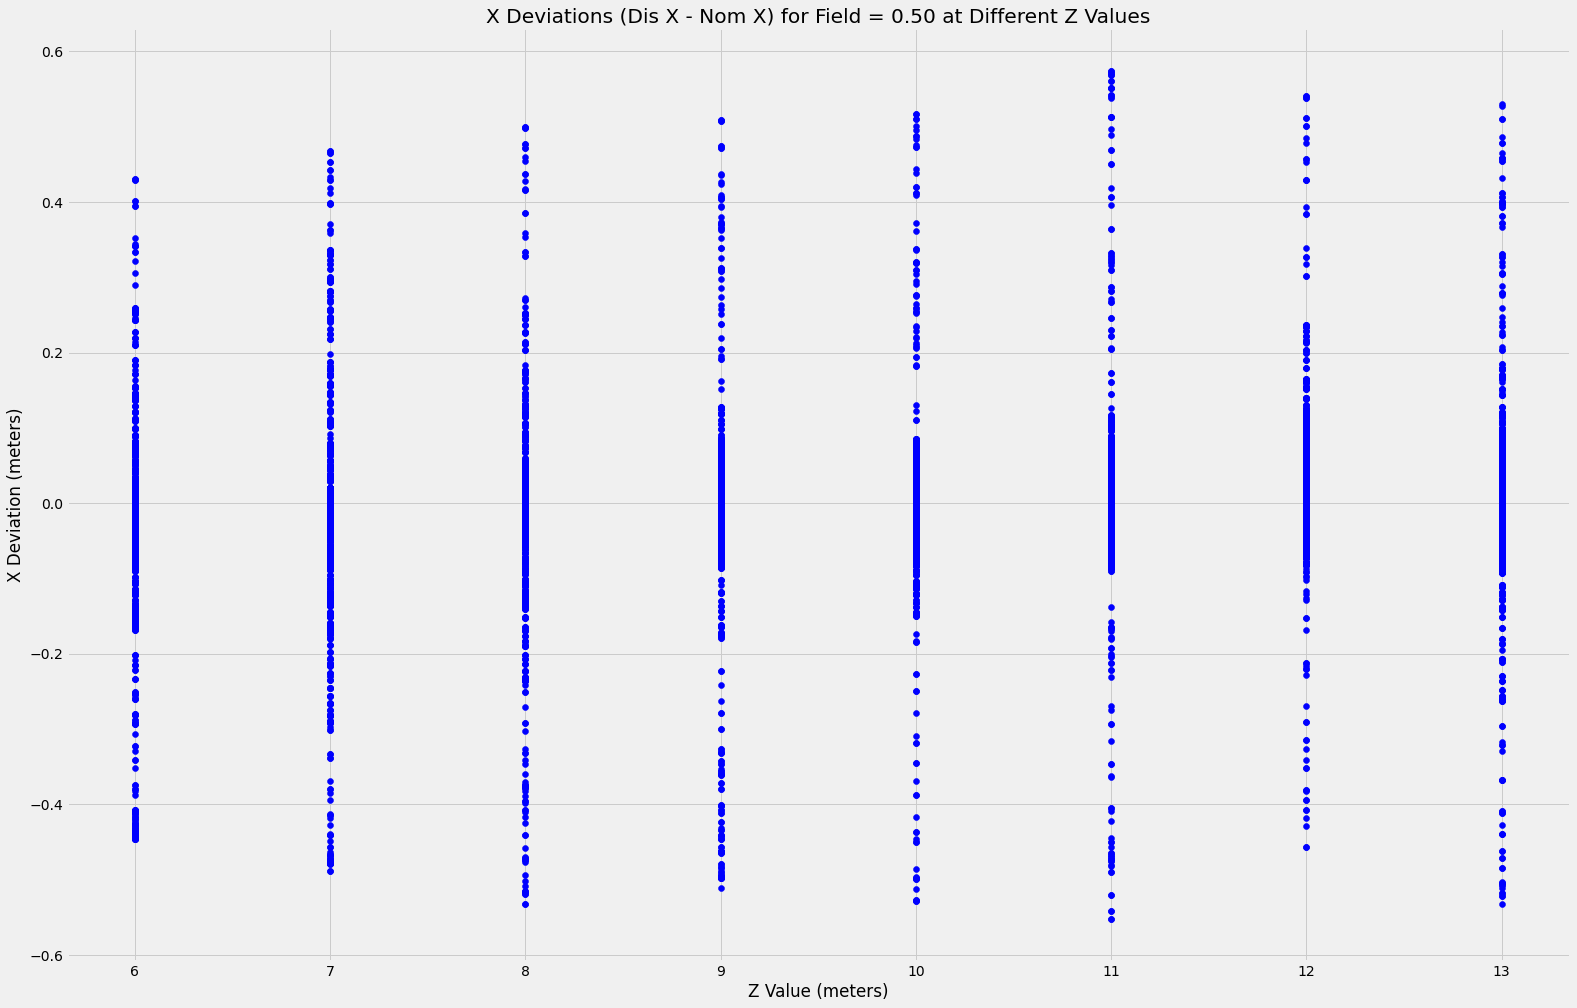

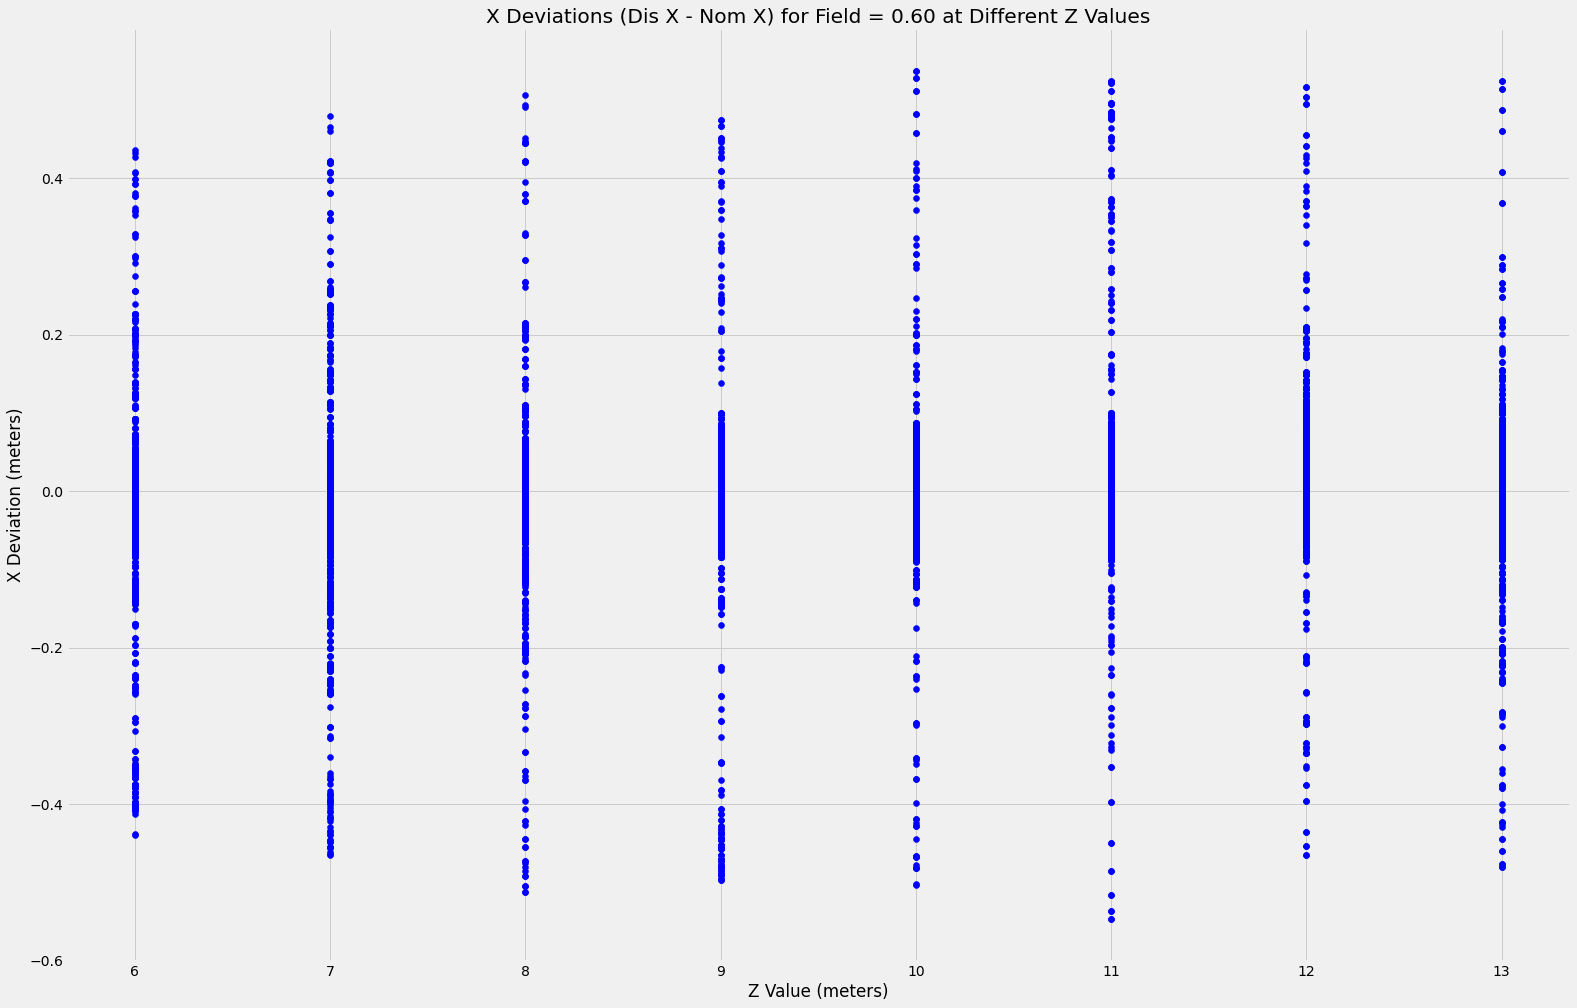

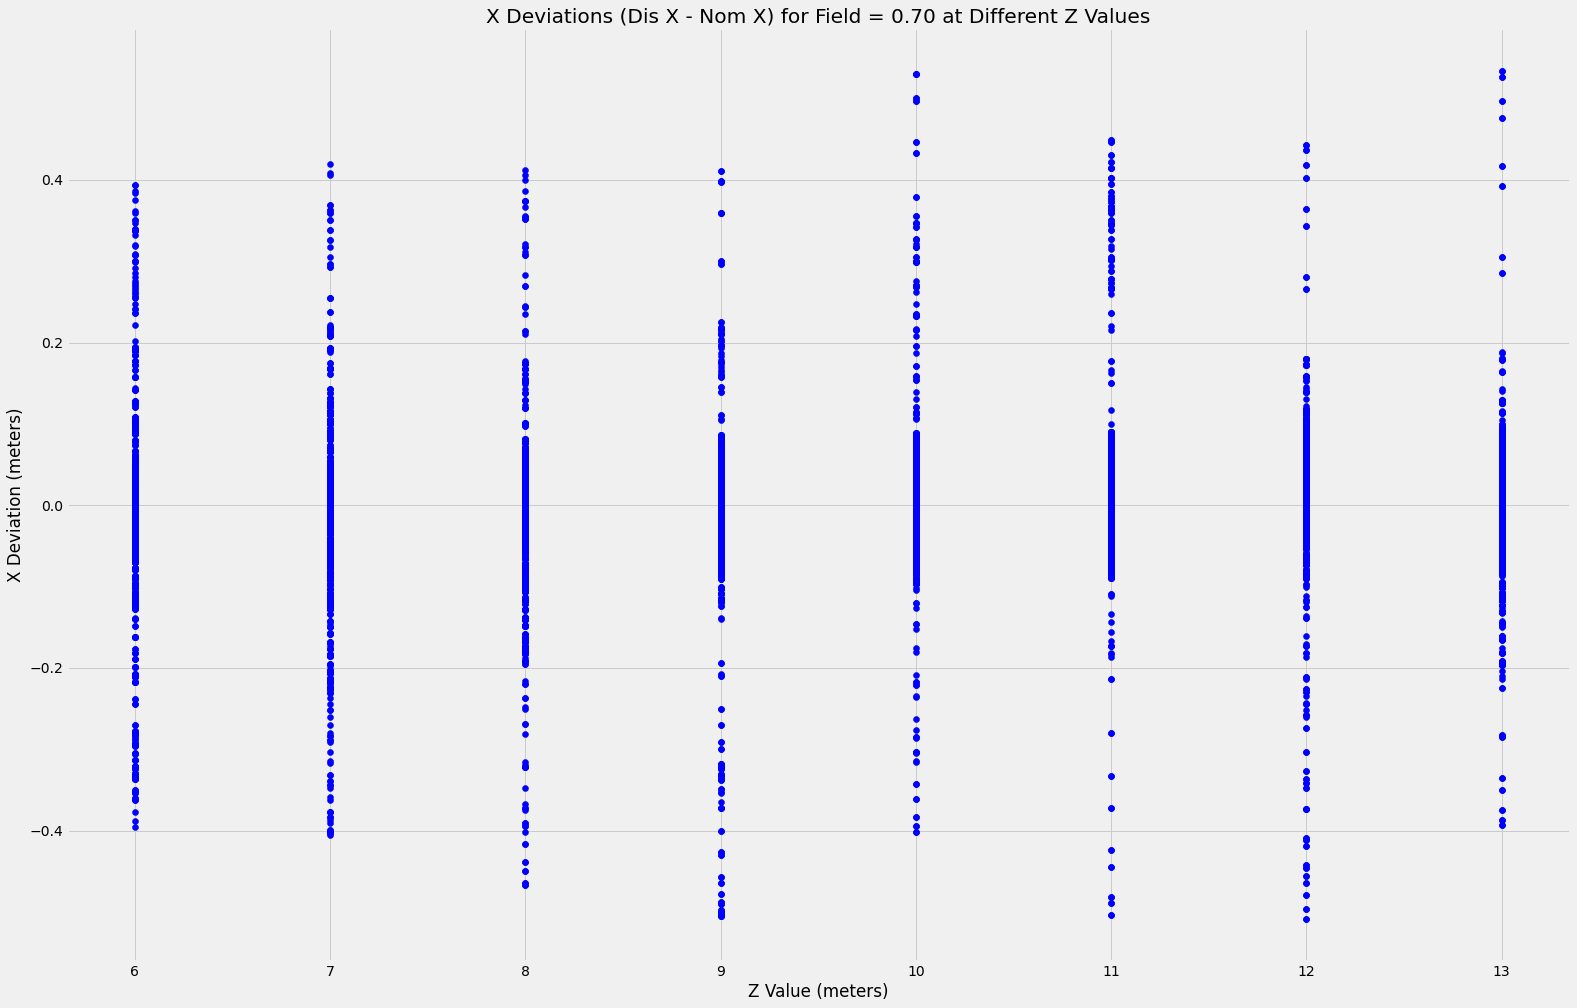

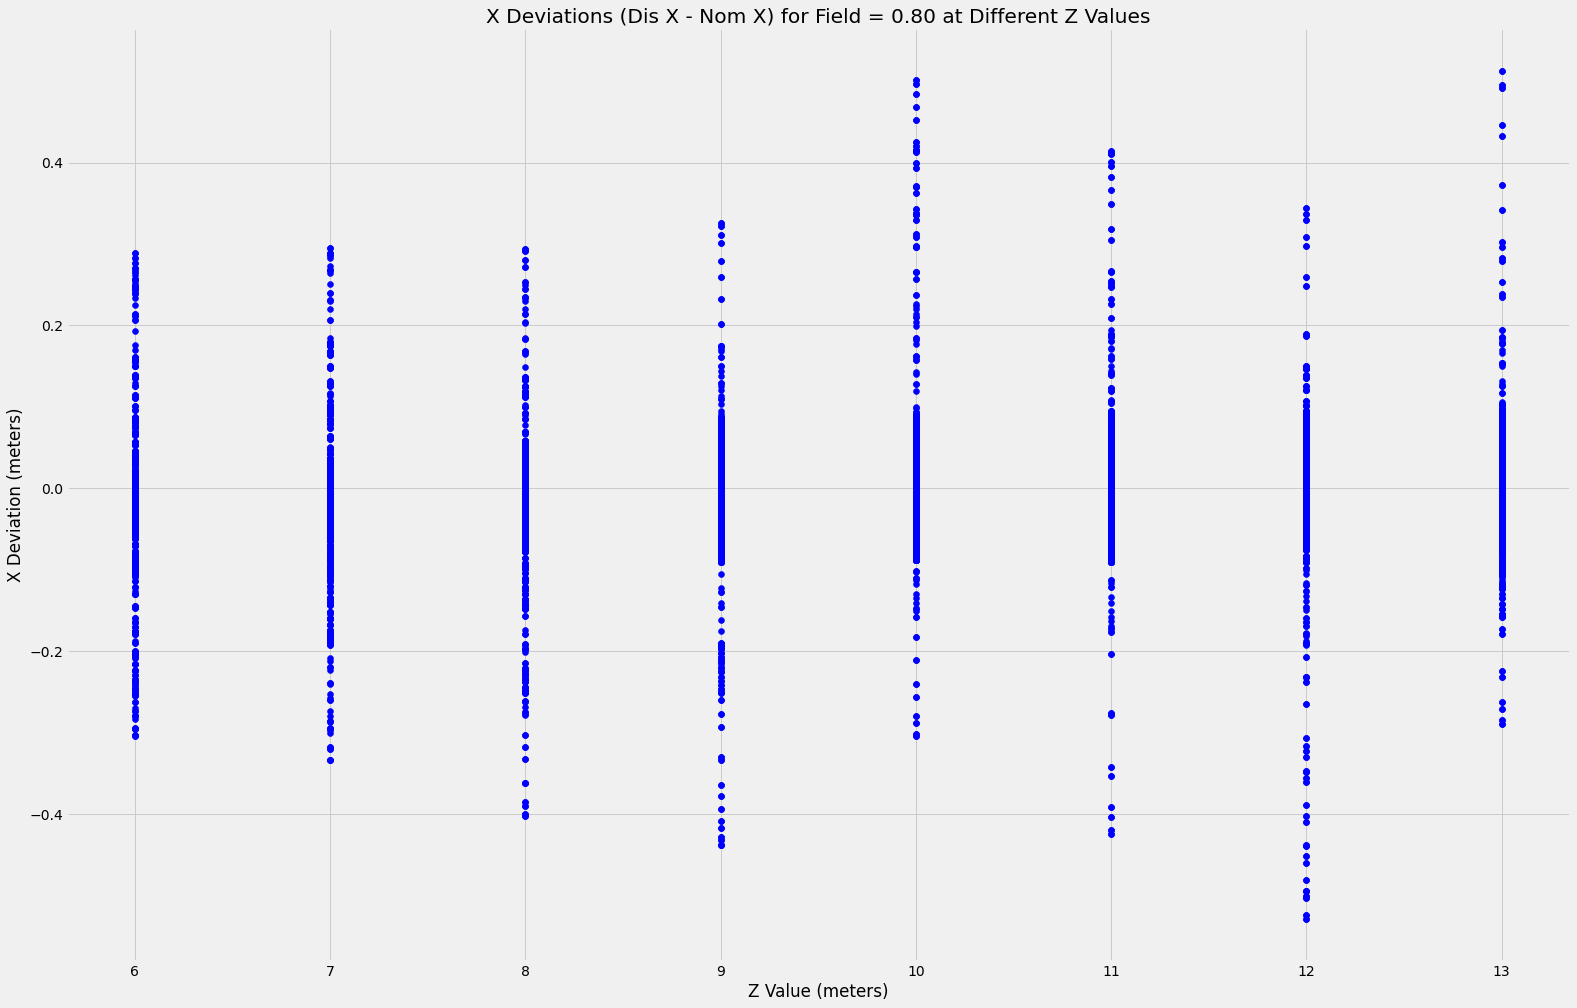

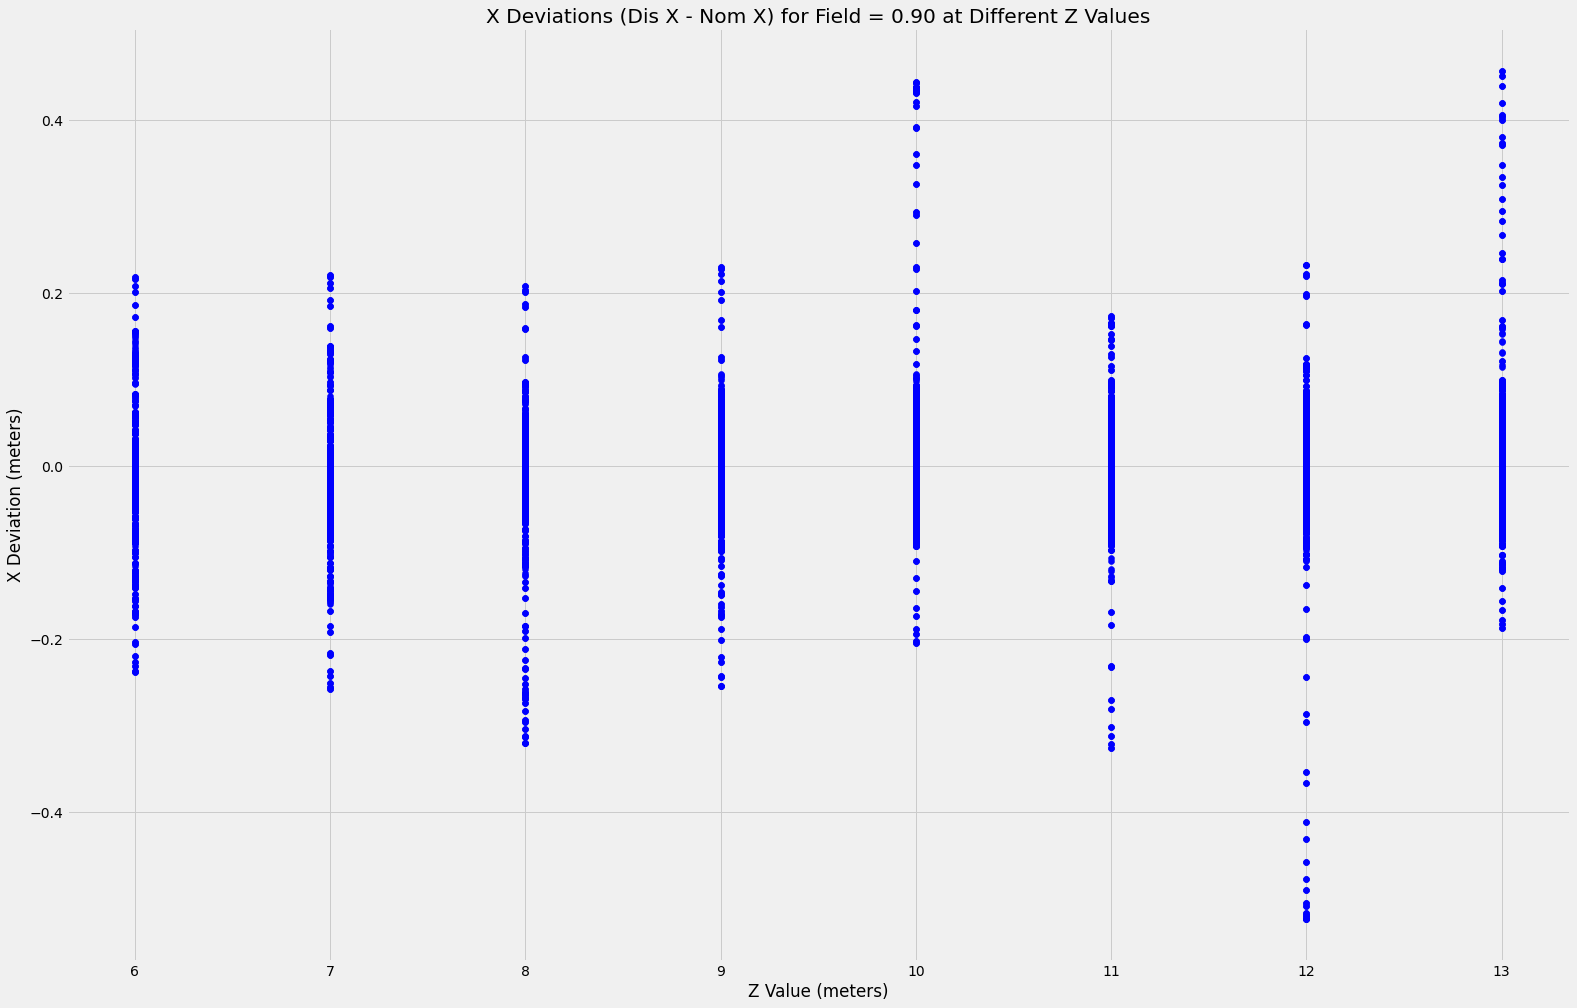

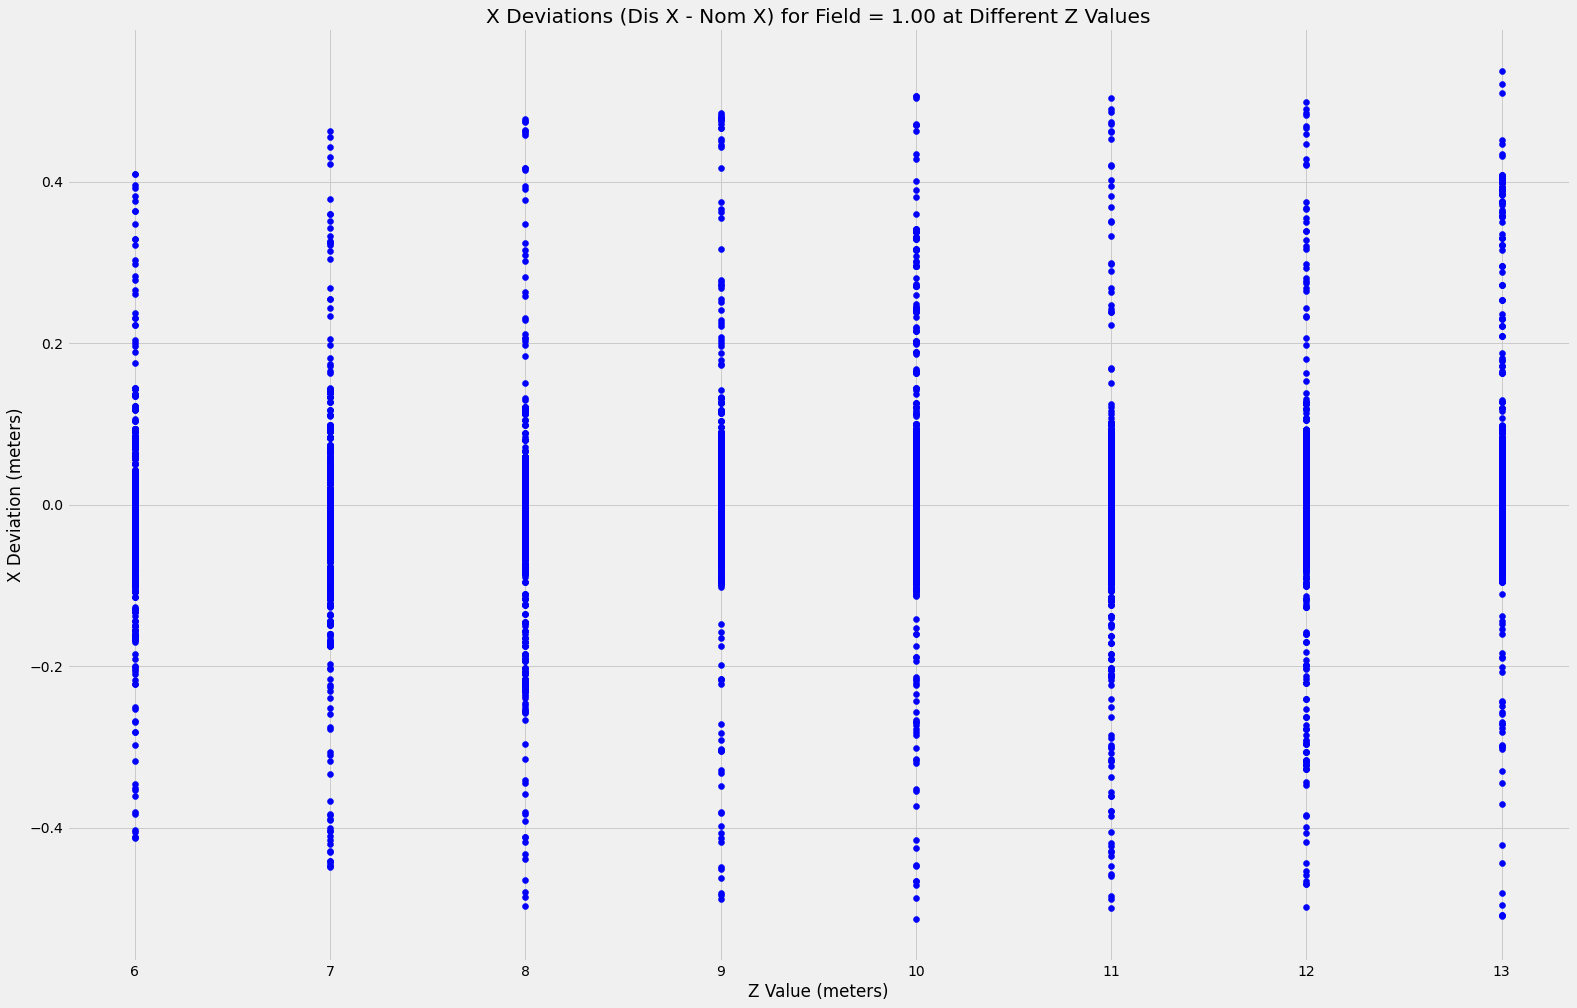

In [36]:
for field in fieldvals:
    newdf = datadf[datadf['field']==field]
    fig = plt.figure()
    plt.scatter(newdf['z'], newdf['xdif'], c = 'blue')
    plt.title(f'X Deviations (Dis X - Nom X) for Field = {field} at Different Z Values')
    plt.xlabel('Z Value (meters)')
    plt.ylabel('X Deviation (meters)')
    fig.savefig(plotdir+f'/deviations_{field}.png')

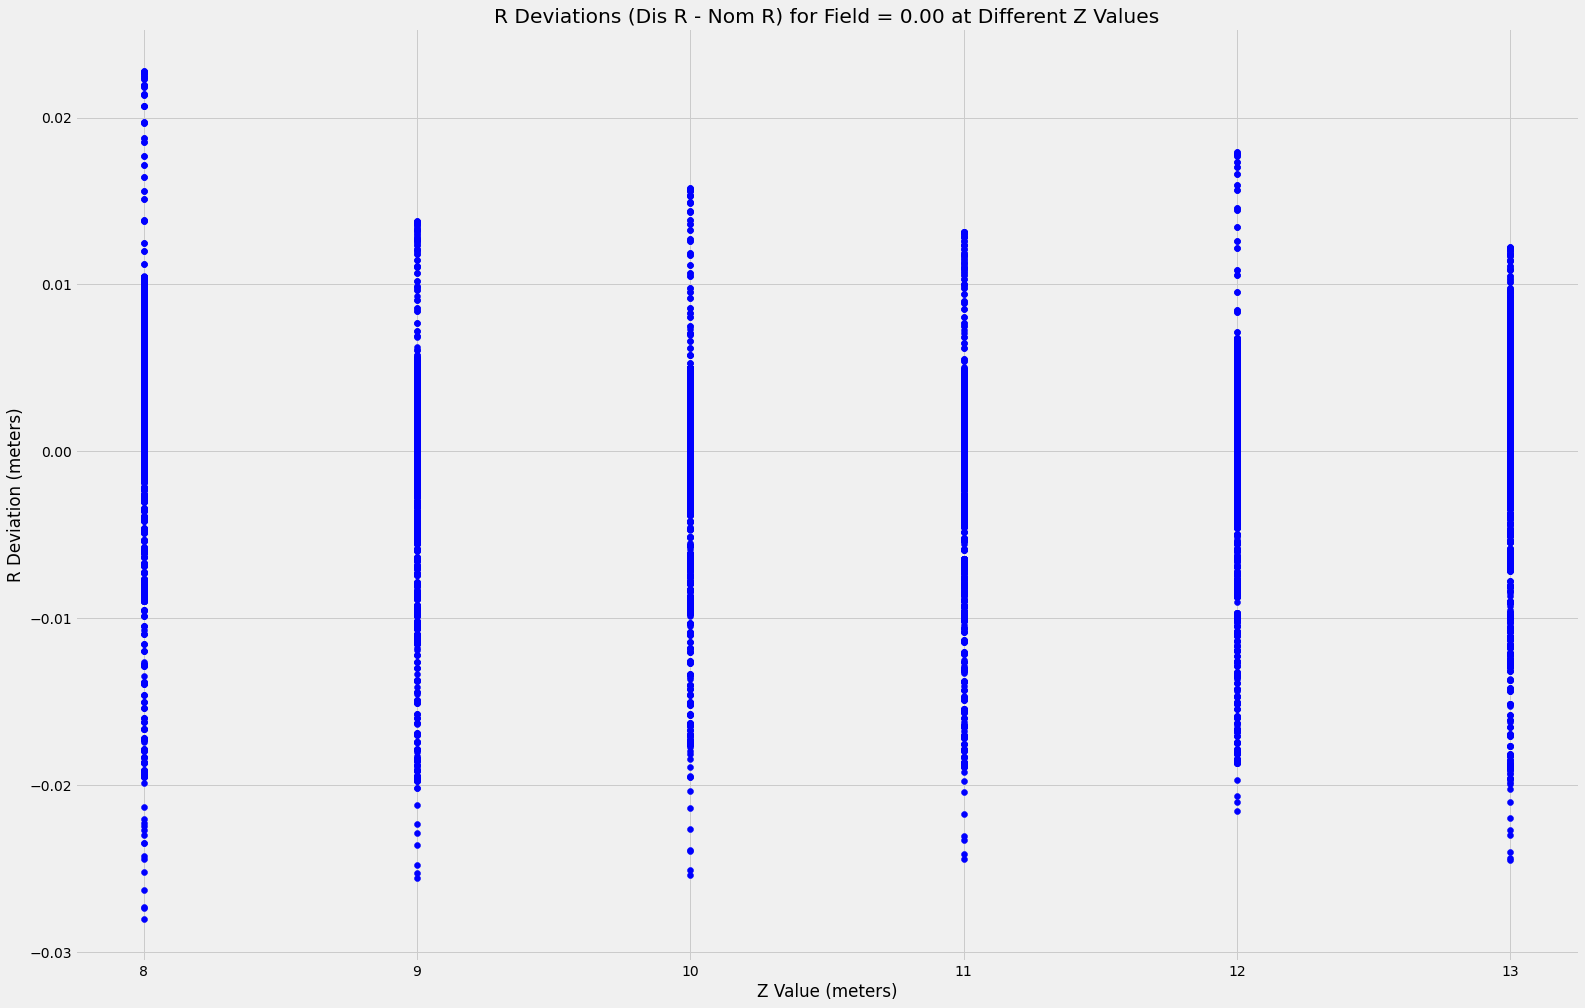

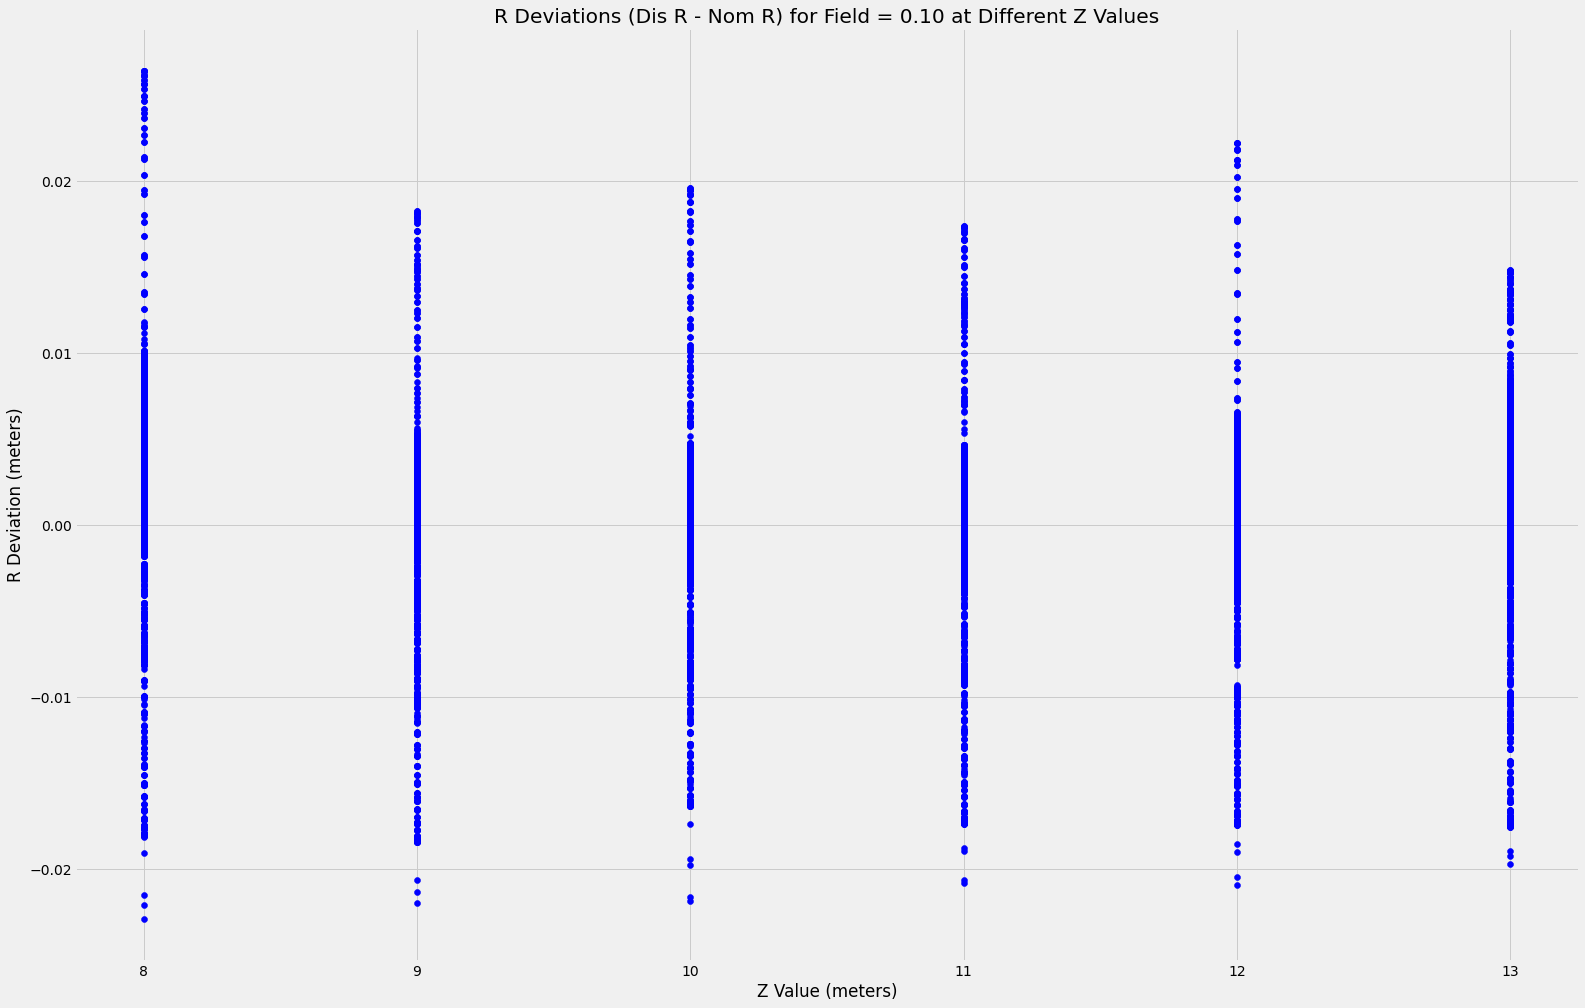

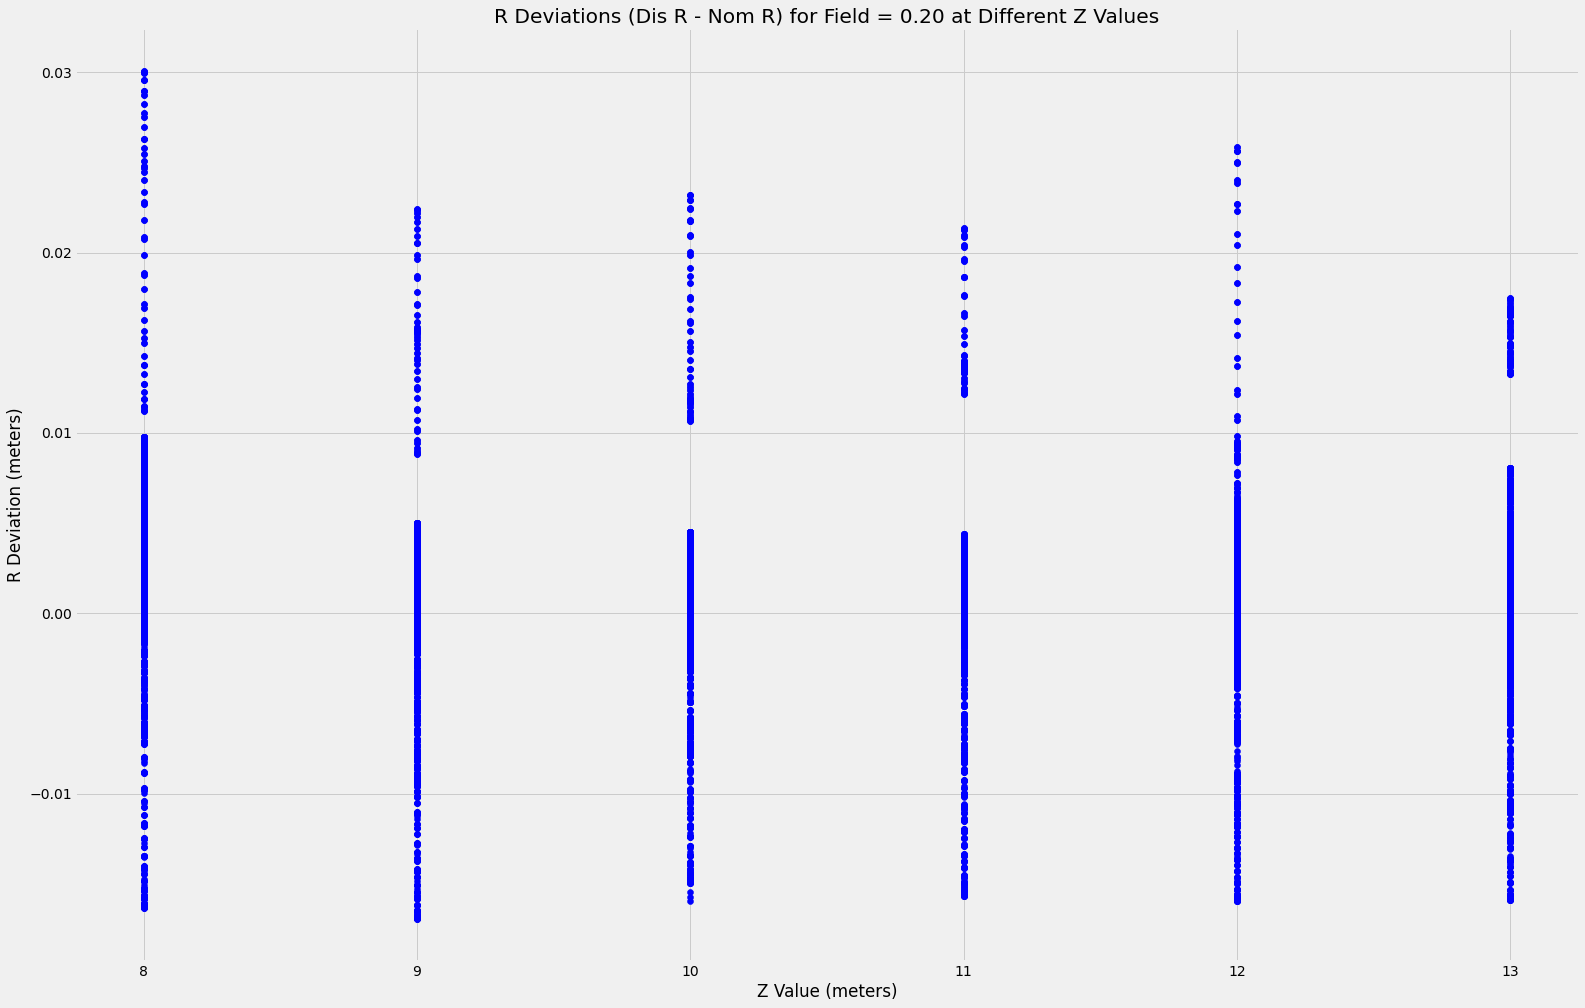

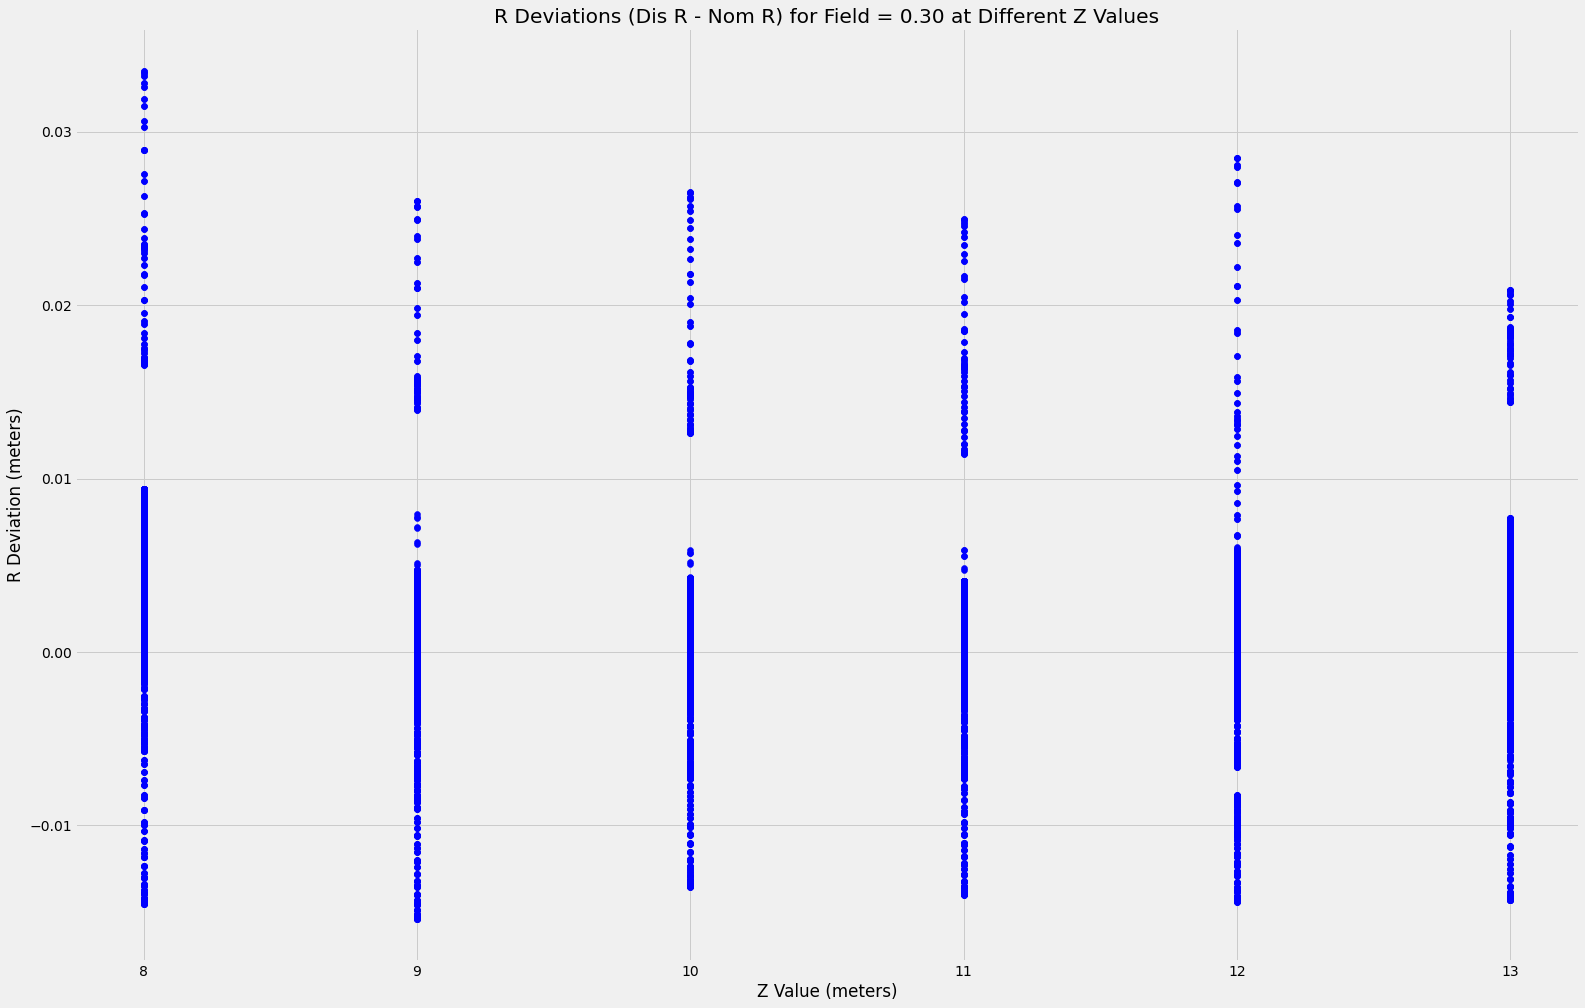

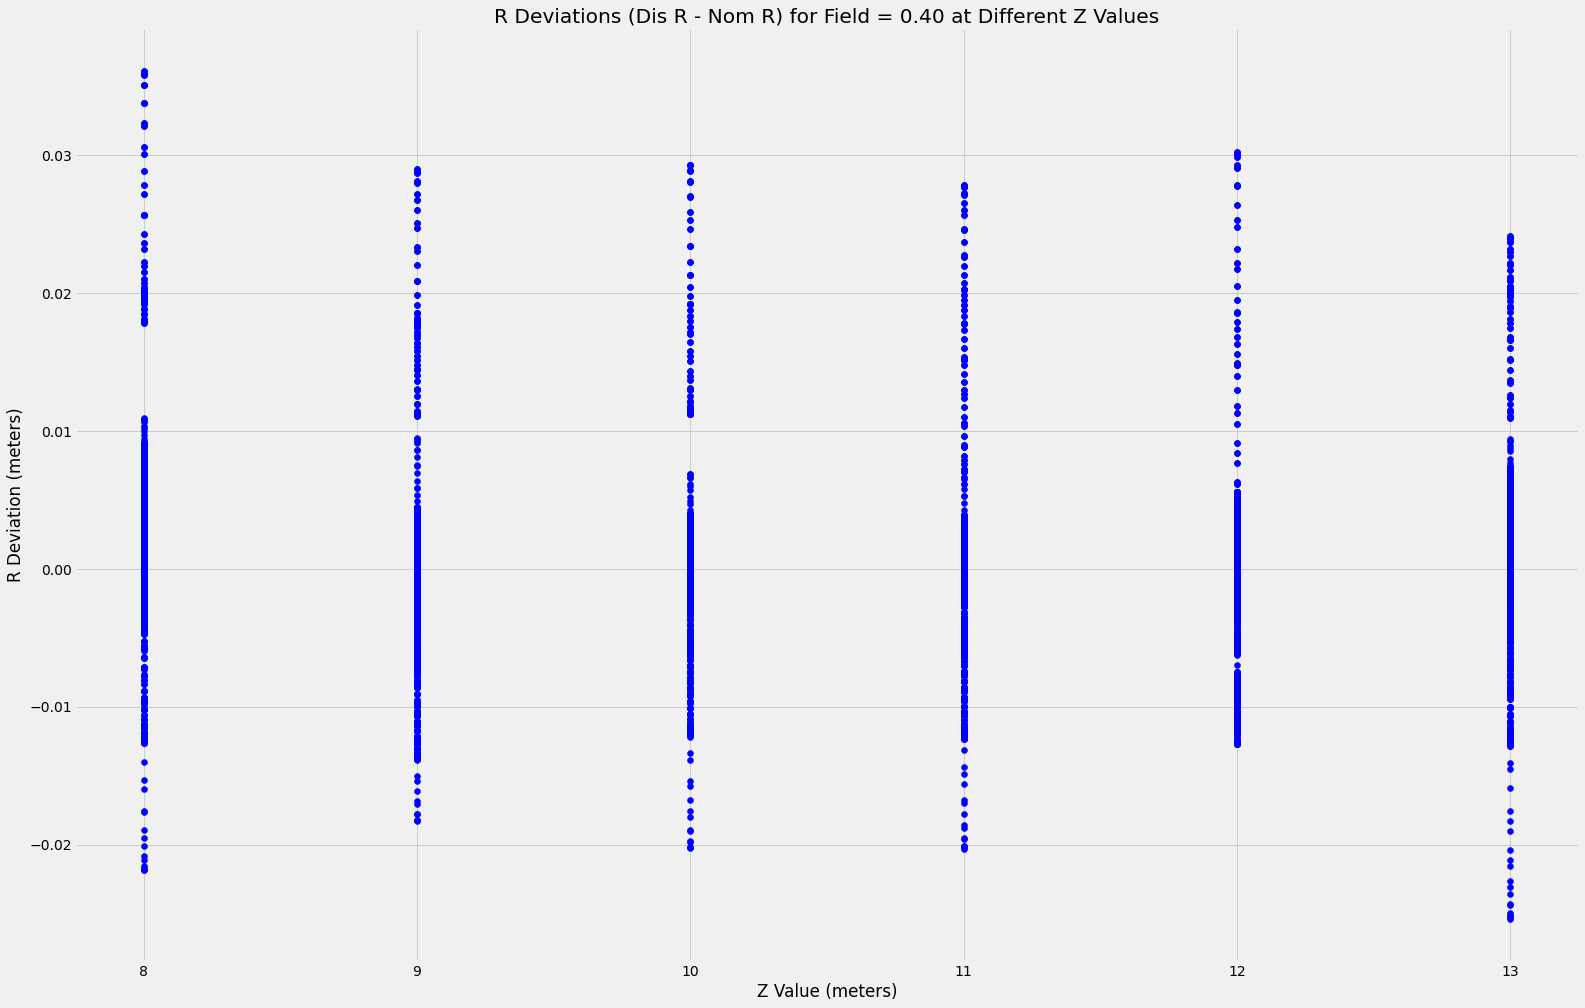

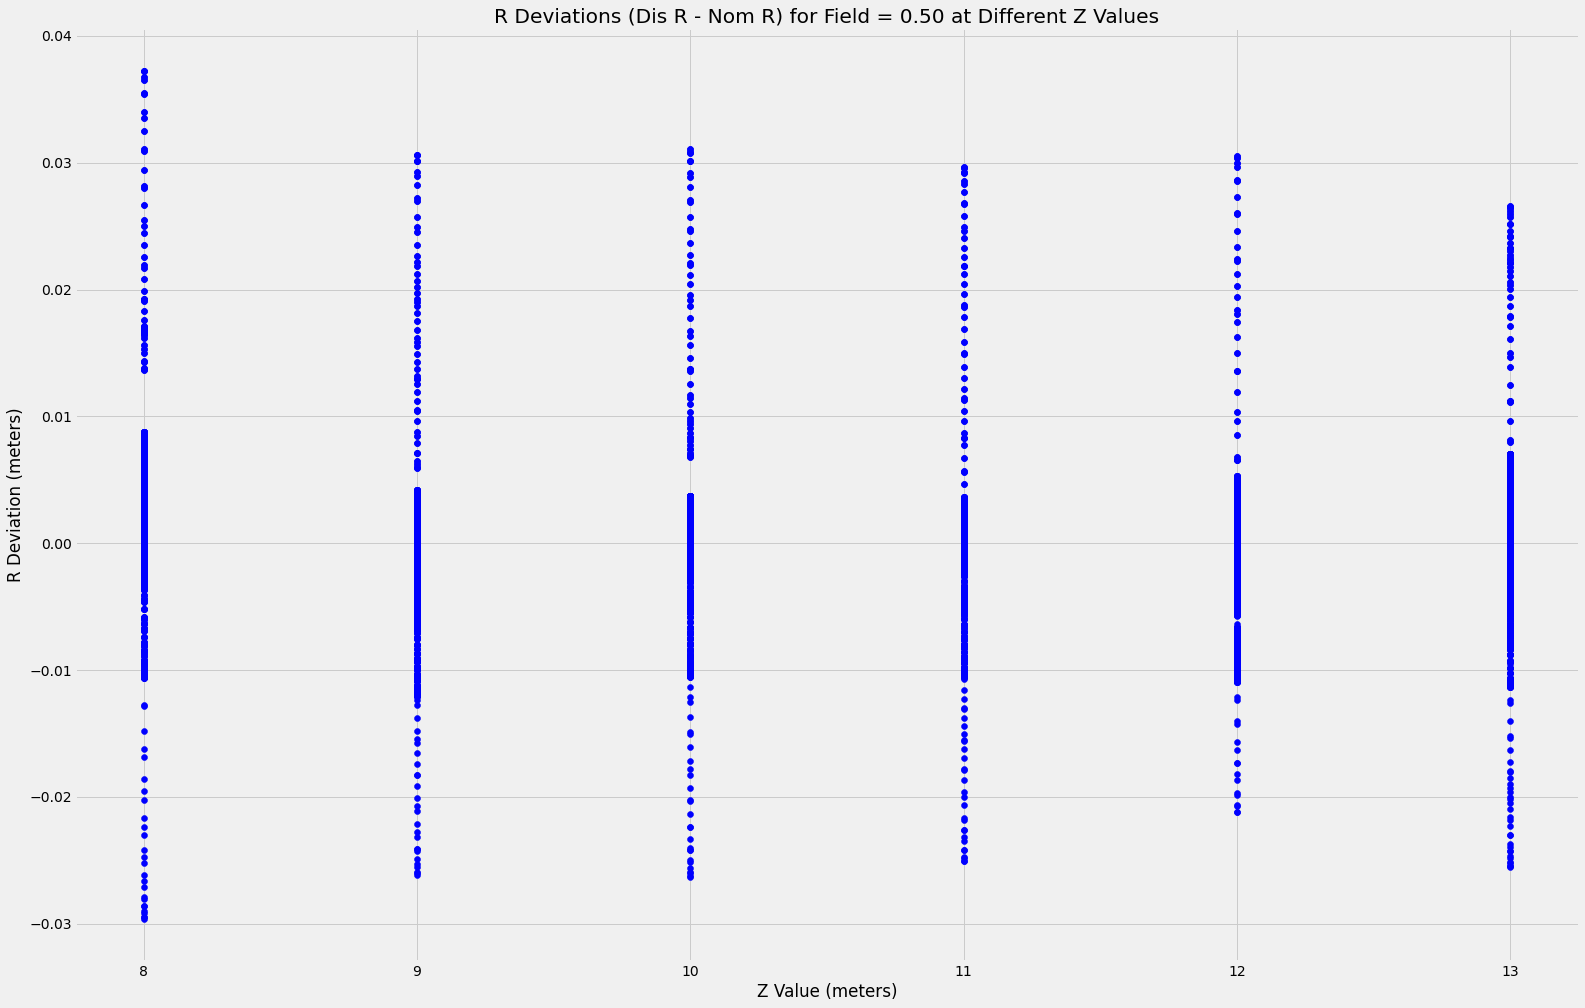

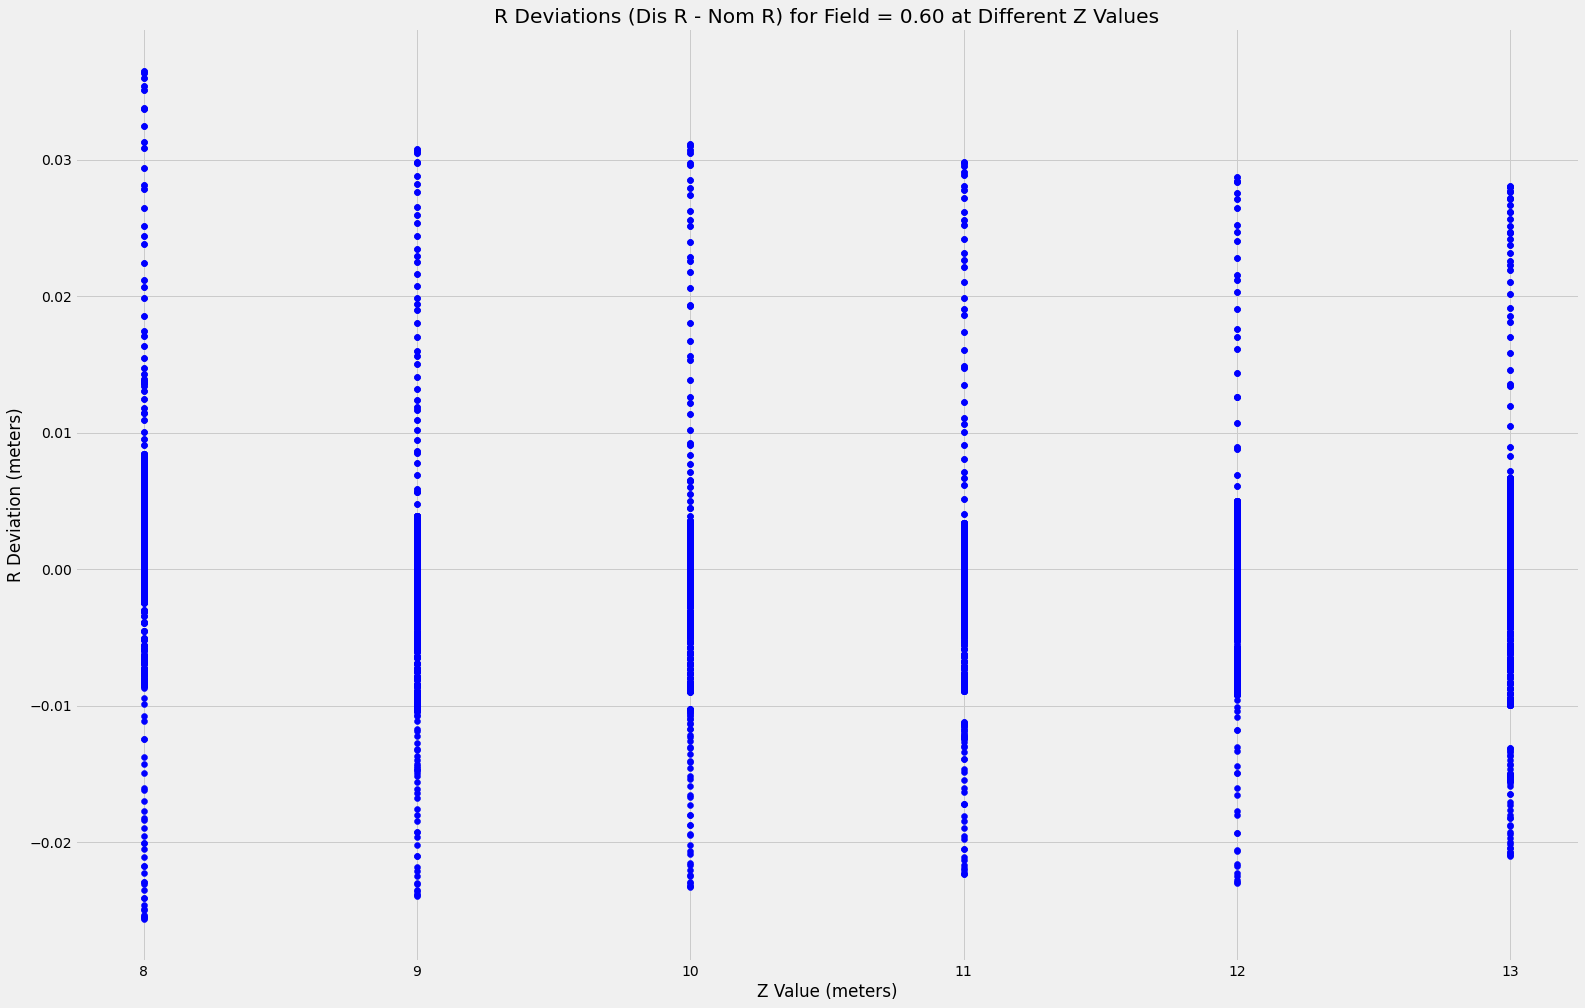

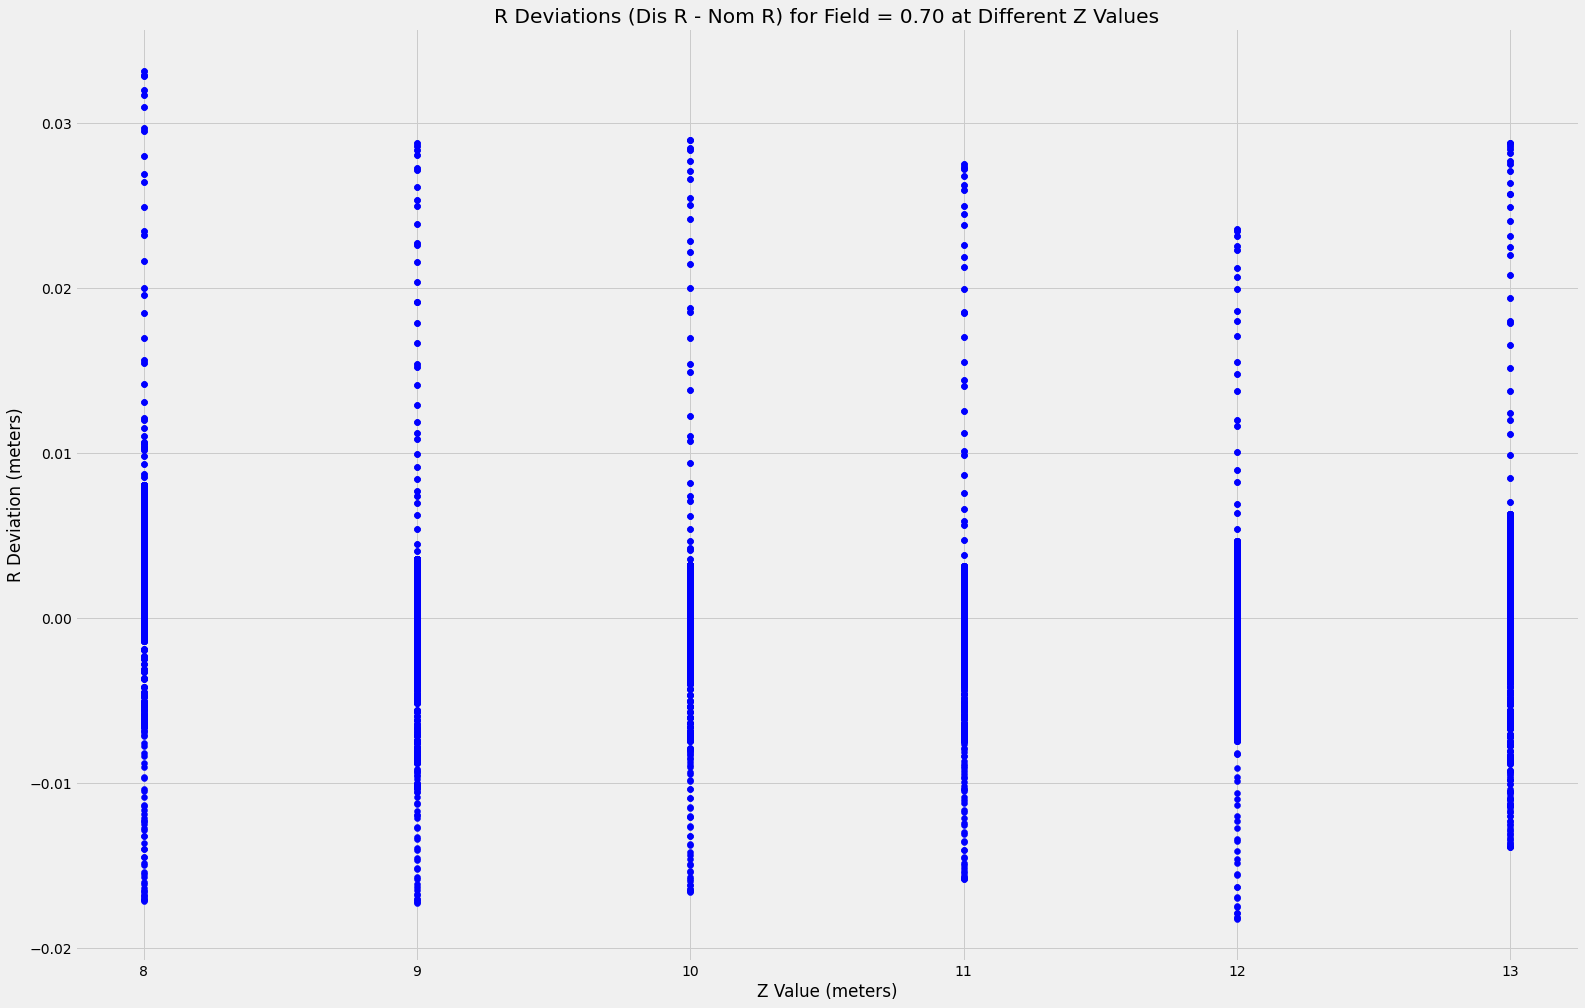

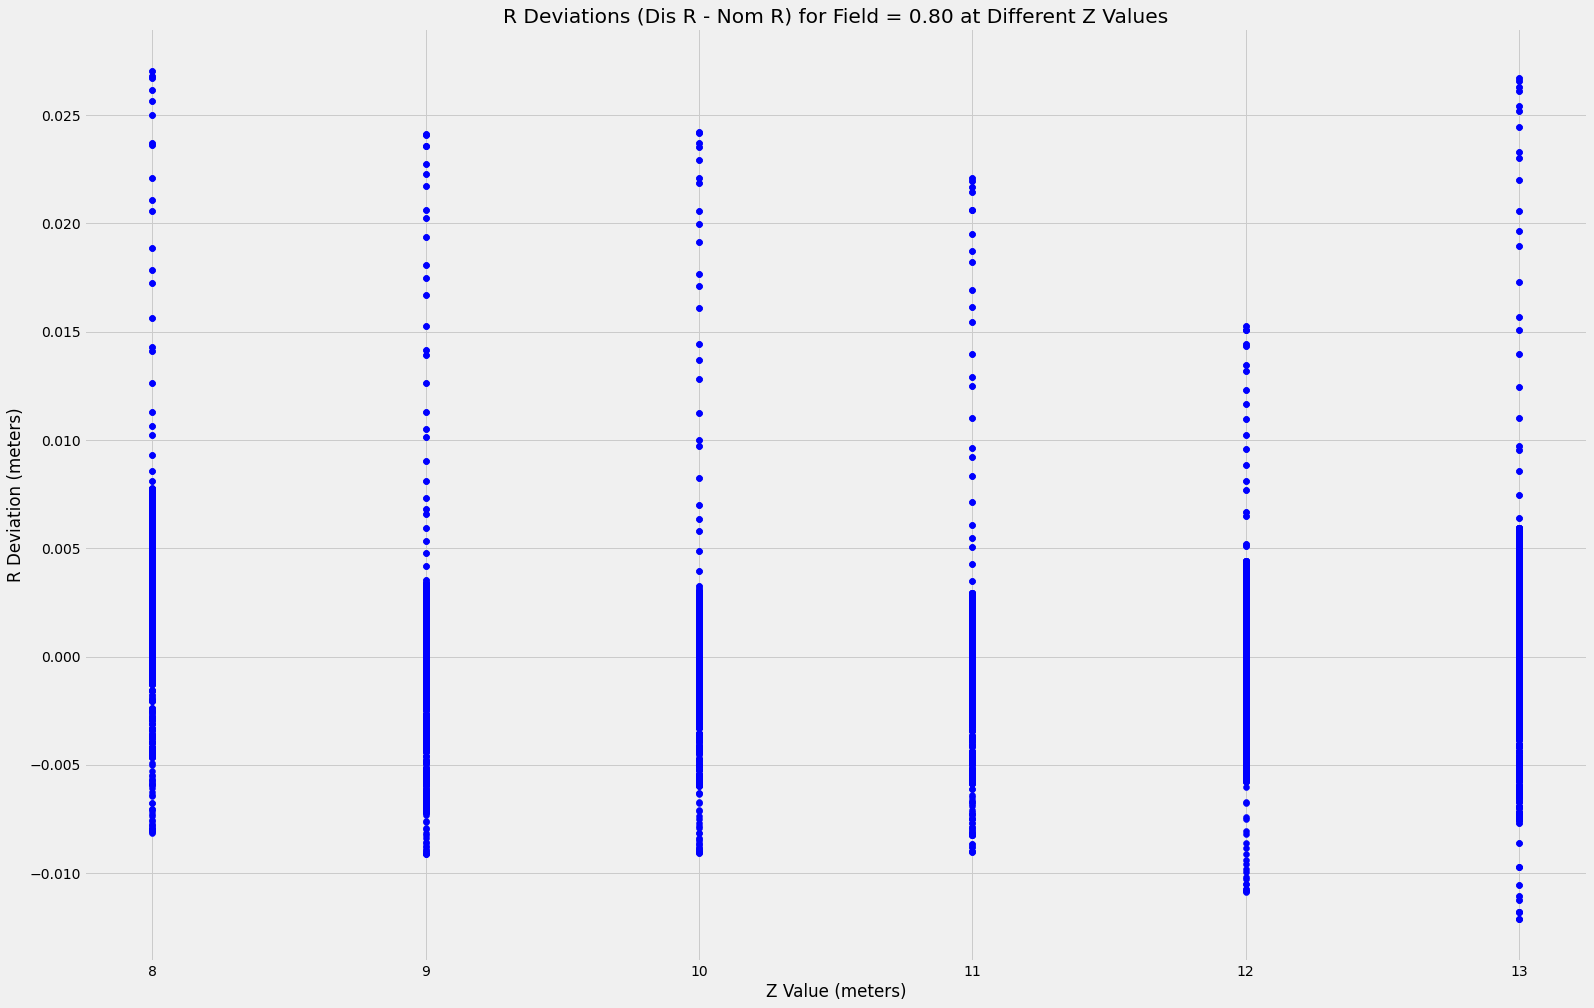

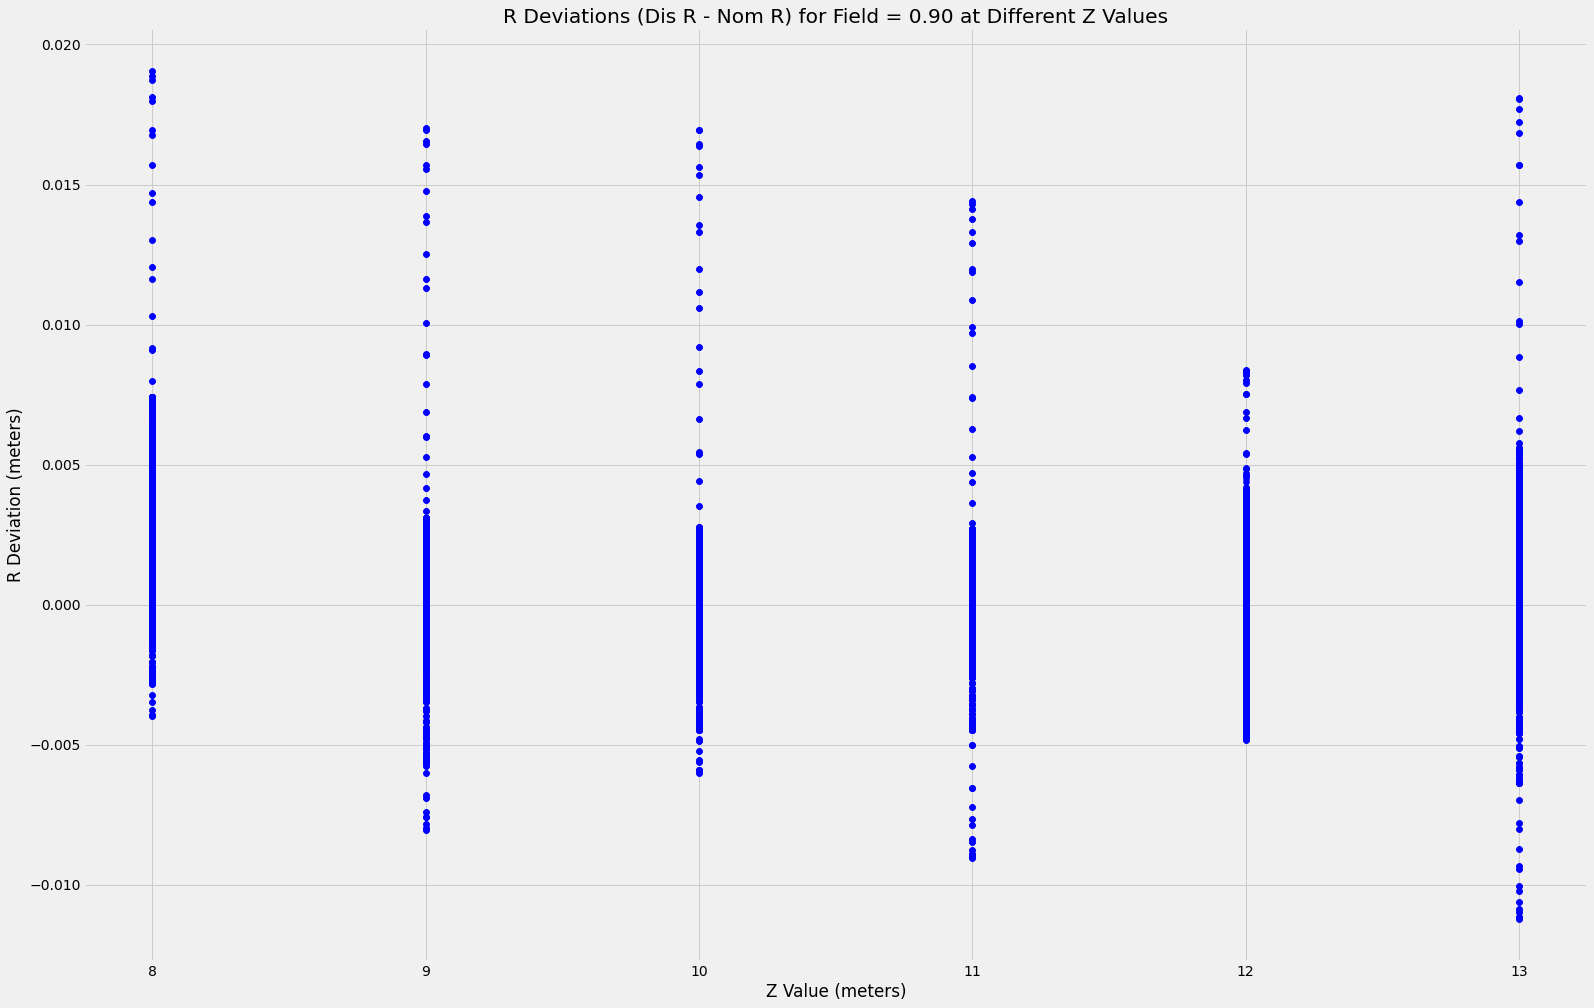

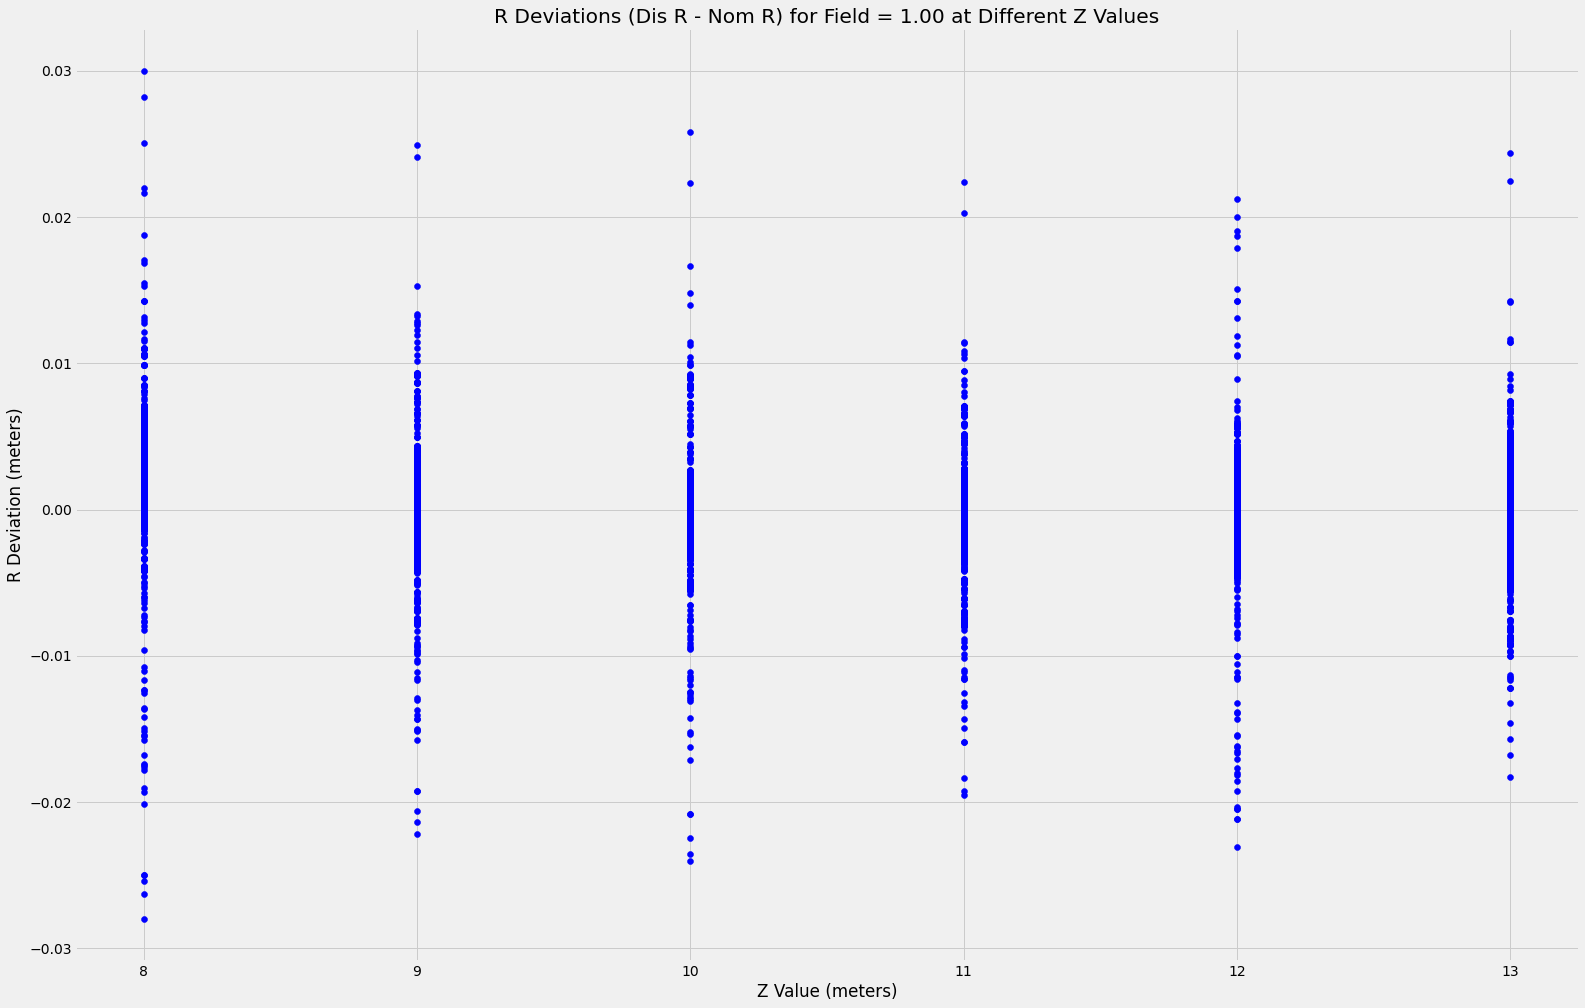

In [37]:
for field in fieldvals2:
    newdf = datadf2[datadf2['field']==field]
    fig = plt.figure()
    plt.scatter(newdf['z'], newdf['rdif'], c = 'blue')
    plt.title(f'R Deviations (Dis R - Nom R) for Field = {field} at Different Z Values')
    plt.xlabel('Z Value (meters)')
    plt.ylabel('R Deviation (meters)')
    fig.savefig(plotdir2+f'/deviations_{field}.png')